In [1]:
import numpy
import sys 
import gym
import numpy as np
import pandas as pd
import warnings
import pickle
from joblib import dump, load
from random import randint
from gym import spaces
import ray
import time
import os
import datetime
import joblib
import datetime

In [2]:
from matplotlib import pyplot as plt

In [3]:
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [4]:
# import tensorflow as tf
# from silence_tensorflow import silence_tensorflow
# silence_tensorflow()

In [5]:
from ray.tune.registry import register_env
from ray.tune.logger import pretty_print

In [6]:
from ray.rllib import agents

In [7]:
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='2'

In [8]:
import warnings
warnings.filterwarnings(action='ignore')

In [9]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 1


In [10]:
ray.shutdown()
ray.init(ignore_reinit_error=True, num_gpus= 1)

{'node_ip_address': '192.168.0.40',
 'raylet_ip_address': '192.168.0.40',
 'redis_address': None,
 'object_store_address': '/tmp/ray/session_2023-02-02_04-00-04_474208_10070/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2023-02-02_04-00-04_474208_10070/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2023-02-02_04-00-04_474208_10070',
 'metrics_export_port': 59701,
 'gcs_address': '192.168.0.40:62445',
 'address': '192.168.0.40:62445',
 'node_id': 'aad670abe891eb3f6bd8a8d1f5645588fa00bc785a11589242d7493b'}

# Get Dataset

In [11]:
df_train = pd.read_feather('/raid/deallab/yechae/ECM/2023/data/ecm_input.ftr')
df_train = df_train.set_index('timestamp_min')
input_feature = ['f3_hum','f10_hum','f3_temp','f10_temp','exthum','enhum','temp','entemp','extemp','F_SET_MODE_0','F_SET_MODE_1','F_SET_MODE_2','F_SET_MODE_3','F_SET_MODE_4','F_SET_MODE_5']
output_feature = ['f3_hum','f10_hum','f3_temp','f10_temp','exthum','temp','extemp']

# Make Init Data

In [12]:
# 모델의 Timewindow별 학습하기 위한 데이터를 나눔
def makeData(df_s,Train_date):
    df_s = df_s.resample('10T').first()    
    df_test = df_s[(pd.to_datetime(df_s.index).date) == (Train_date)]
    
    return df_test

In [13]:
future_target = 10 # 10분 후 예측
past_history = 1 # input window size
start_date = datetime.date(2019,10,16)
Train_date = start_date
print(start_date)
init_date_date = makeData(df_train, Train_date)

2019-10-16


In [14]:
init_date_date

f3_hum  f10_hum  f3_temp  f10_temp  exthum  enhum  temp  \
timestamp_min                                                                  
2019-10-16 00:00:00   44.57    41.92    22.75     23.47    64.7   70.4  35.7   
2019-10-16 00:10:00   44.57    41.92    22.75     23.47    65.0   70.5  35.7   
2019-10-16 00:20:00   44.57    41.92    22.75     23.47    65.6   70.5  35.5   
2019-10-16 00:30:00   44.57    41.92    22.75     23.47    66.3   70.6  35.5   
2019-10-16 00:40:00   44.57    41.92    22.75     23.47    66.7   70.6  35.3   
...                     ...      ...      ...       ...     ...    ...   ...   
2019-10-16 23:10:00   37.62    38.80    25.02     24.32    65.2   80.3  38.5   
2019-10-16 23:20:00   37.62    38.80    25.02     24.30    65.5   80.0  37.9   
2019-10-16 23:30:00   37.82    38.70    25.02     24.30    66.2   79.9  37.8   
2019-10-16 23:40:00   38.02    38.80    24.95     24.32    66.5   79.8  37.6   
2019-10-16 23:50:00   38.02    38.80    24.90     24.30    66.6   79.7  37.2   

                     entemp  extemp  F_SET_MODE_0  F_SET_MODE_1  F_SET_MODE_2  \
timestamp_min                                                                   
2019-10-16 00:00:00    18.9    19.3           1.0           0.0           0.0   
2019-10-16 00:10:00    18.7    19.3           1.0           0.0           0.0   
2019-10-16 00:20:00    18.7    19.1           1.0           0.0           0.0   
2019-10-16 00:30:00    18.7    18.9           1.0           0.0           0.0   
2019-10-16 00:40:00    18.7    18.7           1.0           0.0           0.0   
...                     ...     ...           ...           ...           ...   
2019-10-16 23:10:00    17.9    19.3           1.0           0.0           0.0   
2019-10-16 23:20:00    17.9    19.3           1.0           0.0           0.0   
2019-10-16 23:30:00    17.9    19.1           1.0           0.0           0.0   
2019-10-16 23:40:00    17.8    19.1           1.0           0.0           0.0   
2019-10-16 23:50:00    17.8    19.1           1.0           0.0           0.0   

                     F_SET_MODE_3  F_SET_MODE_4  F_SET_MODE_5  
timestamp_min                                                  
2019-10-16 00:00:00           0.0           0.0           0.0  
2019-10-16 00:10:00           0.0           0.0           0.0  
2019-10-16 00:20:00           0.0           0.0           0.0  
2019-10-16 00:30:00           0.0           0.0           0.0  
2019-10-16 00:40:00           0.0           0.0           0.0  
...                           ...           ...           ...  
2019-10-16 23:10:00           0.0           0.0           0.0  
2019-10-16 23:20:00           0.0           0.0           0.0  
2019-10-16 23:30:00           0.0           0.0           0.0  
2019-10-16 23:40:00           0.0           0.0           0.0  
2019-10-16 23:50:00           0.0           0.0           0.0  

[144 rows x 15 columns]

In [15]:
future_target = 10 # 10분 후 예측
past_history = 1 # input window size
Train_window_size = 1
Train_date = datetime.date(2019,9,20)
model_name = 'gru_1layer'
df_test_pre = makeData(df_train, Train_date )
dl_path = f'/raid/deallab/ecm/model_result_no_window_dl/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w30_{model_name}.h5'

In [16]:
# #학습된 모델호출
# #model = joblib.load(dl_path)
# model = tf.keras.models.load_model(dl_path)

1. for문 돌리기
2. dataset 만들기(df_test_pre)
3. Env 클래스 셋업하기
4. 똑같은 과정!!

# Forecasting Model

In [17]:
def Env_ML(model_path, cur_df, operation_condition, step_cnt, max_action, index, train_data):
    
    model = joblib.load(model_path)
    #model = tf.keras.models.load_model(dl_path)
    action_arr = np.array([0,0,0,0,0,0])
    
    if (operation_condition == 0):
        action_arr[0] = 1
        cur_df = np.append(cur_df, action_arr)        

    elif (operation_condition == 1):
        action_arr[max_action] = 1
        cur_df = np.append(cur_df, action_arr)     

    else:
        print("Wrong Input...")
        print("curr_temp : ", Current_df, ", Action : ", Operation_Condition)
        return;
    
    # enhum : 5
    # entemp : 7
    # enhum, entemp는 실제 값 넣기 
    
    prediction = model.predict(cur_df.reshape(-1, len(input_feature)))

    enhum_value = train_data.iloc[index + step_cnt-1].values[5]
    entemp_value = train_data.iloc[index + step_cnt-1].values[7]
 
    prediction = np.insert(prediction[0], 5, enhum_value)
    prediction = np.insert(prediction, 7, entemp_value)

    return prediction

In [18]:
def Env_DL(model_path, cur_df, operation_condition, step_cnt, max_action):
    model = tf.keras.models.load_model(model_path)
    action_arr = np.array([0,0,0,0,0,0])
    
    if (operation_condition == 0):
        action_arr[0] = 1
        cur_df = np.append(cur_df, action_arr)        

    elif (operation_condition == 1):
        action_arr[max_action] = 1
        cur_df = np.append(cur_df, action_arr)     

    else:
        print("Wrong Input...")
        print("curr_temp : ", Current_df, ", Action : ", Operation_Condition)
        return;
    
    # enhum : 5
    # entemp : 7
    # enhum, entemp는 실제 값 넣기 
    
    prediction = model.predict(cur_df.reshape(-1,1,len(input_feature)))

    enhum_value = df_test_pre.iloc[i + step_cnt].values[5]
    entemp_value = df_test_pre.iloc[i + step_cnt].values[7]
 
    prediction = np.insert(prediction[0], 5, enhum_value)
    prediction = np.insert(prediction, 7, entemp_value)

    return prediction

# ENV 

In [19]:
high = np.array([100000., 100000., 100000., 100000., 100000.,100000., 100000., 100000., 100000.])
low = np.array([-100000., -100000., -100000., -100000., -100000.,-100000., -100000., -100000., -100000.])

In [20]:
MAX_STEPS = 6

In [21]:
# class ECM_Env(gym.Env):
#     def __init__(self, env_config):
#         self.action_space = gym.spaces.Discrete(2)
#         self.observation_space = gym.spaces.Box(low =low,high=high)
#         self.min_temp = env_config['min_temp']
#         self.max_temp = env_config['max_temp']
#         self.method_name = env_config['method_name']
#         self.model = env_config['model']
#         self.max_action = env_config['max_action']
#         self.train_data = init_date_date
#         self.ns = self.reset()
#         self.done = False
#         self.step_cnt = 0
#         self.rewards = []
#         self.norm_rewards = []
        
#     def reset(self):
#         self.step_cnt = 0
#         self.done = False
#         all_data = df_test_pre
#         index = randint(0,len(all_data)-1) 
#         real_value = all_data.iloc[index].values[:9]
#         print("Reset data f3_temp : {}".format(real_value[2]))
#         #print(real_value)
#         return real_value
    
#     def step(self, action):
#         #print(self.step_cnt)
#         self.step_cnt = self.step_cnt + 1
#         before_status = self.ns
        
#         method = eval(self.method_name)

#         # call it like a regular function later
#         args = [self.model, self.ns, action, self.step_cnt, self.max_action]
#         kwargs = {}
#         next_state = method(*args, **kwargs)
#         #next_state = Env_DL(self.model, self.ns, action, self.step_cnt, self.max_action)
        
        
#         # model, cur_df, operation_condition, step_cnt, max_action
#         #next_state = Env(self.model, self.ns, action, self.step_cnt, self.max_action)
#         next_temp = round(next_state[2], 2)
#         self.ns = next_state
        
#         next_power_consumption = self.power_consumption(action)
        
        
#         temp_violation = np.abs(next_temp - self.max_temp) + np.abs(self.min_temp - next_temp)
    
#         action_reward = self.reward_al(before_status[0], action)


#         temp_violation_reward = round(temp_violation, 2)
#         power_reward = round(0.001 * next_power_consumption, 2)
#         reward = (action_reward * 2)  - temp_violation_reward - power_reward 
#         #reward = -temp_violation_reward - power_reward
#         reward = round(reward, 2)
        
#         if self.step_cnt >= MAX_STEPS:
#             self.done = True     
#         return next_state, reward, self.done, {}
     
#     def result_step(self, action):
#         before_status = self.ns
#         next_env = Env([self.ns], action)
#         next_step = round(next_env[2], 2)
#         reward = 0
#         self.ns = next_env

#         next_env[0][0] = next_step
#         return next_env, reward, next_step, {}
    
#     def power_consumption(self, action):
#         return 0 if action==0 else 200
        
#     def temp_violation_func(self, f3_temp, temp_violation):
#         violation = 0
#         if f3_temp < self.min_temp:
#             violation = violation - (temp_violation * 1)
#             #violation = np.abs(f3_temp - self.min_temp)
#         elif f3_temp > self.max_temp:
#             violation = violation - (temp_violation * 10)
#             #violation = np.abs(f3_temp - self.max_temp)
#         elif self.min_temp <= f3_temp <= self.max_temp:
#             violation = violation + (temp_violation * 10)
        
#         return violation
    
#     def reward_al(self, f3_temp, action):
#         reward = 0
#         if f3_temp >= self.max_temp and action == 1:
#             reward = reward + 1
#         if f3_temp >= self.max_temp and action == 0:
#             reward = reward - 1
#         if f3_temp <= self.min_temp and action == 1:
#             reward = reward - 1
#         if f3_temp <= self.min_temp and action == 0:
#             reward = reward + 1
#         if f3_temp <= self.max_temp and f3_temp >= self.min_temp:
#             if action == 0:
#                 reward = reward + 1
#             if action == 1:                
#                 #random_action = random.randint(0,1)
#                 reward = reward + 0
#                 #reward = reward + random_action
                
#         return reward  
    
# #     def reward_al(self, f3_temp, action):
# #         reward = 0
# #         if f3_temp >= self.max_temp and action == 1:
# #             reward = reward + 100
# #         if f3_temp >= self.max_temp and action == 0:
# #             reward = reward -100
# #         if f3_temp <= self.min_temp and action == 1:
# #             reward = reward - 100
# #         if f3_temp <= self.min_temp and action == 0:
# #             reward = reward + 100
# #         if f3_temp <= self.max_temp and f3_temp >= self.min_temp:
# #             if action == 0:
# #                 reward = reward + 100
# #             if action == 1:                
# #                 #random_action = random.randint(0,1)
# #                 reward = reward + 10
# #                 #reward = reward + random_action
                
# #         return reward   
    
#     def seed (self, seed=None):
#         """Sets the seed for this env's random number generator(s).
#         Note:
#             Some environments use multiple pseudorandom number generators.
#             We want to capture all such seeds used in order to ensure that
#             there aren't accidental correlations between multiple generators.
#         Returns:
#             list<bigint>: Returns the list of seeds used in this env's random
#               number generators. The first value in the list should be the
#               "main" seed, or the value which a reproducer should pass to
#               'seed'. Often, the main seed equals the provided 'seed', but
#               this won't be true if seed=None, for example.
#         """
#         self.np_random, seed = seeding.np_random(seed)
#         return [seed]
    
#     def close (self):
#         """Override close in your subclass to perform any necessary cleanup.
#         Environments will automatically close() themselves when
#         garbage collected or when the program exits.
#         """
#         pass
        

In [22]:
class ECM_Env_DL(gym.Env):
    def __init__(self, env_config):
        self.init_data = df_test_pre
        self.model_path = ""
        self.index = 0
        self.action_space = gym.spaces.Discrete(2)
        self.observation_space = gym.spaces.Box(low =low,high=high)
        self.min_temp = env_config['min_temp']
        self.max_temp = env_config['max_temp']
        self.method_name = env_config['method_name']
        self.model = ""
        self.max_action = env_config['max_action']
        self.train_data = init_date_date
        self.ns = self.reset()
        self.done = False
        self.step_cnt = 0
        self.rewards = []
        self.norm_rewards = []
    
    def reset(self):
        self.step_cnt = 0
        self.done = False
        all_data = df_test_pre
        index = randint(0,len(all_data)-7)
        self.index = index
        real_value = all_data.iloc[index].values[:9]
        print("Reset data f3_temp : {}".format(real_value[2]))
        #print(real_value)
        return real_value
    
#     def setModelPath(self, model_path):
#         self.model_path = model_path
#         print(self.model_path)
#     def getModelPath(self):
#         return self.model_path
#     def setInitData(self, init_data):
#         self.init_data = init_data
#         print("Reset data date:", self.init_data.iloc[0].name)
#     def getInitData(self):
#         return self.init_data
    
    def step(self, action):
        #print(self.step_cnt)
        self.step_cnt = self.step_cnt + 1
        before_status = self.ns
        
       # method = eval(self.method_name)

        # call it like a regular function later
        #args = [self.model, self.ns, action, self.step_cnt, self.max_action]
        #kwargs = {}
        #next_state = method(*args, **kwargs)
        next_state = Env_DL(self.model, self.ns, action, self.step_cnt, self.max_action, self.index)
        
        
        # model, cur_df, operation_condition, step_cnt, max_action
        #next_state = Env(self.model, self.ns, action, self.step_cnt, self.max_action)
        next_temp = round(next_state[2], 2)
        self.ns = next_state
        
        next_power_consumption = self.power_consumption(action)
        
        
        temp_violation = np.abs(next_temp - self.max_temp) + np.abs(self.min_temp - next_temp)
    
        action_reward = self.reward_al(before_status[0], action)


        temp_violation_reward = round(temp_violation, 2)
        power_reward = round(0.001 * next_power_consumption, 2)
        #reward = (action_reward * 2)  - temp_violation_reward - power_reward 
        reward = (action_reward * 4)  - temp_violation_reward - power_reward 
        #reward = -temp_violation_reward - power_reward
        reward = round(reward, 2)
        
        if self.step_cnt >= MAX_STEPS:
            self.done = True     
        return next_state, reward, self.done, {}
     
    def result_step(self, action):
        before_status = self.ns
        next_env = Env([self.ns], action)
        next_step = round(next_env[2], 2)
        reward = 0
        self.ns = next_env

        next_env[0][0] = next_step
        return next_env, reward, next_step, {}
    
    def power_consumption(self, action):
        return 0 if action==0 else 200
        
    def temp_violation_func(self, f3_temp, temp_violation):
        violation = 0
        if f3_temp < self.min_temp:
            violation = violation - (temp_violation * 1)
            #violation = np.abs(f3_temp - self.min_temp)
        elif f3_temp > self.max_temp:
            violation = violation - (temp_violation * 10)
            #violation = np.abs(f3_temp - self.max_temp)
        elif self.min_temp <= f3_temp <= self.max_temp:
            violation = violation + (temp_violation * 10)
        
        return violation
    
    def reward_al(self, f3_temp, action):
        reward = 0
        if f3_temp >= self.max_temp and action == 1:
            reward = reward + 1
        if f3_temp >= self.max_temp and action == 0:
            reward = reward - 1
        if f3_temp <= self.min_temp and action == 1:
            reward = reward - 1
        if f3_temp <= self.min_temp and action == 0:
            reward = reward + 1
        if f3_temp <= self.max_temp and f3_temp >= self.min_temp:
            if action == 0:
                reward = reward + 1
            if action == 1:                
                #random_action = random.randint(0,1)
                reward = reward + 0
                #reward = reward + random_action
                
        return reward  
    
#     def reward_al(self, f3_temp, action):
#         reward = 0
#         if f3_temp >= self.max_temp and action == 1:
#             reward = reward + 100
#         if f3_temp >= self.max_temp and action == 0:
#             reward = reward -100
#         if f3_temp <= self.min_temp and action == 1:
#             reward = reward - 100
#         if f3_temp <= self.min_temp and action == 0:
#             reward = reward + 100
#         if f3_temp <= self.max_temp and f3_temp >= self.min_temp:
#             if action == 0:
#                 reward = reward + 100
#             if action == 1:                
#                 #random_action = random.randint(0,1)
#                 reward = reward + 10
#                 #reward = reward + random_action
                
#         return reward   
    
    def seed (self, seed=None):
        """Sets the seed for this env's random number generator(s).
        Note:
            Some environments use multiple pseudorandom number generators.
            We want to capture all such seeds used in order to ensure that
            there aren't accidental correlations between multiple generators.
        Returns:
            list<bigint>: Returns the list of seeds used in this env's random
              number generators. The first value in the list should be the
              "main" seed, or the value which a reproducer should pass to
              'seed'. Often, the main seed equals the provided 'seed', but
              this won't be true if seed=None, for example.
        """
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    def close (self):
        """Override close in your subclass to perform any necessary cleanup.
        Environments will automatically close() themselves when
        garbage collected or when the program exits.
        """
        pass
        

In [23]:
class ECM_Env_ML(gym.Env):
    def __init__(self, env_config):
        self.init_data = env_config['init_data']
        self.model_path = ""
        self.index = 0
        self.action_space = gym.spaces.Discrete(2)
        self.observation_space = gym.spaces.Box(low =low,high=high)
        self.min_temp = env_config['min_temp']
        self.max_temp = env_config['max_temp']
        self.method_name = env_config['method_name']
        self.model = env_config['model']
        self.max_action = env_config['max_action']
        self.train_data = init_date_date
        self.ns = self.reset()
        self.done = False
        self.step_cnt = 0
        self.rewards = []
        self.norm_rewards = []
        
    def reset(self):
        self.step_cnt = 0
        self.done = False
        all_data = self.init_data
        index = randint(0,len(all_data)-7)
        self.index = index
        real_value = all_data.iloc[index].values[:9]
        print("Reset data f3_temp : {}".format(real_value[2]))
        #print(real_value)
        return real_value
    
    
#     def setModelPath(self, model_path):
#         self.model_path = model_path
#         print(self.model_path)
#     def getModelPath(self):
#         return self.model_path
#     def setInitData(self, init_data):
#         self.init_data = init_data
#         print("Reset data date:", self.init_data.iloc[0].name)
#     def getInitData(self):
#         return self.init_data
    
    def step(self, action):
        #print(self.step_cnt)
        self.step_cnt = self.step_cnt + 1
        before_status = self.ns
        
       # method = eval(self.method_name)

        # call it like a regular function later
        #args = [self.model, self.ns, action, self.step_cnt, self.max_action]
        #kwargs = {}
        #next_state = method(*args, **kwargs)
        next_state = Env_ML(self.model, self.ns, action, self.step_cnt, self.max_action, self.index, self.init_data)
        
        
        # model, cur_df, operation_condition, step_cnt, max_action
        #next_state = Env(self.model, self.ns, action, self.step_cnt, self.max_action)
        next_temp = round(next_state[2], 2)
        self.ns = next_state
        
        next_power_consumption = self.power_consumption(action)
        
        
        #temp_violation = np.abs(next_temp - self.max_temp) + np.abs(self.min_temp - next_temp)
        temp_violation = self.temp_violation_func(next_temp)
    
        action_reward = self.reward_al(before_status[2], action)


        temp_violation_reward = round(temp_violation * 0.001 , 2)
        power_reward = np.abs(round(0.0001 * next_power_consumption, 2))
        #reward = (action_reward * 2.5)  - temp_violation_reward - power_reward 
        reward = (action_reward * 2.5) - temp_violation_reward - power_reward
        #reward = (action_reward * 5)  - temp_violation_reward - power_reward, power reward = 0.1
        #reward = action_reward * 2
        #reward = -temp_violation_reward - power_reward
        reward = round(reward, 2)
        
        if self.step_cnt >= MAX_STEPS:
            self.done = True     
        return next_state, reward, self.done, {}
     
    def result_step(self, action):
        before_status = self.ns
        next_env = Env([self.ns], action)
        next_step = round(next_env[2], 2)
        reward = 0
        self.ns = next_env

        next_env[0][0] = next_step
        return next_env, reward, next_step, {}
    
    def power_consumption(self, action):
        return 0 if action==0 else 200
        
#     def temp_violation_func(self, f3_temp, temp_violation):
#         violation = 0
#         if f3_temp < self.min_temp:
#             violation = violation - (temp_violation * 1)
#             #violation = np.abs(f3_temp - self.min_temp)
#         elif f3_temp > self.max_temp:
#             violation = violation - (temp_violation * 10)
#             #violation = np.abs(f3_temp - self.max_temp)
#         elif self.min_temp <= f3_temp <= self.max_temp:
#             violation = violation + (temp_violation * 10)
        
#         return violation
    def temp_violation_func(self, f3_temp):
        vio_reward = 0
        if f3_temp <= self.max_temp and f3_temp >= self.min_temp:
            vio_reward = 0
        if f3_temp > self.max_temp:
            vio_reward = np.abs(f3_temp - self.max_temp)
        if f3_temp < self.min_temp:
            #vio_reward = np.abs(f3_temp - self.min_temp)
            vio_reward = 0.2
            
        return vio_reward
        
    
    def reward_al(self, f3_temp, action):
        reward = 0
        if f3_temp >= self.max_temp and action == 1:
            reward = reward + 1
            reward = reward 
        if f3_temp >= self.max_temp and action == 0:
            reward = reward - 1
        if f3_temp <= self.min_temp and action == 1:
            reward = reward - 1
        if f3_temp <= self.min_temp and action == 0:
            reward = reward + 1
        if f3_temp <= self.max_temp and f3_temp >= self.min_temp:
            if action == 0:
                reward = reward + 1
            if action == 1:                
                #random_action = random.randint(0,1)
                reward = reward + 0
                #reward = reward + random_action
                
        return reward  
    
#     def reward_al(self, f3_temp, action):
#         reward = 0
#         if f3_temp >= self.max_temp and action == 1:
#             reward = reward + 100
#         if f3_temp >= self.max_temp and action == 0:
#             reward = reward -100
#         if f3_temp <= self.min_temp and action == 1:
#             reward = reward - 100
#         if f3_temp <= self.min_temp and action == 0:
#             reward = reward + 100
#         if f3_temp <= self.max_temp and f3_temp >= self.min_temp:
#             if action == 0:
#                 reward = reward + 100
#             if action == 1:                
#                 #random_action = random.randint(0,1)
#                 reward = reward + 10
#                 #reward = reward + random_action
                
#         return reward   
    
    def seed (self, seed=None):
        """Sets the seed for this env's random number generator(s).
        Note:
            Some environments use multiple pseudorandom number generators.
            We want to capture all such seeds used in order to ensure that
            there aren't accidental correlations between multiple generators.
        Returns:
            list<bigint>: Returns the list of seeds used in this env's random
              number generators. The first value in the list should be the
              "main" seed, or the value which a reproducer should pass to
              'seed'. Often, the main seed equals the provided 'seed', but
              this won't be true if seed=None, for example.
        """
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    def close (self):
        """Override close in your subclass to perform any necessary cleanup.
        Environments will automatically close() themselves when
        garbage collected or when the program exits.
        """
        pass
        

In [24]:
# env_config = {'max_temp': 27, 'min_temp' : 21}
# env = ECM_Env(env_config)

In [25]:
df_test_pre.iloc[0].name

Timestamp('2019-09-20 00:00:00', freq='10T')

In [26]:
env_config = {'max_temp': 24, 'min_temp' : 23, 'method_name': "Env_DL", 'model' : '/raid/deallab/ecm/model_result_no_window_dl/2019-09-20/20190920w14_gru_1layer.h5', 'max_action' : 1}
env = ECM_Env_DL(env_config)

Reset data f3_temp : 20.37


In [27]:
env.reset()

Reset data f3_temp : 20.37


array([51.47, 46.05, 20.37, 21.67, 86.5 , 69.3 , 37.6 , 22.3 , 15.1 ])

In [28]:
# for i in range(5):
#     a, b, c, d = env.step(0)
#     print(a)

In [29]:

import tempfile
from ray.tune.logger import UnifiedLogger
def custom_log_creator(custom_path, custom_str):
    
    timestr = datetime.datetime.today().strftime("%Y-%m-%d_%H-%M-%S")
    logdir_prefix = "{}_{}".format(custom_str, timestr)
    def logger_creator(config):
    
        if not os.path.exists(custom_path):
            os.makedirs(custom_path)
        logdir = tempfile.mkdtemp(prefix=logdir_prefix, dir=custom_path)
        return UnifiedLogger(config, logdir, loggers=None)

    return logger_creator


In [30]:
def getMaxAction(df_test_pre):
    action_list = []
    action_list.append(df_test_pre.F_SET_MODE_0.sum())
    action_list.append(df_test_pre.F_SET_MODE_1.sum())
    action_list.append(df_test_pre.F_SET_MODE_2.sum())
    action_list.append(df_test_pre.F_SET_MODE_3.sum())
    action_list.append(df_test_pre.F_SET_MODE_4.sum())
    action_list.append(df_test_pre.F_SET_MODE_5.sum())
    #print("{} - ACTION 0 : {}, 1 : {}, 2: {}, 3: {}, 4: {}, 5: {}".format(Train_date, df_test_pre.F_SET_MODE_0.sum(),df_test_pre.F_SET_MODE_1.sum(),df_test_pre.F_SET_MODE_2.sum(),df_test_pre.F_SET_MODE_3.sum(),df_test_pre.F_SET_MODE_4.sum(),df_test_pre.F_SET_MODE_5.sum()))
    #print(action_list.index(max(action_list)))
    return action_list.index(max(action_list))

# GET Best Forecasting Model List

In [31]:
best_forecastmodel = pd.read_csv("/raid/deallab/yechae/ECM/2023/data/linear_regressor_best_t3_rmse.csv")
best_forecastmodel = best_forecastmodel.set_index(best_forecastmodel.date)
best_forecastmodel = best_forecastmodel.drop('date', axis=1)
ml_models = ['extra_trees_regressor', 'xgb_regressor','linear_svr', 'xgbrf_regressor', 'linear_tree_regressor', 'linear_regression']
dl_models = ['gru_1layer',  'simpleRNN']

In [32]:
best_forecastmodel

model  window_size        t3_mae       t3_rmse  \
date                                                                     
2019-08-23  linear_regression            1  1.471099e-01  3.714375e-01   
2019-08-24  linear_regression            1  2.861478e-01  4.111759e-01   
2019-08-25  linear_regression            1  1.154393e-01  1.370982e-01   
2019-08-26  linear_regression            1  2.996205e-15  3.262615e-15   
2019-08-27  linear_regression            1  9.750167e-01  1.416785e+00   
...                       ...          ...           ...           ...   
2019-10-20  linear_regression            1  4.016957e-02  5.115313e-02   
2019-10-21  linear_regression           14  3.220961e-02  5.069454e-02   
2019-10-22  linear_regression            7  2.688419e-02  4.725529e-02   
2019-10-23  linear_regression           30  5.696565e-02  1.403227e-01   
2019-10-24  linear_regression            7  5.084847e-02  7.282941e-02   

               t3_mape             1         [         2         3         4  
date                                                                          
2019-08-23   93.930399  5.974359e-03  1.590579  1.889319 -1.462644  0.028358  
2019-08-24   89.471188  1.311018e-02  0.401321  0.548269  0.709518  0.007762  
2019-08-25  -15.311966  5.458642e-03  0.143140  0.173085 -0.003137  0.002751  
2019-08-26 -438.392857  1.422024e-16  0.000000  0.000000  1.000000  0.000000  
2019-08-27   14.785691  4.164219e-02  0.856755  1.344554  0.000000  0.016476  
...                ...           ...       ...       ...       ...       ...  
2019-10-20   91.599138  1.670757e-03  0.284817  0.489013  0.955812  0.007659  
2019-10-21   82.190496  1.337197e-03  0.312730  0.718734  0.921034  0.008462  
2019-10-22   86.933115  1.143585e-03  0.257110  0.404504  0.877164  0.007026  
2019-10-23   79.127448  2.395269e-03  0.324199  0.663960  0.745473  0.008840  
2019-10-24   94.966786  2.167679e-03  0.270108  0.356713  0.729212  0.007396  

[63 rows x 10 columns]

In [34]:
  
# for i in range(54):
#     # 1. dataset 만들기
#     #  method_name, model, action, max_action
#     cur_model = best_forecastmodel[(pd.to_datetime(best_forecastmodel.index).date) == Train_date]
#     df_test_pre = train_model_data(df_train, Train_window_size, Train_date )
#     date = datetime.datetime.strptime(cur_model.index.values[0], '%Y-%m-%d')
#     Train_window_size = cur_model.TimeWindows.values[0]
#     model_name = cur_model.Model.values[0]
    
#     dl_path = f'/raid/deallab/ecm/model_result_no_window_dl/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w{Train_window_size}_{model_name}.h5'
#     ml_path = f'/raid/deallab/ecm/model_result_no_window/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w{Train_window_size}_{model_name}.joblib'

#     if model_name in ml_models:
#         path = ml_path
#         print("ML : ", model_name)
#         model = joblib.load(path)
#         method_name = "Env_ML"
#     else:
#         path = dl_path
#         print("DL : ", model_name)
#         model = tf.keras.models.load_model(dl_path)
#         method_name = "Env_DL"
#     max_action = getMaxAction(df_test_pre)
    
#     # ENV 세팅
#     env_config = {'max_temp': 27, 'min_temp' : 21, 'method_name': method_name, 'model' : model, 'max_action' : max_action}
#     env = ECM_Env(env_config)
    
    
    
    
#     Train_date = Train_date+datetime.timedelta(days=1)
    
    

In [34]:
# Train_date = datetime.date(2019,9,22)
# # init 
# cur_model = best_forecastmodel[(pd.to_datetime(best_forecastmodel.index).date) == Train_date]
# df_test_pre = makeData(df_train, Train_date )
# date = datetime.datetime.strptime(cur_model.index.values[0], '%Y-%m-%d')
# Train_window_size = cur_model.TimeWindows.values[0]
# model_name = cur_model.Model.values[0]

# dl_path = f'/raid/deallab/ecm/model_result_no_window_dl/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w{Train_window_size}_{model_name}.h5'
# ml_path = f'/raid/deallab/ecm/model_result_no_window/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w{Train_window_size}_{model_name}.joblib'
# if model_name in ml_models:
#     path = ml_path
#     print("ML : ", model_name)
#     #model = joblib.load(path)
#     method_name = "Env_ML"
# else:
#     path = dl_path
#     print("DL : ", model_name)
#     #model = tf.keras.models.load_model(dl_path)
#     method_name = "Env_DL"
# print(path)
# max_action = getMaxAction(df_test_pre)

# # ENV 세팅
# env_config = {'max_temp': 27, 'min_temp' : 21, 'method_name': method_name, 'model' : path, 'max_action' : max_action}
# env = ECM_Env_ML(env_config)

# select_env = "ECMEnv2023-v0"
# register_env(select_env, lambda config: ECM_Env_ML(env_config))

# config_dqn = agents.dqn.DEFAULT_CONFIG.copy()
# config_dqn["log_level"] = "WARN"
# config_dqn["env"] = select_env
# config_dqn["env_config"] = env_config
# config_dqn["evaluation_num_workers"] = 1
# config_dqn["train_batch_size"] = 256
# # config_dqn["model.fcnet_activation"] = 'relu'
# config_dqn["target_network_update_freq"] = 50
# config_dqn["learning_starts"] = 1500
# config_dqn["timesteps_per_iteration"] = 144
# config_dqn["num_gpus_per_worker"] = 1
# config_dqn["model"]["custom_model"] = False
# #config_dqn["model"]["custom_model"] = "my_model"
# config_dqn["model"]["fcnet_hiddens"] = [256,256]
# config_dqn["model"]["fcnet_activation"] = "relu"
# config_dqn["n_step"] = 144
# config_dqn["dueling"] = False
# config_dqn["double_q"] = False

# save_path = f'/raid/deallab/yechae/ECM/2023/result/{Train_date.strftime("%Y-%m-%d")}/' #./result/agent
# print(save_path)
# trainer_dqn = agents.dqn.DQNTrainer(config_dqn, env=select_env, logger_creator = custom_log_creator(os.path.expanduser(save_path), 'RL_ECM_DQN'))

In [36]:
Train_date =  datetime.date(2019,8,23)
#start_date = datetime.date(2019, 8,23)
#end_date = datetime.date(2019,10,24)
#daterange = pd.date_range(Train_date, end_date)
# init 
cur_model = best_forecastmodel[(pd.to_datetime(best_forecastmodel.index).date) == Train_date]
df_test_pre = makeData(df_train, Train_date)
date = datetime.datetime.strptime(cur_model.index.values[0], '%Y-%m-%d')
Train_window_size = cur_model.window_size.values[0]
model_name = cur_model.model.values[0]

#dl_path = f'/raid/deallab/ecm/model_result_no_window_dl/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w{Train_window_size}_{model_name}.h5'
path = f'/raid/deallab/ecm/model_result/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w{Train_window_size}_linear_regression.joblib'
print(path)


max_action = getMaxAction(df_test_pre)

# ENV 세팅
env_config = {'max_temp': 25, 'min_temp' : 23.5, 'method_name': "ML", 'model' : path, 'max_action' : max_action, 'init_data' : df_test_pre}
env = ECM_Env_ML(env_config)

select_env = "ECMEnv2023-v0"
register_env(select_env, lambda config: ECM_Env_ML(env_config))

config_dqn = agents.dqn.DEFAULT_CONFIG.copy()
config_dqn["log_level"] = "WARN"
config_dqn["env"] = select_env
config_dqn["env_config"] = env_config
config_dqn["evaluation_num_workers"] = 1
config_dqn["train_batch_size"] = 256
# config_dqn["model.fcnet_activation"] = 'relu'
config_dqn["target_network_update_freq"] = 50
config_dqn["learning_starts"] = 100
config_dqn["timesteps_per_iteration"] = 6
config_dqn["num_gpus_per_worker"] = 1
config_dqn["model"]["custom_model"] = False
#config_dqn["model"]["custom_model"] = "my_model"
config_dqn["model"]["fcnet_hiddens"] = [256,256]
config_dqn["model"]["fcnet_activation"] = "relu"
config_dqn["n_step"] = 6
config_dqn["dueling"] = False
config_dqn["double_q"] = True

save_path = f'/raid/deallab/yechae/ECM/2023/result/{Train_date.strftime("%Y-%m-%d")}/' #./result/agent
print(save_path)
trainer_dqn = agents.dqn.DQNTrainer(config_dqn, env=select_env, logger_creator = custom_log_creator(os.path.expanduser(save_path), 'RL_ECM_DoubleDQN'))

2023-02-02 01:12:38,224	WARNING trainer.py:2348 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.


/raid/deallab/ecm/model_result/2019-08-23/20190823w1_linear_regression.joblib
Reset data f3_temp : 27.3
/raid/deallab/yechae/ECM/2023/result/2019-08-23/
Reset data f3_temp : 24.37
Reset data f3_temp : 24.47


2023-02-02 01:12:39,435	WARNING deprecation.py:46 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
2023-02-02 01:12:39,437	WARNING trainer.py:2348 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.


In [37]:
s = "{:3d} reward min : {:6.2f}/ mean : {:6.2f}/ max : {:6.2f}/ len {:6.2f}"
train_dqn_episode = 100
reward_dqn_list = pd.DataFrame(columns = ['mean'])
# === Train === 
start = time.time()
start_after_for = time.time()
print(train_dqn_episode)
for i in range(train_dqn_episode):
    print("start_after_for : ", time.time() - start_after_for )
    start_episode = time.time()
    result = trainer_dqn.train()
    print(s.format(
        i + 1,
        result["episode_reward_min"],
        result["episode_reward_mean"],
        result["episode_reward_max"],
        result["episode_len_mean"]
       ))
    reward_dqn_list = reward_dqn_list.append({'mean': result["episode_reward_mean"]}, ignore_index=True)
    if i % 100 == 0:
        checkpoint = trainer_dqn.save()
        print("checkpoint saved at", checkpoint)
    print("Elapsed time one episode : ", time.time() - start_episode)
    start_after_for = time.time()
print("Elapsed time : ", time.time() - start)
checkpoint = trainer_dqn.save()

print("checkpoint saved at", checkpoint)
print(trainer_dqn)


#Train_date = Train_date+datetime.timedelta(days=1)

100
start_after_for :  0.000476837158203125
Reset data f3_temp : 24.17
Reset data f3_temp : 27.3
Reset data f3_temp : 23.55
Reset data f3_temp : 27.3
Reset data f3_temp : 24.17
Reset data f3_temp : 27.3
Reset data f3_temp : 27.3
Reset data f3_temp : 27.3
Reset data f3_temp : 24.17
(RolloutWorker pid=17463) Reset data f3_temp : 24.17
(RolloutWorker pid=17463) Reset data f3_temp : 27.3


(RolloutWorker pid=17463) /home/deallab/anaconda3/envs/daewoong/lib/python3.7/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=17463)   warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


Reset data f3_temp : 24.07
Reset data f3_temp : 27.3
Reset data f3_temp : 23.95
Reset data f3_temp : 24.17
Reset data f3_temp : 27.3
Reset data f3_temp : 24.17
Reset data f3_temp : 24.17
Reset data f3_temp : 24.17
Reset data f3_temp : 27.3


2023-02-02 01:12:44,134	WARNING deprecation.py:46 -- DeprecationWarning: `clear_buffer` has been deprecated. Use `Filter.reset_buffer()` instead. This will raise an error in the future!


  1 reward min :  -5.04/ mean :   1.71/ max :   9.96/ len   6.00
checkpoint saved at /raid/deallab/yechae/ECM/2023/result/2019-08-23/RL_ECM_DoubleDQN_2023-02-02_01-12-388xtiujea/checkpoint_000001/checkpoint-1
Elapsed time one episode :  1.7014575004577637
start_after_for :  3.814697265625e-06
Reset data f3_temp : 24.3
Reset data f3_temp : 24.37
Reset data f3_temp : 24.3
Reset data f3_temp : 27.3
Reset data f3_temp : 27.3
Reset data f3_temp : 24.17
Reset data f3_temp : 24.17
Reset data f3_temp : 24.25
Reset data f3_temp : 24.17
Reset data f3_temp : 24.17
  2 reward min :  -5.04/ mean :   2.34/ max :  14.88/ len   6.00
Elapsed time one episode :  0.9514577388763428
start_after_for :  4.5299530029296875e-06
Reset data f3_temp : 24.37
Reset data f3_temp : 27.3
Reset data f3_temp : 24.17
Reset data f3_temp : 24.17
Reset data f3_temp : 24.17
Reset data f3_temp : 24.25
Reset data f3_temp : 24.37
Reset data f3_temp : 24.17
Reset data f3_temp : 23.37
Reset data f3_temp : 27.3
Reset data f3_temp

Reset data f3_temp : 24.37
Reset data f3_temp : 24.17
Reset data f3_temp : 27.3
Reset data f3_temp : 24.45
Reset data f3_temp : 24.17
Reset data f3_temp : 27.3
 22 reward min : -15.00/ mean :   1.68/ max :  14.88/ len   6.00
Elapsed time one episode :  1.042487382888794
start_after_for :  4.291534423828125e-06
Reset data f3_temp : 23.25
Reset data f3_temp : 24.17
Reset data f3_temp : 24.07
Reset data f3_temp : 27.3
Reset data f3_temp : 27.3
Reset data f3_temp : 24.3
Reset data f3_temp : 27.3
Reset data f3_temp : 24.17
Reset data f3_temp : 27.3
 23 reward min : -15.00/ mean :   1.33/ max :  14.88/ len   6.00
Elapsed time one episode :  1.0732941627502441
start_after_for :  4.0531158447265625e-06
Reset data f3_temp : 24.3
Reset data f3_temp : 24.47
Reset data f3_temp : 27.3
Reset data f3_temp : 24.47
Reset data f3_temp : 27.3
Reset data f3_temp : 24.17
Reset data f3_temp : 24.3
Reset data f3_temp : 27.3
Reset data f3_temp : 24.17
 24 reward min : -15.00/ mean :   1.43/ max :  14.88/ len 

 44 reward min : -10.02/ mean :   2.73/ max :  14.88/ len   6.00
Elapsed time one episode :  0.9947118759155273
start_after_for :  4.5299530029296875e-06
Reset data f3_temp : 27.3
Reset data f3_temp : 24.3
Reset data f3_temp : 27.3
Reset data f3_temp : 24.37
Reset data f3_temp : 27.3
Reset data f3_temp : 24.3
Reset data f3_temp : 24.17
Reset data f3_temp : 24.3
 45 reward min : -10.02/ mean :   2.93/ max :  14.88/ len   6.00
Elapsed time one episode :  1.1392054557800293
start_after_for :  3.5762786865234375e-06
Reset data f3_temp : 24.45
Reset data f3_temp : 23.25
Reset data f3_temp : 24.17
Reset data f3_temp : 24.3
Reset data f3_temp : 27.3
Reset data f3_temp : 24.3
Reset data f3_temp : 23.55
Reset data f3_temp : 24.25
 46 reward min : -10.02/ mean :   2.98/ max :  14.88/ len   6.00
Elapsed time one episode :  1.024613618850708
start_after_for :  3.337860107421875e-06
Reset data f3_temp : 27.3
Reset data f3_temp : 24.17
Reset data f3_temp : 24.3
Reset data f3_temp : 24.17
Reset data 

Reset data f3_temp : 27.3
Reset data f3_temp : 24.17
Reset data f3_temp : 27.3
Reset data f3_temp : 24.17
Reset data f3_temp : 24.17
Reset data f3_temp : 27.3
Reset data f3_temp : 24.17
Reset data f3_temp : 24.47
Reset data f3_temp : 27.3
 65 reward min : -15.00/ mean :   4.22/ max :  14.88/ len   6.00
Elapsed time one episode :  1.0453779697418213
start_after_for :  3.814697265625e-06
Reset data f3_temp : 24.3
Reset data f3_temp : 27.3
Reset data f3_temp : 27.3
Reset data f3_temp : 27.3
Reset data f3_temp : 24.2
Reset data f3_temp : 24.17
Reset data f3_temp : 24.07
Reset data f3_temp : 24.17
Reset data f3_temp : 27.3
Reset data f3_temp : 27.3
 66 reward min : -15.00/ mean :   3.87/ max :  14.88/ len   6.00
Elapsed time one episode :  1.1410677433013916
start_after_for :  1.2874603271484375e-05
Reset data f3_temp : 24.3
Reset data f3_temp : 27.3
Reset data f3_temp : 24.17
Reset data f3_temp : 24.17
Reset data f3_temp : 27.3
Reset data f3_temp : 24.17
Reset data f3_temp : 27.3
Reset dat

Reset data f3_temp : 24.37
Reset data f3_temp : 24.17
Reset data f3_temp : 23.65
Reset data f3_temp : 24.17
 85 reward min :  -5.04/ mean :   6.51/ max :  14.88/ len   6.00
Elapsed time one episode :  0.9911465644836426
start_after_for :  5.245208740234375e-06
Reset data f3_temp : 24.25
Reset data f3_temp : 24.25
Reset data f3_temp : 24.3
Reset data f3_temp : 27.3
Reset data f3_temp : 23.85
Reset data f3_temp : 24.17
Reset data f3_temp : 24.25
Reset data f3_temp : 27.3
Reset data f3_temp : 24.25
Reset data f3_temp : 24.3
 86 reward min :  -5.04/ mean :   6.81/ max :  14.88/ len   6.00
Elapsed time one episode :  1.088639259338379
start_after_for :  4.291534423828125e-06
Reset data f3_temp : 24.47
Reset data f3_temp : 24.17
Reset data f3_temp : 24.37
Reset data f3_temp : 27.3
Reset data f3_temp : 24.25
Reset data f3_temp : 27.3
Reset data f3_temp : 24.37
Reset data f3_temp : 24.17
Reset data f3_temp : 27.3
 87 reward min :  -5.04/ mean :   7.01/ max :  14.88/ len   6.00
Elapsed time one

In [33]:
class test_env():
    def __init__(self):
        self.min_temp = 21
        self.max_temp = 27
        self.step_cnt = 0 
        self.init_data = pd.DataFrame()
        
    def reset(self, init_data):
        self.step_cnt = 0
        self.done = False
        all_data = init_data
        self.init_data = init_data
        #index = randint(0,len(all_data)-1) 
        real_value = all_data.iloc[0].values[:9]
        # df_pre.iloc[0][output_feature].values
        print("Reset data f3_temp : {}".format(real_value[2]))
        #print(real_value)
        return real_value
    
    def step(self,model_path, cur_df, action, max_action):
        self.step_cnt = self.step_cnt + 1
        
        
        # get the function by name
        #method_name = 'Env_ML'
#         method = eval(method_name)

#         # call it like a regular function later
#         args = [model, [cur_df], action, self.step_cnt, max_action]
#         kwargs = {}
        #next_env = method(*args, **kwargs)
        #next_env = Env_DL(model, [cur_df], action, self.step_cnt)
        next_env = Env_ML(model_path, cur_df, action, self.step_cnt, max_action, 0, self.init_data)
        next_step = round(next_env[2], 2)
        #next_hum = round(next_env[0][1], 2)
        
        #temp = np.abs(max(next_step - self.max_setpoint, 0)) + np.abs(max(self.min_setpoint - next_step, 0))
        temp = np.abs(next_step - self.max_temp) + np.abs(self.min_temp - next_step)
        reward = self.reward_al(cur_df[0], action) - 0.1 *  temp
        
        #next_env = next_step
        return next_env, reward, next_env, {}
    
    def temp_violation_func(self, f3_temp):
        # 평균 온도 확인 
        violation = 0
        if f3_temp < self.min_temp:
            violation = np.abs(f3_temp - self.min_temp)
        elif f3_temp > self.max_temp:
            violation = np.abs(f3_temp - self.max_temp)
        elif self.min_temp <= f3_temp <= self.max_temp:
            violation = 0
        
        return violation
    
    def reward_al(self, f3_temp, action):
        reward = 0
        if f3_temp >= self.max_temp and action == 1:
            reward = reward + 1
        if f3_temp >= self.max_temp and action == 0:
            reward = reward -1
        if f3_temp <= self.min_temp and action == 1:
            reward = reward - 1
        if f3_temp <= self.min_temp and action == 0:
            reward = reward + 1
        if f3_temp <= self.max_temp and f3_temp >= self.min_temp:
            if action == 0:
                reward = reward + 1
            if action == 1:                
                #random_action = random.randint(0,1)
                reward = reward + 0
                #reward = reward + random_action
                
        return reward   
    
    def seed (self, seed=None):
        """Sets the seed for this env's random number generator(s).
        Note:
            Some environments use multiple pseudorandom number generators.
            We want to capture all such seeds used in order to ensure that
            there aren't accidental correlations between multiple generators.
        Returns:
            list<bigint>: Returns the list of seeds used in this env's random
              number generators. The first value in the list should be the
              "main" seed, or the value which a reproducer should pass to
              'seed'. Often, the main seed equals the provided 'seed', but
              this won't be true if seed=None, for example.
        """
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    def close (self):
        """Override close in your subclass to perform any necessary cleanup.
        Environments will automatically close() themselves when
        garbage collected or when the program exits.
        """
        pass
        

In [34]:
from matplotlib import gridspec

def result_graph2(real_df, next_df, filename, actions):

    plt.clf()
    fig = plt.figure(figsize=(16,15))
    fig.set_facecolor('white')
    
    
#     plt.plot(next_df.f3_temp, color ="red",alpha=0.8, label="Predicted Temperature (simulation)", linewidth= 5.0) # linewidth=5.0
#     plt.plot(real_df.temp, color='blue', alpha=0.8,label="Past Temperature (actual)", linewidth= 5.0) # linewidth=5.0
   
    spec = gridspec.GridSpec(ncols=1, nrows=3, height_ratios=[2,1,1])
    
    ax1 = fig.add_subplot(spec[0])
    plt.ylim([18, 34])

    ax1.set_xticks([])
    lns1 = ax1.plot(next_df.f3_temp, color ="red",alpha=0.8, label="Predicted Temperature (simulation)", linewidth= 5.0) # linewidth=5.0
    lns2 = ax1.plot(real_df.temp, color='blue', alpha=0.8,label="Past Temperature (actual)", linewidth= 5.0) # linewidth=5.0
    min_setpoint = np.full(144, 21)
    max_setpoint= np.full(144, 27)
    lns3 = ax1.plot(next_df.index, min_setpoint, '--', label="The Minimum Set Point", alpha=0.4, linewidth=2.0, color='black')
    lns4 = ax1.plot(next_df.index,max_setpoint,'--' , label="The Maximum Set Point", alpha=0.4, linewidth=2.0, color='black')
    
    lns = lns1+lns2
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc=9, ncol=2, fontsize=22)
    
    ax2 = fig.add_subplot(spec[1])
    plt.text(45, 2.3, "Expected Action (simulation)", fontsize=20)
    plt.ylim([0, 2])

    ax2.set_xticks([])
    plt.yticks([0,2], ['OFF', 'ON'])
    lns5 = ax2.plot(actions, drawstyle='steps', color = '#fa5ab5', label='Expected Action (simulation)')# linewidth =5
    
    ax3 = fig.add_subplot(spec[2])
    plt.text(45, 2.3, "Past Action (actual)", fontsize=20)
    plt.ylim([0, 2])
    plt.xticks(np.arange(0,143, step = 20))

    plt.yticks([0,2], ['OFF', 'ON'])
    lns6 = ax3.plot(real_df.action.values * 1,  color = "#ffc14f", drawstyle='steps',label="Past Action (actual)")

    

    ax1.set_ylabel("Temperature")

    ax2.set_ylabel("HVAC Status")
    ax3.set_xlabel('Time(minutes)')
    ax3.set_ylabel("HVAC Status")
    



    plt.rc('font', size=30)        # 기본 폰트 크기
    plt.rc('axes', labelsize=30)   # x,y축 label 폰트 크기
    plt.rc('xtick', labelsize=30)  # x축 눈금 폰트 크기 
    plt.rc('ytick', labelsize=30)  # y축 눈금 폰트 크기

    plt.rc('figure', titlesize=30) # figure title 폰트 크기
    image_path = f'/raid/deallab/yechae/ECM/2023/result/DoubleDQN/{filename}-DoubleDQN.png'
    #image_path = f'/raid/deallab/yechae/ECM/2023/result/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y-%m-%d")}-DoubleDQN-pre.png'
    plt.savefig(image_path)
    plt.show()

In [35]:
test_env = test_env()
input_feature = ['f3_hum','f10_hum','f3_temp','f10_temp','exthum','enhum','temp','entemp','extemp','F_SET_MODE_0','F_SET_MODE_1','F_SET_MODE_2','F_SET_MODE_3','F_SET_MODE_4','F_SET_MODE_5']
output_feature = ['f3_hum','f10_hum','f3_temp','f10_temp','exthum','temp','extemp']

In [36]:
def result_base_RL(datas, name, model_path, max_action, DQN):
    i = 0
    before_action = 0
    after_action = 0
    before_mean = 0
    after_mean = 0
    real_avg_arr = []
    predict_avg_arr = []
    result_df = pd.DataFrame(columns=['date', 'actual_temp', 'predict_temp', 'power_reduction'])
    #P, I, D = 1e-10, 0, 0
    max_action_str = f'F_SET_MODE_{max_action}'
    print(max_action_str)
    
    for data in datas:
        #print(real_value)
        days = 1
        gamma = 0.98
        lr = 1e-4 * 5
        
        
        real_value = data.iloc[0].values

        init_state = test_env.reset(data)
    
        observation = init_state
        next_df = pd.DataFrame()
        actions = []
        
        for times in range(144):
            next_df = next_df.append(pd.Series(observation), ignore_index=True)
            action = DQN.compute_action(observation)
            #action = train_over_dqn.compute_action(observation)
            actions.append(action)
            
            #observation, reward, done, info = test_env.step(cur_df=observation, action=action)
            # model_path, cur_df, action, max_action
            observation, reward, done, info = test_env.step(model_path, cur_df=observation, action=action, max_action=max_action)
            #print(observation)
            #print("Action : {}, observation : {}".format(action, observation))
            #next_df = next_df.append(pd.Series(observation), ignore_index=True)
        
        next_df.columns = ['f3_hum','f10_hum','f3_temp','f10_temp','exthum','enhum','temp','entemp','extemp']
        #next_df['outstatus_0x0008'] = next_df['outstatus_0x0008'].apply(lambda x: 0 if x<=0.3 else 1 )
        before_action = before_action + sum(data[max_action_str])
        after_action = after_action + sum(actions)
        print(actions)
       
        #null_data_cnt = data.isnull().sum()[0]
        #null_data = data.dropna(axis=0)
        #before_action = before_action + null_data_cnt
        
        before_mean = before_mean + (sum(data['f3_temp']) / len(data))
        after_mean = after_mean + (sum(next_df['f3_temp']) / len(next_df))
        
        real_avg_temp = sum(data['f3_temp']) / len(data)
        predict_avg_temp = sum(next_df['f3_temp']) / len(next_df)
        #real_avg_arr.append(real_avg_temp)
        #predict_avg_arr.append(predict_avg_temp)
        day_real_action = sum(data[max_action_str])
        day_predict_action = sum(actions)
        day_reduction = ((day_real_action - day_predict_action) / day_real_action) * 100
        
        print(name, "실제 데이터 길이 : ", len(data)," : real action : " ,day_real_action , ", expected action : ", day_predict_action, "실제 평균 온도 : ", real_avg_temp, "학습 평균 온도 : ", predict_avg_temp)
        
        result_df = result_df.append(pd.Series([name, real_avg_temp, predict_avg_temp, day_reduction]), ignore_index=True)       
        
        real_df = pd.DataFrame()
        real_df['temp'] = data['f3_temp']
        real_df['hum'] = data['f3_hum']
        real_df['action'] = data[max_action_str]
        #next_df.to_csv("./thesis/result/basic_no_cluster/" + names[i] + ".csv")
        #print(real_df.iloc[0].values)
        #result_graph(real_df, next_df, names[i])
        next_df = next_df.set_index(real_df.index)
        result_graph2(real_df, next_df, name, actions)
        #         if(len(null_data) == len(next_df)):
#             check(data.f3_temp,next_df.f3_temp)
        i = i+1
    bm = before_mean / i
    am = after_mean / i
    print(before_action)
    print(after_action)
    print("===============================================================================================================================================================")
    print(i, "일 평균 절감율 : " , ((before_action - after_action) / before_action) * 100, "실제 평균 온도 : ", bm, "학습 평균 온도 : ", am, "오차율 : ", bm - am  )
    print("===============================================================================================================================================================")
    #check(real_avg_arr, predict_avg_arr)
    print("===============================================================================================================================================================")
    return real_df, next_df, actions, result_df
    #result_df.to_csv("./thesis/result/basic_no_cluster/result.csv")
        #if len(data) == len(next_df):
        #    check(data.f3_temp, next_df.f3_temp)
        #else:
         #   print("실제 데이터 부족 :", len(data) )


2023-02-02 01:18:11,508	WARNING deprecation.py:46 -- DeprecationWarning: `compute_action` has been deprecated. Use `Trainer.compute_single_action()` instead. This will raise an error in the future!


F_SET_MODE_4
Reset data f3_temp : 27.3
[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
2019-08-23 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  111 실제 평균 온도 :  25.0945138888889 학습 평균 온도 :  28.3248522366105


<Figure size 432x288 with 0 Axes>

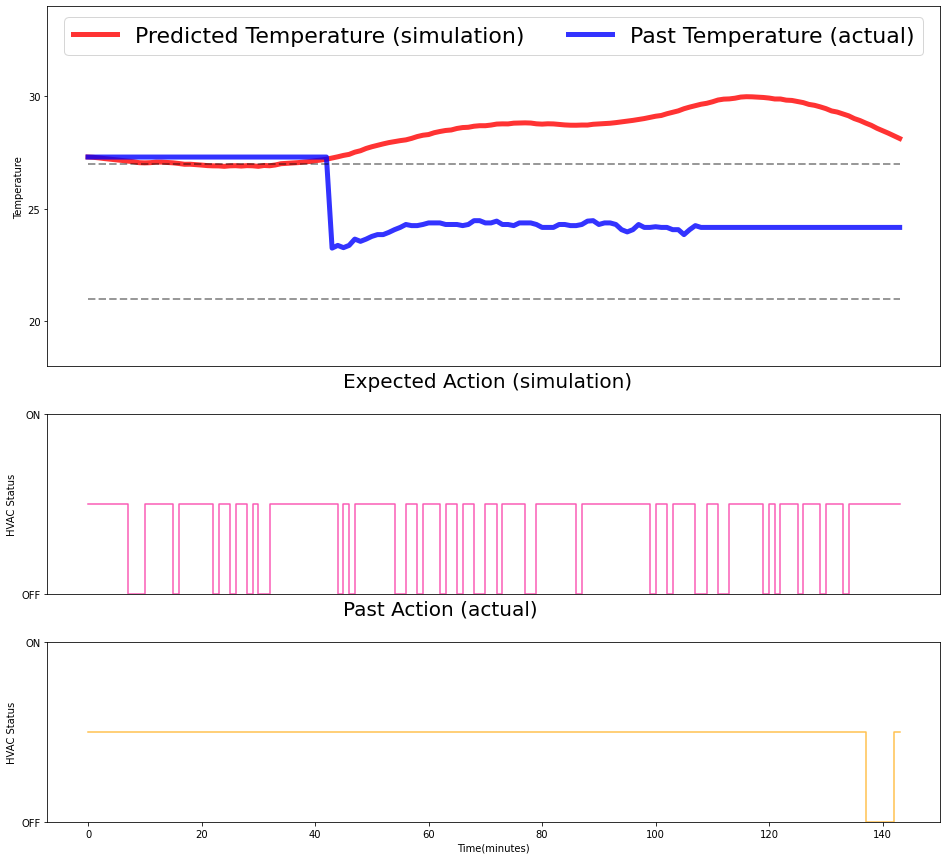

139.0
111
1 일 평균 절감율 :  20.14388489208633 실제 평균 온도 :  25.0945138888889 학습 평균 온도 :  28.3248522366105 오차율 :  -3.230338347721599


In [42]:
real_df, next_df, actions, result_df = result_base_RL([df_test_pre], Train_date, path, max_action, trainer_dqn)
new_df = pd.DataFrame()
new_df.index = real_df.index
new_df['real_temp'] = real_df['temp']
new_df['real_hum'] = real_df['hum']
new_df['real_action'] = real_df['action']
new_df['RL_temp'] = next_df['f3_temp']
new_df['RL_hum'] = next_df['f3_hum']
new_df['RL_action'] = actions
result_final_df = pd.DataFrame()

new_df.to_csv(f'/raid/deallab/yechae/ECM/2023/result/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y-%m-%d")}-DoubleDQN-pre.csv')
result_final_df = result_final_df.append(result_df)
result_final_df.to_csv("/raid/deallab/yechae/ECM/2023/result/DoubleDQN-pre.csv")

In [32]:
# select_env = "ECMEnv2023-v0"
# register_env(select_env, lambda config: ECM_Env_ML(env_config))

# config_dqn = agents.dqn.DEFAULT_CONFIG.copy()
# config_dqn["log_level"] = "WARN"
# config_dqn["env"] = select_env
# config_dqn["env_config"] = env_config
# config_dqn["evaluation_num_workers"] = 1
# config_dqn["train_batch_size"] = 256
# # config_dqn["model.fcnet_activation"] = 'relu'
# config_dqn["target_network_update_freq"] = 50
# config_dqn["learning_starts"] = 100
# config_dqn["timesteps_per_iteration"] = 6
# config_dqn["num_gpus_per_worker"] = 1
# config_dqn["model"]["custom_model"] = False
# #config_dqn["model"]["custom_model"] = "my_model"
# config_dqn["model"]["fcnet_hiddens"] = [256,256]
# config_dqn["model"]["fcnet_activation"] = "relu"
# config_dqn["n_step"] = 6
# config_dqn["dueling"] = False
# config_dqn["double_q"] = False

In [38]:
checkpoint

'/raid/deallab/yechae/ECM/2023/result/2019-09-20/RL_ECM_DQN_linear_regression_2023-01-27_11-26-30j73v05ac/checkpoint_000100/checkpoint-100'

In [ ]:
w21_linear_regression

In [37]:
select_env = "ECMEnv2023-v0"
register_env(select_env, lambda config: ECM_Env_ML(env_config))

config_dqn = agents.dqn.DEFAULT_CONFIG.copy()
config_dqn["log_level"] = "WARN"
config_dqn["env"] = select_env
config_dqn["env_config"] = env_config
config_dqn["evaluation_num_workers"] = 1
config_dqn["train_batch_size"] = 256
# config_dqn["model.fcnet_activation"] = 'relu'
config_dqn["target_network_update_freq"] = 50
config_dqn["learning_starts"] = 100
config_dqn["timesteps_per_iteration"] = 6
config_dqn["num_gpus_per_worker"] = 1
config_dqn["model"]["custom_model"] = False
#config_dqn["model"]["custom_model"] = "my_model"
config_dqn["model"]["fcnet_hiddens"] = [256,256]
config_dqn["model"]["fcnet_activation"] = "relu"
config_dqn["n_step"] = 6
config_dqn["dueling"] = False
config_dqn["double_q"] = True

2023-02-02 03:36:14,372	INFO trainer.py:2141 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also then want to set eager_tracing=True in order to reach similar execution speed as with static-graph mode.
2023-02-02 03:36:14,376	WARNING trainer.py:2348 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.
2023-02-02 03:36:14,377	INFO simple_q.py:155 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting `simple_optimizer=True` if this doesn't work for you.
2023-02-02 03:36:14,377	INFO trainer.py:781 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


/raid/deallab/yechae/ECM/2023/result/2019-10-14/RL_ECM_DoubleDQN_2023-02-02_03-27-41dg41ijg_/checkpoint_005100/checkpoint-5100
/raid/deallab/ecm/model_result/2019-10-15/20191015w14_linear_regression.joblib
Reset data f3_temp : 23.57
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75


2023-02-02 03:36:19,568	WARNING deprecation.py:46 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
2023-02-02 03:36:19,569	WARNING trainer.py:2348 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.


Instructions for updating:
Prefer Variable.assign which has equivalent behavior in 2.X.


2023-02-02 03:36:19,894	INFO trainable.py:496 -- Restored on 192.168.0.40 from checkpoint: /raid/deallab/yechae/ECM/2023/result/2019-10-14/RL_ECM_DoubleDQN_2023-02-02_03-27-41dg41ijg_/checkpoint_005100/checkpoint-5100
2023-02-02 03:36:19,895	INFO trainable.py:503 -- Current state after restoring: {'_iteration': 5100, '_timesteps_total': 1305600, '_time_total': 5709.430261135101, '_episodes_total': 23494}


100
start_after_for :  0.00011277198791503906
Reset data f3_temp : 23.45
Reset data f3_temp : 23.45
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 23.45
Reset data f3_temp : 22.75
Reset data f3_temp : 23.37
Reset data f3_temp : 22.75
Reset data f3_temp : 23.55
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 23.45
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 23.45


2023-02-02 03:36:21,822	WARNING deprecation.py:46 -- DeprecationWarning: `clear_buffer` has been deprecated. Use `Filter.reset_buffer()` instead. This will raise an error in the future!


  1 reward min :  12.48/ mean :  14.85/ max :  15.00/ len   6.00
checkpoint saved at /raid/deallab/yechae/ECM/2023/result/2019-10-15/RL_ECM_DoubleDQN_2023-02-02_03-36-14wr2ld2j_/checkpoint_005101/checkpoint-5101
Elapsed time one episode :  2.0074551105499268
start_after_for :  1.430511474609375e-06
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 23.45
(RolloutWorker pid=19616) Reset data f3_temp : 23.45
(RolloutWorker pid=19616) Reset data f3_temp : 23.45
  2 reward min : -15.00/ mean :  12.16/ max :  15.00/ len   6.00
Elapsed time one episode :  0.9578030109405518
start_after_for :  1.430511474609375e-06


(RolloutWorker pid=19616) /home/deallab/anaconda3/envs/daewoong/lib/python3.7/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=19616)   warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 23.55
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 23.45
Reset data f3_temp : 23.45
  3 reward min : -15.00/ mean :   8.12/ max :  15.00/ len   6.00
Elapsed time one episode :  0.971771240234375
start_after_for :  2.384185791015625e-06
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 22.77
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 23.45
Reset data f3_temp : 22.75
Reset data f3_temp : 23.55
Reset data f3_temp : 22.75
  4 reward min : -15.00/ mean :   5.72/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0071938037872314
start_after_for :  1.430511474609375e-06
Reset data f3_temp : 22.65
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 23.45
Reset data f3_temp :

Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
 24 reward min : -10.02/ mean :   5.87/ max :  14.98/ len   6.00
Elapsed time one episode :  1.0497016906738281
start_after_for :  1.430511474609375e-06
Reset data f3_temp : 22.75
Reset data f3_temp : 22.55
Reset data f3_temp : 23.45
Reset data f3_temp : 22.55
Reset data f3_temp : 23.37
Reset data f3_temp : 23.37
Reset data f3_temp : 23.45
Reset data f3_temp : 22.75
Reset data f3_temp : 23.5
 25 reward min : -10.02/ mean :   5.90/ max :  14.96/ len   6.00
Elapsed time one episode :  1.0639703273773193
start_after_for :  2.1457672119140625e-06
Reset data f3_temp : 23.45
Reset data f3_temp : 23.55
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 22.65
Reset data f3_temp : 22.75
 26 reward min : -10.02/ mean :   5.70/ max :  14.96/ len   6.00
Elapsed time one episode :  1.0374040603637695
start_after_for :  1.6689300537109375e-06
Reset data f3_temp : 22.75


Reset data f3_temp : 22.65
Reset data f3_temp : 22.75
Reset data f3_temp : 23.45
Reset data f3_temp : 22.75
Reset data f3_temp : 23.55
Reset data f3_temp : 22.75
Reset data f3_temp : 23.37
 44 reward min : -10.02/ mean :   7.25/ max :  14.98/ len   6.00
Elapsed time one episode :  1.0367114543914795
start_after_for :  2.1457672119140625e-06
Reset data f3_temp : 23.45
Reset data f3_temp : 22.75
Reset data f3_temp : 22.65
Reset data f3_temp : 22.65
Reset data f3_temp : 23.45
Reset data f3_temp : 23.55
Reset data f3_temp : 23.55
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
 45 reward min :  -5.04/ mean :   7.15/ max :  14.98/ len   6.00
Elapsed time one episode :  1.0145561695098877
start_after_for :  1.1920928955078125e-06
Reset data f3_temp : 22.75
Reset data f3_temp : 23.45
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_tem

 63 reward min :  -5.04/ mean :   7.47/ max :  14.98/ len   6.00
Elapsed time one episode :  1.1460742950439453
start_after_for :  6.9141387939453125e-06
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 23.05
Reset data f3_temp : 23.05
Reset data f3_temp : 22.75
Reset data f3_temp : 23.37
Reset data f3_temp : 23.37
Reset data f3_temp : 23.37
Reset data f3_temp : 23.57
 64 reward min :  -5.04/ mean :   7.32/ max :  14.98/ len   6.00
Elapsed time one episode :  1.027038812637329
start_after_for :  1.9073486328125e-06
Reset data f3_temp : 22.65
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 23.55
Reset data f3_temp : 22.75
 65 reward min :  -5.04/ mean :   7.75/ max :  14.98/ len   6.00
Elapsed time one episode :  1.0552141666412354
start_after_for :  1.430511474609375e-06
Res

Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 22.65
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
 83 reward min :  -5.04/ mean :   8.22/ max :  12.46/ len   6.00
Elapsed time one episode :  1.002105712890625
start_after_for :  1.9073486328125e-06
Reset data f3_temp : 22.55
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 23.45
Reset data f3_temp : 22.75
Reset data f3_temp : 23.55
Reset data f3_temp : 23.57
Reset data f3_temp : 23.55
Reset data f3_temp : 22.75
 84 reward min :  -5.04/ mean :   8.07/ max :  12.46/ len   6.00
Elapsed time one episode :  1.0655498504638672
start_after_for :  1.6689300537109375e-06
Reset data f3_temp : 23.45
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 

2023-02-02 03:38:06,414	WARNING deprecation.py:46 -- DeprecationWarning: `compute_action` has been deprecated. Use `Trainer.compute_single_action()` instead. This will raise an error in the future!


checkpoint saved at /raid/deallab/yechae/ECM/2023/result/2019-10-15/RL_ECM_DoubleDQN_2023-02-02_03-36-14wr2ld2j_/checkpoint_005200/checkpoint-5200
F_SET_MODE_3
Reset data f3_temp : 23.45
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0]
2019-10-15 실제 데이터 길이 :  144  : real action :  97.0 , expected action :  10 실제 평균 온도 :  22.925277777777783 학습 평균 온도 :  23.908603857991586


<Figure size 432x288 with 0 Axes>

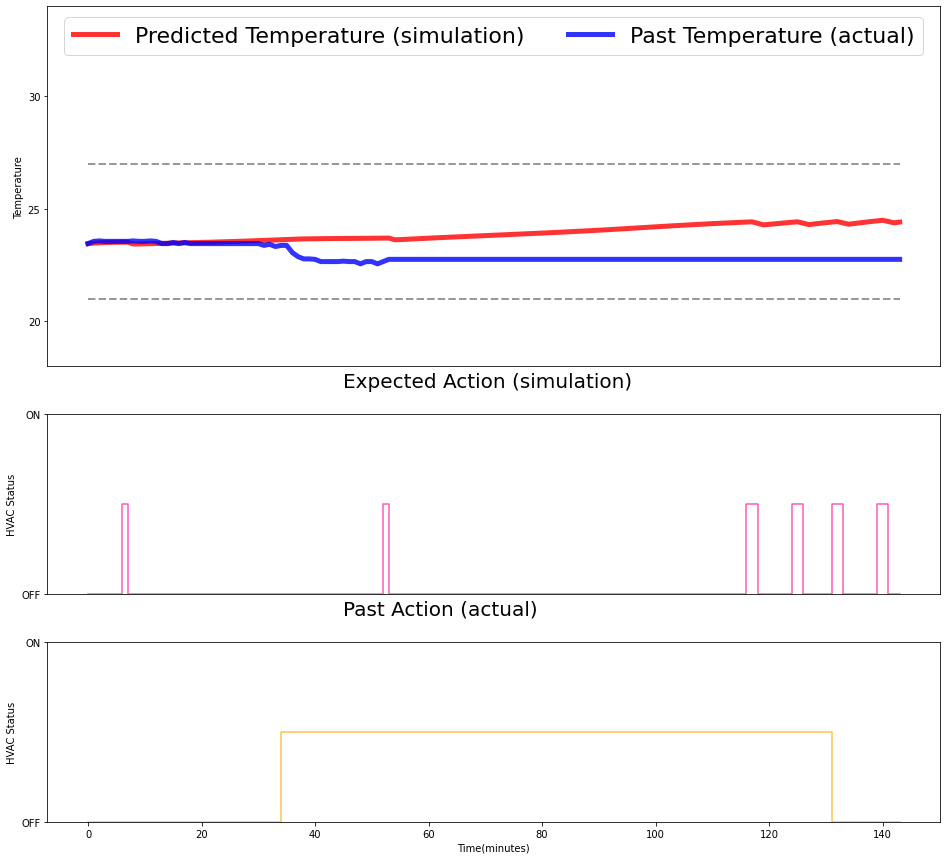

2023-02-02 03:38:08,391	WARNING trainer.py:2348 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.


97.0
10
1 일 평균 절감율 :  89.69072164948454 실제 평균 온도 :  22.925277777777783 학습 평균 온도 :  23.908603857991586 오차율 :  -0.9833260802138035
/raid/deallab/ecm/model_result/2019-10-16/20191016w30_linear_regression.joblib
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75


2023-02-02 03:38:09,649	WARNING deprecation.py:46 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
2023-02-02 03:38:09,651	WARNING trainer.py:2348 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.
2023-02-02 03:38:09,912	INFO trainable.py:496 -- Restored on 192.168.0.40 from checkpoint: /raid/deallab/yechae/ECM/2023/result/2019-10-15/RL_ECM_DoubleDQN_2023-02-02_03-36-14wr2ld2j_/checkpoint_005200/checkpoint-5200
2023-02-02 03:38:09,914	INFO trainable.py:503 -- Current state after restoring: {'_iteration': 5200, '_timesteps_total': 1331200, '_time_total': 5810.710748434067, '_episodes_total': 24460}


100
start_after_for :  0.00014019012451171875
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 25.22
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 25.02
Reset data f3_temp : 24.9
Reset data f3_temp : 24.62
Reset data f3_temp : 25.22
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 24.82
Reset data f3_temp : 24.62
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
  1 reward min :   7.44/ mean :  13.22/ max :  15.00/ len   6.00
checkpoint saved at /raid/deallab/yechae/ECM/2023/result/2019-10-16/RL_ECM_DoubleDQN_2023-02-02_03-38-08_u3rgudo/checkpoint_005201/checkpoint-5201
Elapsed time one episode :  1.4243786334991455
start_after_for :  2.2649765014648438e-05
Reset data f3_temp : 25.02
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 25.12
Reset data f3_temp : 22.75
Reset 

(RolloutWorker pid=19556) /home/deallab/anaconda3/envs/daewoong/lib/python3.7/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=19556)   warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


Reset data f3_temp : 24.6
Reset data f3_temp : 24.9
Reset data f3_temp : 22.75
Reset data f3_temp : 25.25
Reset data f3_temp : 22.75
  6 reward min : -10.02/ mean :   9.97/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0039350986480713
start_after_for :  1.430511474609375e-06
Reset data f3_temp : 24.9
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 25.25
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
  7 reward min : -15.00/ mean :   7.14/ max :  15.00/ len   6.00
Elapsed time one episode :  1.1250150203704834
start_after_for :  1.0728836059570312e-05
Reset data f3_temp : 25.22
Reset data f3_temp : 22.75
Reset data f3_temp : 25.25
Reset data f3_temp : 24.82
Reset data f3_temp : 25.12
Reset data f3_temp : 22.75
Reset data f3_temp : 24.6
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
  8 reward min : -15.00/ mean :   4.84/ max :  15.00/ len   6.00
Elapsed tim

Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 24.62
Reset data f3_temp : 22.75
Reset data f3_temp : 25.22
Reset data f3_temp : 25.22
 27 reward min : -10.02/ mean :   6.55/ max :  15.00/ len   6.00
Elapsed time one episode :  1.1794397830963135
start_after_for :  1.6689300537109375e-06
Reset data f3_temp : 22.75
Reset data f3_temp : 25.22
Reset data f3_temp : 25.12
Reset data f3_temp : 22.75
Reset data f3_temp : 24.55
Reset data f3_temp : 25.22
Reset data f3_temp : 22.75
Reset data f3_temp : 25.02
 28 reward min : -10.02/ mean :   5.93/ max :  15.00/ len   6.00
Elapsed time one episode :  0.9580724239349365
start_after_for :  2.384185791015625e-06
Reset data f3_temp : 22.75
Reset data f3_temp : 24.95
Reset data f3_temp : 22.75
Reset data f3_temp : 24.95
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 25.22
Reset data f3_temp : 22.75
Reset data f3_temp : 25.22
 29 reward min : -10.02/ mean :   5.10/ max :  15.00/ len   6.00
Elapsed

Reset data f3_temp : 22.75
Reset data f3_temp : 24.95
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 25.22
Reset data f3_temp : 24.62
Reset data f3_temp : 24.9
 49 reward min :  -2.56/ mean :   8.27/ max :  14.94/ len   6.00
Elapsed time one episode :  0.9980530738830566
start_after_for :  1.430511474609375e-06
Reset data f3_temp : 22.75
Reset data f3_temp : 24.6
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 25.12
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
 50 reward min :  -2.56/ mean :   8.62/ max :  14.94/ len   6.00
Elapsed time one episode :  1.009401798248291
start_after_for :  1.9073486328125e-06
Reset data f3_temp : 24.9
Reset data f3_temp : 22.75
Reset data f3_temp : 25.22
Reset data f3_temp : 25.12
Reset data f3_temp : 22.75
Reset data f3_temp : 24.95
Reset data f3_temp : 24.9
Reset data f3_temp : 25.25
Reset data f3_temp : 24.82

Reset data f3_temp : 24.9
Reset data f3_temp : 25.12
Reset data f3_temp : 22.75
Reset data f3_temp : 25.22
 72 reward min : -10.02/ mean :   5.53/ max :  14.98/ len   6.00
Elapsed time one episode :  1.012216567993164
start_after_for :  1.430511474609375e-06
Reset data f3_temp : 25.12
Reset data f3_temp : 22.75
Reset data f3_temp : 24.9
Reset data f3_temp : 25.25
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
 73 reward min : -10.02/ mean :   5.35/ max :  14.98/ len   6.00
Elapsed time one episode :  1.0266144275665283
start_after_for :  2.1457672119140625e-06
Reset data f3_temp : 24.9
Reset data f3_temp : 22.75
Reset data f3_temp : 24.55
Reset data f3_temp : 24.95
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
 74 reward min : -10.02/ mean :   5.63/ max :  14.98/ len   6.00
Elapsed time one episode :  1.1025745868682861
start_after_for :  2.1457672119140625e-06
Reset data f3_temp : 24.55
Res

Reset data f3_temp : 25.22
Reset data f3_temp : 24.9
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
 94 reward min : -10.02/ mean :   5.85/ max :  14.96/ len   6.00
Elapsed time one episode :  1.0106005668640137
start_after_for :  1.6689300537109375e-06
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 24.62
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 25.12
Reset data f3_temp : 24.9
Reset data f3_temp : 25.22
Reset data f3_temp : 22.75
 95 reward min : -10.02/ mean :   5.85/ max :  14.96/ len   6.00
Elapsed time one episode :  1.0193617343902588
start_after_for :  2.384185791015625e-06
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 24.72
Reset data f3_temp : 22.75
Reset data f3_temp : 22.75
Reset data f3_temp : 25.22
Reset data f3_temp : 25.22
Reset data f3_temp :

<Figure size 432x288 with 0 Axes>

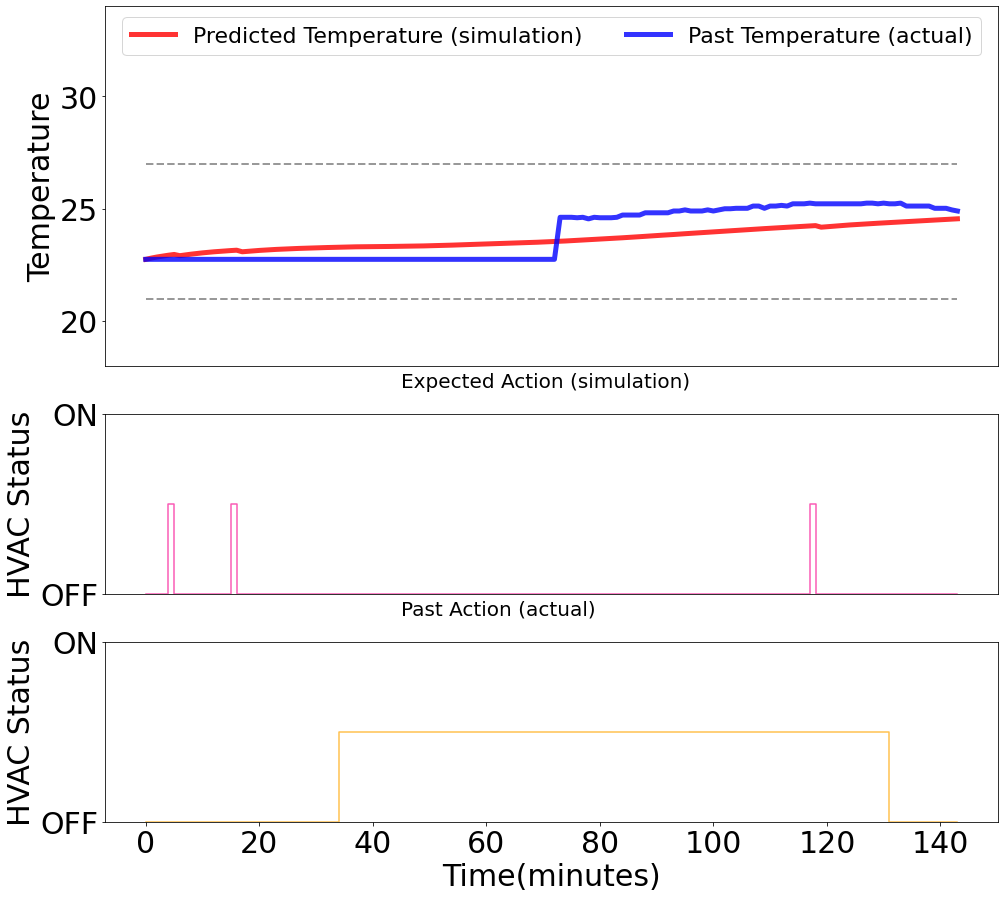

97.0
3
1 일 평균 절감율 :  96.90721649484536 실제 평균 온도 :  23.85097222222219 학습 평균 온도 :  23.655254412806762 오차율 :  0.19571780941542727
/raid/deallab/ecm/model_result/2019-10-17/20191017w7_linear_regression.joblib
Reset data f3_temp : 25.52


2023-02-02 03:39:58,589	WARNING trainer.py:2348 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.


Reset data f3_temp : 25.35
Reset data f3_temp : 25.02


2023-02-02 03:39:59,905	WARNING deprecation.py:46 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
2023-02-02 03:39:59,906	WARNING trainer.py:2348 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.
2023-02-02 03:40:00,155	INFO trainable.py:496 -- Restored on 192.168.0.40 from checkpoint: /raid/deallab/yechae/ECM/2023/result/2019-10-16/RL_ECM_DoubleDQN_2023-02-02_03-38-08_u3rgudo/checkpoint_005300/checkpoint-5300
2023-02-02 03:40:00,156	INFO trainable.py:503 -- Current state after restoring: {'_iteration': 5300, '_timesteps_total': 1356800, '_time_total': 5911.113339424133, '_episodes_total': 25308}


100
start_after_for :  5.936622619628906e-05
Reset data f3_temp : 25.25
Reset data f3_temp : 25.92
Reset data f3_temp : 25.02
Reset data f3_temp : 25.52
Reset data f3_temp : 24.9
Reset data f3_temp : 25.42
Reset data f3_temp : 25.82
Reset data f3_temp : 25.02
Reset data f3_temp : 25.55
Reset data f3_temp : 24.9
Reset data f3_temp : 24.9
Reset data f3_temp : 25.92
Reset data f3_temp : 24.9
Reset data f3_temp : 25.02
Reset data f3_temp : 25.12
Reset data f3_temp : 24.9
Reset data f3_temp : 25.22
Reset data f3_temp : 24.95
  1 reward min : -15.00/ mean :   9.55/ max :  15.00/ len   6.00
checkpoint saved at /raid/deallab/yechae/ECM/2023/result/2019-10-17/RL_ECM_DoubleDQN_2023-02-02_03-39-580wudqj99/checkpoint_005301/checkpoint-5301
Elapsed time one episode :  1.750168800354004
start_after_for :  1.9550323486328125e-05
Reset data f3_temp : 25.82
Reset data f3_temp : 24.9
Reset data f3_temp : 25.22
Reset data f3_temp : 25.22
Reset data f3_temp : 24.9
Reset data f3_temp : 25.02
Reset data f3_

2023-02-02 03:40:11,609	WARNING worker.py:1326 -- The actor or task with ID ffffffffffffffff79670b83e60a4234cecf8a9701000000 cannot be scheduled right now. You can ignore this message if this Ray cluster is expected to auto-scale or if you specified a runtime_env for this actor or task, which may take time to install.  Otherwise, this is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increasing the resources available to this Ray cluster.
Required resources for this actor or task: {CPU: 1.000000}, {GPU: 1.000000}
Available resources on this node: {39.000000/40.000000 CPU, 98.620785 GiB/98.620785 GiB memory, 0.000000/1.000000 GPU, 46.257433 GiB/46.257433 GiB object_store_memory, 1.000000/1.000000 node:192.168.0.40, 1.000000/1.000000 accelerator_type:V100}
 In total there are 0 pending tasks and 1 pending actors on this node.


Reset data f3_temp : 25.02
 10 reward min : -15.12/ mean :  11.78/ max :  15.00/ len   6.00
Elapsed time one episode :  1.3040733337402344
start_after_for :  4.291534423828125e-06
Reset data f3_temp : 25.12
Reset data f3_temp : 25.22
Reset data f3_temp : 25.65
Reset data f3_temp : 24.95
Reset data f3_temp : 25.42
 11 reward min : -15.12/ mean :  11.95/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0599851608276367
start_after_for :  4.291534423828125e-06
Reset data f3_temp : 25.35
Reset data f3_temp : 25.42
Reset data f3_temp : 25.25
Reset data f3_temp : 25.12
Reset data f3_temp : 25.82
Reset data f3_temp : 25.92
Reset data f3_temp : 25.02
Reset data f3_temp : 25.3
 12 reward min : -15.12/ mean :  12.84/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0423650741577148
start_after_for :  1.1920928955078125e-06
Reset data f3_temp : 24.9
Reset data f3_temp : 25.02
Reset data f3_temp : 24.95
Reset data f3_temp : 24.9
Reset data f3_temp : 24.9
Reset data f3_temp : 25.52
Rese

(RolloutWorker pid=19463) /home/deallab/anaconda3/envs/daewoong/lib/python3.7/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=19463)   warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


Reset data f3_temp : 25.82
Reset data f3_temp : 25.12
Reset data f3_temp : 25.02
Reset data f3_temp : 25.02
Reset data f3_temp : 25.82
Reset data f3_temp : 25.82
Reset data f3_temp : 24.9
Reset data f3_temp : 25.95
 14 reward min : -15.12/ mean :  12.97/ max :  15.00/ len   6.00
Elapsed time one episode :  1.016709566116333
start_after_for :  1.6689300537109375e-06
Reset data f3_temp : 25.02
Reset data f3_temp : 25.95
Reset data f3_temp : 25.42
Reset data f3_temp : 25.02
Reset data f3_temp : 25.95
Reset data f3_temp : 25.92
Reset data f3_temp : 24.95
Reset data f3_temp : 25.15
 15 reward min : -15.12/ mean :  13.14/ max :  15.00/ len   6.00
Elapsed time one episode :  1.2913486957550049
start_after_for :  2.6226043701171875e-06
Reset data f3_temp : 25.92
Reset data f3_temp : 25.25
Reset data f3_temp : 25.42
Reset data f3_temp : 25.12
Reset data f3_temp : 25.22
Reset data f3_temp : 25.02
Reset data f3_temp : 25.02
Reset data f3_temp : 25.12
 16 reward min :  -5.08/ mean :  14.45/ max : 

Reset data f3_temp : 25.12
Reset data f3_temp : 25.82
Reset data f3_temp : 25.12
Reset data f3_temp : 25.65
Reset data f3_temp : 25.92
Reset data f3_temp : 25.02
Reset data f3_temp : 25.12
 36 reward min :   9.98/ mean :  14.65/ max :  15.00/ len   6.00
Elapsed time one episode :  1.263688564300537
start_after_for :  7.867813110351562e-06
Reset data f3_temp : 25.15
Reset data f3_temp : 25.52
Reset data f3_temp : 25.22
Reset data f3_temp : 24.95
Reset data f3_temp : 25.42
Reset data f3_temp : 25.42
Reset data f3_temp : 25.12
Reset data f3_temp : 25.52
 37 reward min :   9.98/ mean :  14.62/ max :  15.00/ len   6.00
Elapsed time one episode :  0.9874989986419678
start_after_for :  4.291534423828125e-06
Reset data f3_temp : 25.12
Reset data f3_temp : 25.02
Reset data f3_temp : 25.52
Reset data f3_temp : 25.02
Reset data f3_temp : 25.02
Reset data f3_temp : 25.92
Reset data f3_temp : 25.02
Reset data f3_temp : 25.82
 38 reward min :   9.98/ mean :  14.60/ max :  15.00/ len   6.00
Elapsed t

Reset data f3_temp : 24.9
Reset data f3_temp : 25.92
Reset data f3_temp : 24.95
Reset data f3_temp : 24.95
Reset data f3_temp : 25.02
Reset data f3_temp : 25.82
 58 reward min :   9.98/ mean :  14.90/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0684988498687744
start_after_for :  4.5299530029296875e-06
Reset data f3_temp : 25.82
Reset data f3_temp : 24.95
Reset data f3_temp : 25.92
Reset data f3_temp : 25.12
Reset data f3_temp : 25.02
Reset data f3_temp : 25.92
Reset data f3_temp : 24.95
Reset data f3_temp : 25.52
Reset data f3_temp : 25.12
 59 reward min :  12.48/ mean :  14.95/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0679001808166504
start_after_for :  4.5299530029296875e-06
Reset data f3_temp : 25.62
Reset data f3_temp : 25.25
Reset data f3_temp : 25.22
Reset data f3_temp : 24.95
Reset data f3_temp : 25.92
Reset data f3_temp : 24.95
Reset data f3_temp : 24.9
Reset data f3_temp : 25.52
 60 reward min :  12.48/ mean :  14.97/ max :  15.00/ len   6.00
Elapsed 

Reset data f3_temp : 25.52
Reset data f3_temp : 25.02
 79 reward min :   9.98/ mean :  14.67/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0651402473449707
start_after_for :  1.430511474609375e-06
Reset data f3_temp : 25.12
Reset data f3_temp : 25.12
Reset data f3_temp : 24.9
Reset data f3_temp : 24.95
Reset data f3_temp : 24.9
Reset data f3_temp : 25.95
Reset data f3_temp : 24.95
Reset data f3_temp : 24.97
 80 reward min :   9.98/ mean :  14.70/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0335032939910889
start_after_for :  1.430511474609375e-06
Reset data f3_temp : 25.02
Reset data f3_temp : 25.25
Reset data f3_temp : 25.82
Reset data f3_temp : 24.95
Reset data f3_temp : 25.22
Reset data f3_temp : 24.9
Reset data f3_temp : 25.22
Reset data f3_temp : 24.9
 81 reward min :   9.98/ mean :  14.70/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0553836822509766
start_after_for :  2.1457672119140625e-06
Reset data f3_temp : 25.12
Reset data f3_temp : 25.02
Rese

<Figure size 432x288 with 0 Axes>

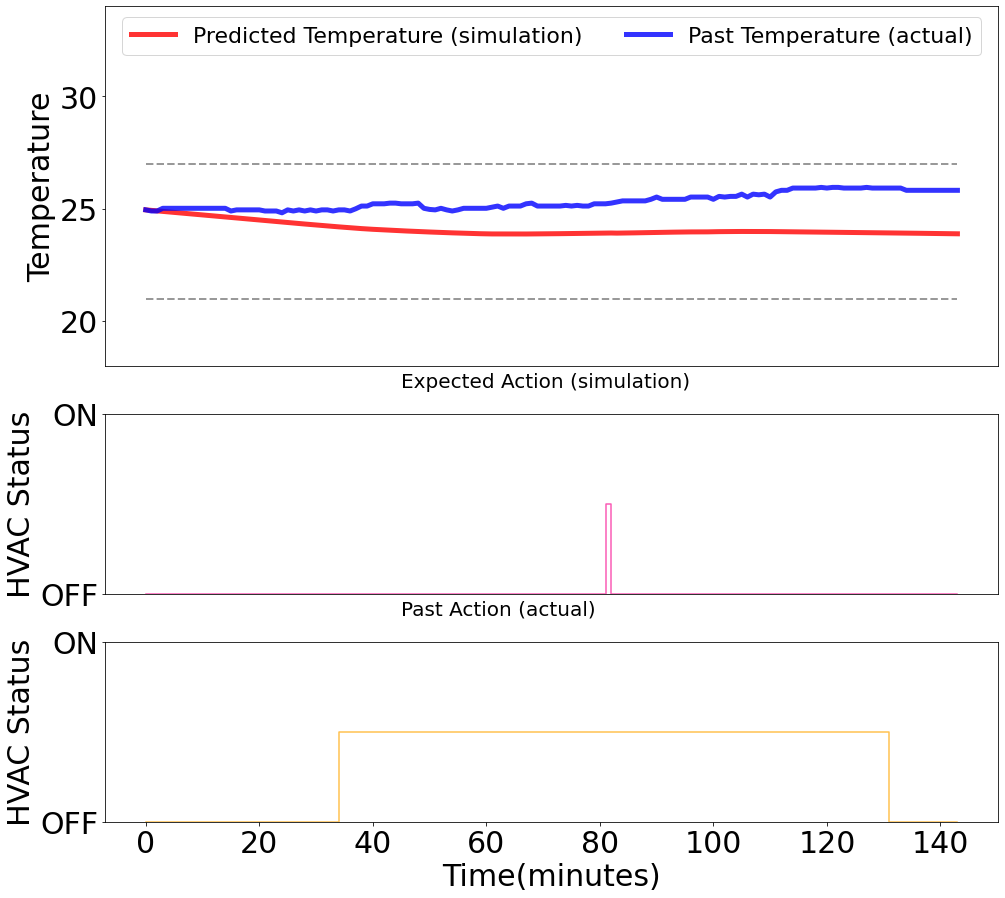

2023-02-02 03:41:51,741	WARNING trainer.py:2348 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.


97.0
1
1 일 평균 절감율 :  98.96907216494846 실제 평균 온도 :  25.320625000000017 학습 평균 온도 :  24.100746818023524 오차율 :  1.219878181976494
/raid/deallab/ecm/model_result/2019-10-18/20191018w30_linear_regression.joblib
Reset data f3_temp : 25.95
Reset data f3_temp : 25.42
Reset data f3_temp : 25.82


2023-02-02 03:41:53,568	WARNING deprecation.py:46 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
2023-02-02 03:41:53,571	WARNING trainer.py:2348 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.
2023-02-02 03:41:54,126	INFO trainable.py:496 -- Restored on 192.168.0.40 from checkpoint: /raid/deallab/yechae/ECM/2023/result/2019-10-17/RL_ECM_DoubleDQN_2023-02-02_03-39-580wudqj99/checkpoint_005400/checkpoint-5400
2023-02-02 03:41:54,203	INFO trainable.py:503 -- Current state after restoring: {'_iteration': 5400, '_timesteps_total': 1382400, '_time_total': 6013.542037010193, '_episodes_total': 26125}


100
start_after_for :  0.00014829635620117188
Reset data f3_temp : 24.42
Reset data f3_temp : 24.22
Reset data f3_temp : 24.42
Reset data f3_temp : 25.42
Reset data f3_temp : 25.95
Reset data f3_temp : 24.22
Reset data f3_temp : 25.82
Reset data f3_temp : 25.82
Reset data f3_temp : 26.15
Reset data f3_temp : 24.32
Reset data f3_temp : 24.22
Reset data f3_temp : 24.22
Reset data f3_temp : 26.25
Reset data f3_temp : 25.65
Reset data f3_temp : 25.92
Reset data f3_temp : 25.22
Reset data f3_temp : 25.82
Reset data f3_temp : 25.35
  1 reward min : -15.00/ mean : -14.12/ max : -10.02/ len   6.00
checkpoint saved at /raid/deallab/yechae/ECM/2023/result/2019-10-18/RL_ECM_DoubleDQN_2023-02-02_03-41-510oeu_vlf/checkpoint_005401/checkpoint-5401
Elapsed time one episode :  2.181802749633789
start_after_for :  5.0067901611328125e-06
Reset data f3_temp : 25.92
Reset data f3_temp : 24.22
Reset data f3_temp : 26.15
Reset data f3_temp : 24.32
Reset data f3_temp : 25.12
  2 reward min : -15.00/ mean : -

2023-02-02 03:42:11,611	WARNING worker.py:1326 -- The actor or task with ID ffffffffffffffff1dd16408744a04be0d235f4801000000 cannot be scheduled right now. You can ignore this message if this Ray cluster is expected to auto-scale or if you specified a runtime_env for this actor or task, which may take time to install.  Otherwise, this is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increasing the resources available to this Ray cluster.
Required resources for this actor or task: {GPU: 1.000000}, {CPU: 1.000000}
Available resources on this node: {39.000000/40.000000 CPU, 98.620785 GiB/98.620785 GiB memory, 0.000000/1.000000 GPU, 46.257433 GiB/46.257433 GiB object_store_memory, 1.000000/1.000000 node:192.168.0.40, 1.000000/1.000000 accelerator_type:V100}
 In total there are 0 pending tasks and 1 pending actors on this node.


Reset data f3_temp : 25.82
Reset data f3_temp : 25.0
Reset data f3_temp : 26.05
 16 reward min : -15.00/ mean :   8.75/ max :  14.88/ len   6.00
Elapsed time one episode :  1.1172215938568115
start_after_for :  5.0067901611328125e-06
Reset data f3_temp : 25.82
Reset data f3_temp : 25.82
Reset data f3_temp : 25.92
Reset data f3_temp : 24.72
Reset data f3_temp : 26.15
Reset data f3_temp : 24.32
Reset data f3_temp : 25.82
 17 reward min : -15.00/ mean :  10.70/ max :  14.88/ len   6.00
Elapsed time one episode :  1.0239250659942627
start_after_for :  4.0531158447265625e-06
Reset data f3_temp : 25.92
Reset data f3_temp : 25.3
Reset data f3_temp : 24.82
Reset data f3_temp : 25.95
Reset data f3_temp : 25.92
Reset data f3_temp : 26.05
Reset data f3_temp : 24.22
 18 reward min : -15.00/ mean :  12.79/ max :  14.88/ len   6.00
Elapsed time one episode :  1.0708551406860352
start_after_for :  5.4836273193359375e-06
Reset data f3_temp : 26.05
Reset data f3_temp : 25.82
Reset data f3_temp : 24.22


(RolloutWorker pid=19610) /home/deallab/anaconda3/envs/daewoong/lib/python3.7/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=19610)   warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


Reset data f3_temp : 25.52
Reset data f3_temp : 25.87
Reset data f3_temp : 25.82
 19 reward min : -15.00/ mean :  14.33/ max :  14.88/ len   6.00
Elapsed time one episode :  1.1713230609893799
start_after_for :  3.337860107421875e-06
Reset data f3_temp : 25.82
Reset data f3_temp : 24.42
Reset data f3_temp : 25.92
Reset data f3_temp : 25.87
Reset data f3_temp : 25.12
Reset data f3_temp : 24.95
Reset data f3_temp : 25.35
 20 reward min :   9.90/ mean :  14.58/ max :  14.88/ len   6.00
Elapsed time one episode :  1.4165761470794678
start_after_for :  6.198883056640625e-06
Reset data f3_temp : 25.82
Reset data f3_temp : 25.12
Reset data f3_temp : 25.95
Reset data f3_temp : 24.7
Reset data f3_temp : 25.82
Reset data f3_temp : 25.87
 21 reward min :   9.90/ mean :  14.63/ max :  14.88/ len   6.00
Elapsed time one episode :  0.9485244750976562
start_after_for :  5.245208740234375e-06
Reset data f3_temp : 25.02
Reset data f3_temp : 25.3
Reset data f3_temp : 24.22
Reset data f3_temp : 24.22
Res

 43 reward min :   4.92/ mean :  14.53/ max :  14.88/ len   6.00
Elapsed time one episode :  1.1672072410583496
start_after_for :  6.198883056640625e-06
Reset data f3_temp : 24.5
Reset data f3_temp : 25.95
Reset data f3_temp : 25.0
Reset data f3_temp : 24.32
Reset data f3_temp : 25.95
Reset data f3_temp : 25.92
Reset data f3_temp : 24.9
 44 reward min :   4.92/ mean :  14.43/ max :  14.88/ len   6.00
Elapsed time one episode :  1.2868375778198242
start_after_for :  5.245208740234375e-06
Reset data f3_temp : 24.5
Reset data f3_temp : 25.95
Reset data f3_temp : 24.42
Reset data f3_temp : 26.05
Reset data f3_temp : 25.95
Reset data f3_temp : 25.3
Reset data f3_temp : 25.65
 45 reward min :   9.90/ mean :  14.53/ max :  14.88/ len   6.00
Elapsed time one episode :  1.0295474529266357
start_after_for :  8.821487426757812e-06
Reset data f3_temp : 25.92
Reset data f3_temp : 25.92
Reset data f3_temp : 25.92
Reset data f3_temp : 25.92
Reset data f3_temp : 25.82
Reset data f3_temp : 25.52
Reset 

Reset data f3_temp : 25.62
Reset data f3_temp : 24.22
 67 reward min :   9.90/ mean :  14.58/ max :  14.88/ len   6.00
Elapsed time one episode :  1.0810704231262207
start_after_for :  3.5762786865234375e-06
Reset data f3_temp : 25.95
Reset data f3_temp : 25.82
Reset data f3_temp : 24.5
Reset data f3_temp : 24.22
Reset data f3_temp : 24.42
Reset data f3_temp : 24.35
Reset data f3_temp : 25.65
Reset data f3_temp : 25.92
 68 reward min :   9.90/ mean :  14.58/ max :  14.88/ len   6.00
Elapsed time one episode :  1.3929407596588135
start_after_for :  7.152557373046875e-06
Reset data f3_temp : 25.92
Reset data f3_temp : 25.92
Reset data f3_temp : 25.92
Reset data f3_temp : 24.32
Reset data f3_temp : 25.92
Reset data f3_temp : 24.95
Reset data f3_temp : 25.92
 69 reward min :   9.90/ mean :  14.63/ max :  14.88/ len   6.00
Elapsed time one episode :  1.0231964588165283
start_after_for :  3.814697265625e-06
Reset data f3_temp : 26.15
Reset data f3_temp : 25.82
Reset data f3_temp : 25.35
Rese

 91 reward min :   9.90/ mean :  14.53/ max :  14.88/ len   6.00
Elapsed time one episode :  1.0240814685821533
start_after_for :  4.291534423828125e-06
Reset data f3_temp : 25.87
Reset data f3_temp : 25.92
Reset data f3_temp : 24.82
Reset data f3_temp : 25.95
Reset data f3_temp : 25.92
Reset data f3_temp : 25.95
Reset data f3_temp : 24.35
 92 reward min :   9.90/ mean :  14.58/ max :  14.88/ len   6.00
Elapsed time one episode :  1.0319364070892334
start_after_for :  4.0531158447265625e-06
Reset data f3_temp : 24.22
Reset data f3_temp : 25.12
Reset data f3_temp : 26.05
Reset data f3_temp : 25.92
Reset data f3_temp : 24.82
Reset data f3_temp : 24.5
Reset data f3_temp : 25.02
 93 reward min :   9.90/ mean :  14.53/ max :  14.88/ len   6.00
Elapsed time one episode :  1.3195030689239502
start_after_for :  2.3126602172851562e-05
Reset data f3_temp : 26.05
Reset data f3_temp : 25.65
Reset data f3_temp : 24.35
Reset data f3_temp : 24.35
Reset data f3_temp : 25.82
Reset data f3_temp : 25.02


<Figure size 432x288 with 0 Axes>

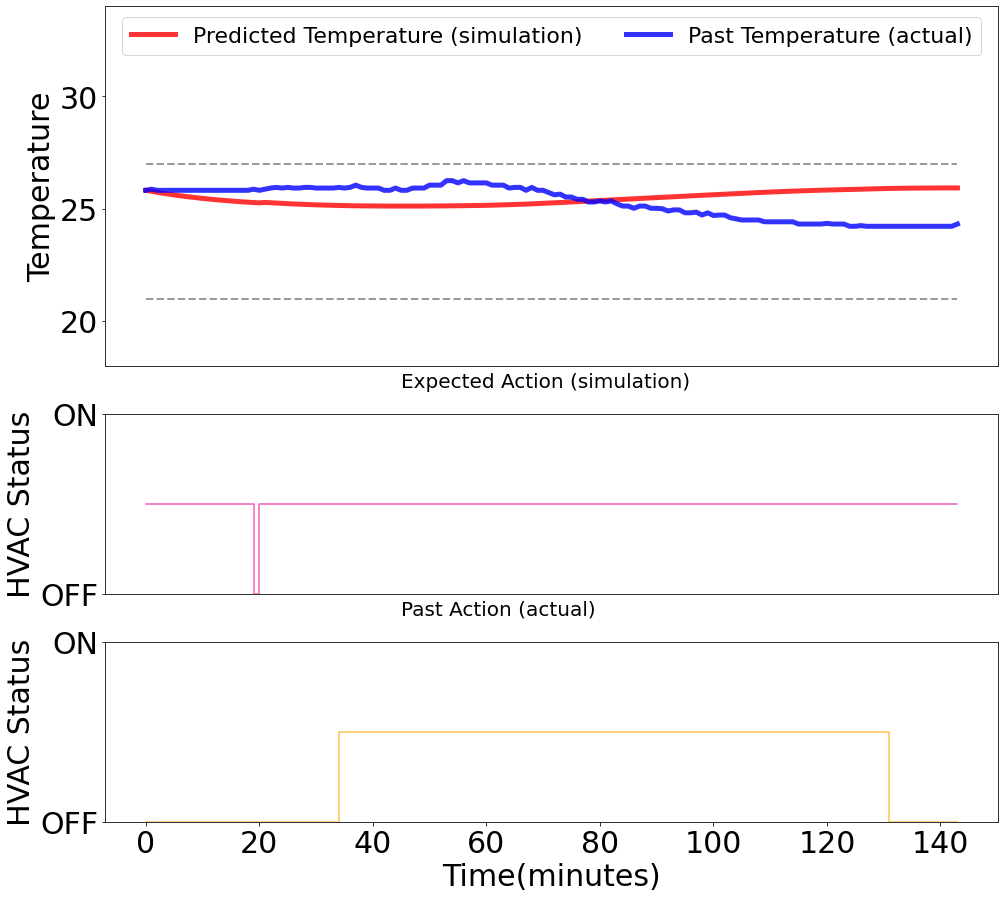

2023-02-02 03:43:45,873	WARNING trainer.py:2348 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.


97.0
143
1 일 평균 절감율 :  -47.42268041237113 실제 평균 온도 :  25.29326388888887 학습 평균 온도 :  25.465725643812327 오차율 :  -0.17246175492345728
/raid/deallab/ecm/model_result/2019-10-19/20191019w7_linear_regression.joblib
Reset data f3_temp : 24.62
Reset data f3_temp : 24.22
Reset data f3_temp : 24.02


2023-02-02 03:43:47,765	WARNING deprecation.py:46 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
2023-02-02 03:43:47,767	WARNING trainer.py:2348 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.
2023-02-02 03:43:48,369	INFO trainable.py:496 -- Restored on 192.168.0.40 from checkpoint: /raid/deallab/yechae/ECM/2023/result/2019-10-18/RL_ECM_DoubleDQN_2023-02-02_03-41-510oeu_vlf/checkpoint_005500/checkpoint-5500
2023-02-02 03:43:48,373	INFO trainable.py:503 -- Current state after restoring: {'_iteration': 5500, '_timesteps_total': 1408000, '_time_total': 6115.145648956299, '_episodes_total': 26823}


100
start_after_for :  0.0001442432403564453
Reset data f3_temp : 23.7
Reset data f3_temp : 23.82
Reset data f3_temp : 24.42
Reset data f3_temp : 24.02
Reset data f3_temp : 24.02
Reset data f3_temp : 24.05
Reset data f3_temp : 24.02
Reset data f3_temp : 23.7
Reset data f3_temp : 24.5
Reset data f3_temp : 24.02
Reset data f3_temp : 24.62
Reset data f3_temp : 24.15
Reset data f3_temp : 24.62
Reset data f3_temp : 24.22
Reset data f3_temp : 23.7
Reset data f3_temp : 24.35
Reset data f3_temp : 23.92
Reset data f3_temp : 24.5
  1 reward min :  -0.12/ mean :  -0.12/ max :  -0.12/ len   6.00
checkpoint saved at /raid/deallab/yechae/ECM/2023/result/2019-10-19/RL_ECM_DoubleDQN_2023-02-02_03-43-45qyt6wg14/checkpoint_005501/checkpoint-5501
Elapsed time one episode :  2.0289113521575928
start_after_for :  1.1920928955078125e-06
Reset data f3_temp : 24.42
Reset data f3_temp : 24.5
Reset data f3_temp : 24.5
Reset data f3_temp : 24.72
Reset data f3_temp : 24.42
  2 reward min :  -0.12/ mean :  -0.12/ 

2023-02-02 03:44:01,627	WARNING worker.py:1326 -- The actor or task with ID ffffffffffffffffaf0b13d68078ab92a6ed4e1d01000000 cannot be scheduled right now. You can ignore this message if this Ray cluster is expected to auto-scale or if you specified a runtime_env for this actor or task, which may take time to install.  Otherwise, this is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increasing the resources available to this Ray cluster.
Required resources for this actor or task: {GPU: 1.000000}, {CPU: 1.000000}
Available resources on this node: {39.000000/40.000000 CPU, 98.620785 GiB/98.620785 GiB memory, 0.000000/1.000000 GPU, 46.257433 GiB/46.257433 GiB object_store_memory, 1.000000/1.000000 node:192.168.0.40, 1.000000/1.000000 accelerator_type:V100}
 In total there are 0 pending tasks and 1 pending actors on this node.


Reset data f3_temp : 24.35
Reset data f3_temp : 24.02
 12 reward min :  -0.12/ mean :   9.15/ max :  15.00/ len   6.00
Elapsed time one episode :  1.4381260871887207
start_after_for :  1.33514404296875e-05
Reset data f3_temp : 24.32
Reset data f3_temp : 24.5
Reset data f3_temp : 24.32
Reset data f3_temp : 23.72
Reset data f3_temp : 24.02
Reset data f3_temp : 23.82
 13 reward min :  -0.12/ mean :   9.38/ max :  15.00/ len   6.00
Elapsed time one episode :  0.9546940326690674
start_after_for :  5.7220458984375e-06
Reset data f3_temp : 24.62
Reset data f3_temp : 24.15
Reset data f3_temp : 24.55
Reset data f3_temp : 24.35
Reset data f3_temp : 24.62
Reset data f3_temp : 24.62
 14 reward min :  -0.12/ mean :   9.83/ max :  15.00/ len   6.00
Elapsed time one episode :  0.99167799949646
start_after_for :  5.4836273193359375e-06
Reset data f3_temp : 24.55
Reset data f3_temp : 24.02
Reset data f3_temp : 24.55
(RolloutWorker pid=19468) Reset data f3_temp : 23.7
(RolloutWorker pid=19468) Reset dat

(RolloutWorker pid=19468) /home/deallab/anaconda3/envs/daewoong/lib/python3.7/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=19468)   warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


Reset data f3_temp : 24.35
Reset data f3_temp : 24.02
Reset data f3_temp : 24.55
 15 reward min :  -0.12/ mean :  10.74/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0935416221618652
start_after_for :  4.76837158203125e-06
Reset data f3_temp : 24.02
Reset data f3_temp : 24.62
Reset data f3_temp : 23.92
Reset data f3_temp : 24.55
Reset data f3_temp : 23.82
Reset data f3_temp : 24.35
 16 reward min :  -0.12/ mean :  11.57/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0518333911895752
start_after_for :  1.1920928955078125e-06
Reset data f3_temp : 24.22
Reset data f3_temp : 24.02
Reset data f3_temp : 24.15
Reset data f3_temp : 24.32
Reset data f3_temp : 24.22
Reset data f3_temp : 23.7
 17 reward min :  -0.12/ mean :  12.30/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0447072982788086
start_after_for :  1.9073486328125e-06
Reset data f3_temp : 24.72
Reset data f3_temp : 24.62
Reset data f3_temp : 23.82
Reset data f3_temp : 24.5
Reset data f3_temp : 24.72
Reset

Reset data f3_temp : 24.02
 43 reward min :  -0.06/ mean :  12.91/ max :  15.00/ len   6.00
Elapsed time one episode :  1.5004873275756836
start_after_for :  7.3909759521484375e-06
Reset data f3_temp : 24.32
Reset data f3_temp : 24.1
Reset data f3_temp : 24.72
Reset data f3_temp : 24.02
 44 reward min :  -0.06/ mean :  12.88/ max :  15.00/ len   6.00
Elapsed time one episode :  0.832442045211792
start_after_for :  2.1457672119140625e-06
Reset data f3_temp : 24.5
Reset data f3_temp : 24.22
Reset data f3_temp : 24.55
Reset data f3_temp : 24.15
 45 reward min :  -0.06/ mean :  12.94/ max :  15.00/ len   6.00
Elapsed time one episode :  1.024643898010254
start_after_for :  1.6689300537109375e-06
Reset data f3_temp : 24.5
Reset data f3_temp : 24.42
Reset data f3_temp : 24.02
Reset data f3_temp : 23.92
Reset data f3_temp : 24.15
 46 reward min :   2.40/ mean :  13.14/ max :  15.00/ len   6.00
Elapsed time one episode :  1.5396080017089844
start_after_for :  3.981590270996094e-05
Reset data f

Reset data f3_temp : 24.42
Reset data f3_temp : 24.42
Reset data f3_temp : 24.72
Reset data f3_temp : 24.15
Reset data f3_temp : 24.02
Reset data f3_temp : 24.02
Reset data f3_temp : 24.62
 70 reward min :   4.96/ mean :  13.31/ max :  15.00/ len   6.00
Elapsed time one episode :  1.042050838470459
start_after_for :  1.6689300537109375e-06
Reset data f3_temp : 24.05
Reset data f3_temp : 24.02
Reset data f3_temp : 24.62
Reset data f3_temp : 24.02
Reset data f3_temp : 24.1
Reset data f3_temp : 24.02
Reset data f3_temp : 24.22
Reset data f3_temp : 24.02
 71 reward min :   4.96/ mean :  13.41/ max :  15.00/ len   6.00
Elapsed time one episode :  1.342909336090088
start_after_for :  1.1920928955078125e-06
Reset data f3_temp : 24.15
Reset data f3_temp : 24.62
Reset data f3_temp : 24.35
Reset data f3_temp : 24.15
Reset data f3_temp : 24.15
Reset data f3_temp : 24.62
 72 reward min :   4.96/ mean :  13.52/ max :  15.00/ len   6.00
Elapsed time one episode :  1.1644558906555176
start_after_for 

Reset data f3_temp : 24.45
Reset data f3_temp : 23.82
 95 reward min :   7.44/ mean :  14.62/ max :  15.00/ len   6.00
Elapsed time one episode :  0.9736795425415039
start_after_for :  2.6226043701171875e-06
Reset data f3_temp : 24.02
Reset data f3_temp : 24.02
Reset data f3_temp : 24.15
Reset data f3_temp : 24.35
Reset data f3_temp : 23.92
Reset data f3_temp : 23.7
Reset data f3_temp : 24.02
 96 reward min :   7.44/ mean :  14.62/ max :  15.00/ len   6.00
Elapsed time one episode :  1.064887285232544
start_after_for :  1.9073486328125e-06
Reset data f3_temp : 24.72
Reset data f3_temp : 24.62
Reset data f3_temp : 24.02
Reset data f3_temp : 24.72
Reset data f3_temp : 24.35
Reset data f3_temp : 24.22
Reset data f3_temp : 23.92
 97 reward min :   9.96/ mean :  14.72/ max :  15.00/ len   6.00
Elapsed time one episode :  1.084136724472046
start_after_for :  2.1457672119140625e-06
Reset data f3_temp : 23.82
Reset data f3_temp : 24.62
Reset data f3_temp : 24.5
Reset data f3_temp : 24.32
Reset

<Figure size 432x288 with 0 Axes>

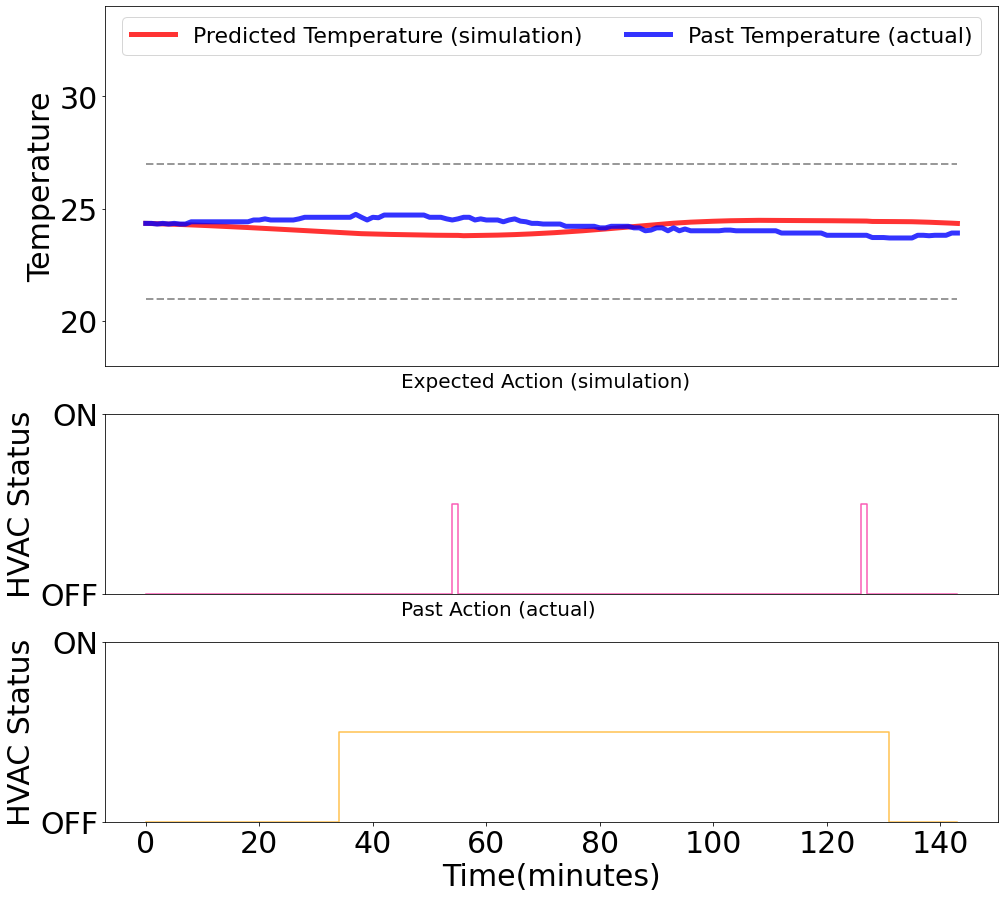

2023-02-02 03:45:44,875	WARNING trainer.py:2348 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.


97.0
2
1 일 평균 절감율 :  97.9381443298969 실제 평균 온도 :  24.250416666666677 학습 평균 온도 :  24.17706512788792 오차율 :  0.07335153877875555
/raid/deallab/ecm/model_result/2019-10-20/20191020w1_linear_regression.joblib
Reset data f3_temp : 24.32
Reset data f3_temp : 23.7
Reset data f3_temp : 23.82


2023-02-02 03:45:46,867	WARNING deprecation.py:46 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
2023-02-02 03:45:46,869	WARNING trainer.py:2348 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.
2023-02-02 03:45:47,525	INFO trainable.py:496 -- Restored on 192.168.0.40 from checkpoint: /raid/deallab/yechae/ECM/2023/result/2019-10-19/RL_ECM_DoubleDQN_2023-02-02_03-43-45qyt6wg14/checkpoint_005600/checkpoint-5600
2023-02-02 03:45:47,528	INFO trainable.py:503 -- Current state after restoring: {'_iteration': 5600, '_timesteps_total': 1433600, '_time_total': 6217.870980024338, '_episodes_total': 27429}


100
start_after_for :  0.000141143798828125
Reset data f3_temp : 24.05
Reset data f3_temp : 24.32
Reset data f3_temp : 24.32
Reset data f3_temp : 24.32
Reset data f3_temp : 24.02
Reset data f3_temp : 24.1
Reset data f3_temp : 24.22
Reset data f3_temp : 24.32
Reset data f3_temp : 24.02
Reset data f3_temp : 23.92
Reset data f3_temp : 24.02
Reset data f3_temp : 23.92
Reset data f3_temp : 23.82
Reset data f3_temp : 24.22
Reset data f3_temp : 23.72
Reset data f3_temp : 24.05
Reset data f3_temp : 23.82
Reset data f3_temp : 24.22
  1 reward min :  12.48/ mean :  14.70/ max :  15.00/ len   6.00
checkpoint saved at /raid/deallab/yechae/ECM/2023/result/2019-10-20/RL_ECM_DoubleDQN_2023-02-02_03-45-44wakurwjl/checkpoint_005601/checkpoint-5601
Elapsed time one episode :  2.17352294921875
start_after_for :  5.7220458984375e-06
Reset data f3_temp : 23.72
Reset data f3_temp : 23.7
Reset data f3_temp : 23.7
Reset data f3_temp : 24.02
Reset data f3_temp : 24.32
  2 reward min :   2.40/ mean :  13.51/ ma

2023-02-02 03:46:02,024	WARNING worker.py:1326 -- The actor or task with ID ffffffffffffffff072d71fa519a4e5e7c0a698201000000 cannot be scheduled right now. You can ignore this message if this Ray cluster is expected to auto-scale or if you specified a runtime_env for this actor or task, which may take time to install.  Otherwise, this is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increasing the resources available to this Ray cluster.
Required resources for this actor or task: {CPU: 1.000000}, {GPU: 1.000000}
Available resources on this node: {39.000000/40.000000 CPU, 98.620785 GiB/98.620785 GiB memory, 0.000000/1.000000 GPU, 46.257433 GiB/46.257433 GiB object_store_memory, 1.000000/1.000000 node:192.168.0.40, 1.000000/1.000000 accelerator_type:V100}
 In total there are 0 pending tasks and 1 pending actors on this node.


Reset data f3_temp : 24.32
 12 reward min : -15.00/ mean :  13.07/ max :  15.00/ len   6.00
Elapsed time one episode :  1.617760181427002
start_after_for :  1.9073486328125e-06
Reset data f3_temp : 23.82
Reset data f3_temp : 24.22
Reset data f3_temp : 23.7
Reset data f3_temp : 24.02
Reset data f3_temp : 24.02
Reset data f3_temp : 24.05
 13 reward min : -15.00/ mean :  12.85/ max :  15.00/ len   6.00
Elapsed time one episode :  1.088460922241211
start_after_for :  1.430511474609375e-06
Reset data f3_temp : 24.05
Reset data f3_temp : 24.05
Reset data f3_temp : 24.02
Reset data f3_temp : 24.32
Reset data f3_temp : 24.22
 14 reward min : -15.00/ mean :  12.24/ max :  15.00/ len   6.00
Elapsed time one episode :  1.272261619567871
start_after_for :  6.67572021484375e-06
(RolloutWorker pid=19535) Reset data f3_temp : 24.05
(RolloutWorker pid=19535) Reset data f3_temp : 24.32
Reset data f3_temp : 24.02


(RolloutWorker pid=19535) /home/deallab/anaconda3/envs/daewoong/lib/python3.7/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=19535)   warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


Reset data f3_temp : 24.02
Reset data f3_temp : 24.22
Reset data f3_temp : 24.02
Reset data f3_temp : 24.32
 15 reward min : -15.00/ mean :  12.39/ max :  15.00/ len   6.00
Elapsed time one episode :  1.040797472000122
start_after_for :  4.5299530029296875e-05
Reset data f3_temp : 24.05
Reset data f3_temp : 24.02
Reset data f3_temp : 24.32
Reset data f3_temp : 24.32
 16 reward min : -15.00/ mean :  12.50/ max :  15.00/ len   6.00
Elapsed time one episode :  0.9598546028137207
start_after_for :  9.059906005859375e-06
Reset data f3_temp : 24.1
Reset data f3_temp : 23.92
Reset data f3_temp : 24.22
Reset data f3_temp : 23.92
 17 reward min : -15.00/ mean :  12.55/ max :  15.00/ len   6.00
Elapsed time one episode :  1.189964771270752
start_after_for :  7.3909759521484375e-06
Reset data f3_temp : 24.15
Reset data f3_temp : 24.15
Reset data f3_temp : 24.15
Reset data f3_temp : 24.22
Reset data f3_temp : 24.22
 18 reward min : -15.00/ mean :  12.52/ max :  15.00/ len   6.00
Elapsed time one e

Reset data f3_temp : 23.82
Reset data f3_temp : 24.22
 43 reward min : -15.00/ mean :  13.47/ max :  15.00/ len   6.00
Elapsed time one episode :  1.1536481380462646
start_after_for :  7.152557373046875e-07
Reset data f3_temp : 23.72
Reset data f3_temp : 24.02
Reset data f3_temp : 24.22
Reset data f3_temp : 24.05
Reset data f3_temp : 24.22
 44 reward min : -15.00/ mean :  13.42/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0000102519989014
start_after_for :  2.1457672119140625e-06
Reset data f3_temp : 23.82
Reset data f3_temp : 24.02
Reset data f3_temp : 24.22
Reset data f3_temp : 24.02
Reset data f3_temp : 23.95
Reset data f3_temp : 23.72
 45 reward min : -15.00/ mean :  13.39/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0739355087280273
start_after_for :  1.6689300537109375e-06
Reset data f3_temp : 24.22
Reset data f3_temp : 24.1
Reset data f3_temp : 24.22
Reset data f3_temp : 23.82
Reset data f3_temp : 24.32
Reset data f3_temp : 24.22
 46 reward min : -15.00/ me

Reset data f3_temp : 24.05
Reset data f3_temp : 24.15
Reset data f3_temp : 24.05
 75 reward min :  -5.00/ mean :  13.69/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0262036323547363
start_after_for :  1.6689300537109375e-06
Reset data f3_temp : 23.82
Reset data f3_temp : 24.35
Reset data f3_temp : 23.72
 76 reward min :  -5.00/ mean :  13.79/ max :  15.00/ len   6.00
Elapsed time one episode :  1.2018663883209229
start_after_for :  6.9141387939453125e-06
Reset data f3_temp : 24.05
Reset data f3_temp : 23.92
Reset data f3_temp : 24.15
 77 reward min :  -5.00/ mean :  13.74/ max :  15.00/ len   6.00
Elapsed time one episode :  1.2095167636871338
start_after_for :  1.430511474609375e-06
Reset data f3_temp : 23.7
Reset data f3_temp : 24.15
Reset data f3_temp : 24.15
Reset data f3_temp : 24.05
 78 reward min :  -5.00/ mean :  13.74/ max :  15.00/ len   6.00
Elapsed time one episode :  1.033238172531128
start_after_for :  5.0067901611328125e-06
Reset data f3_temp : 24.02
Reset dat

<Figure size 432x288 with 0 Axes>

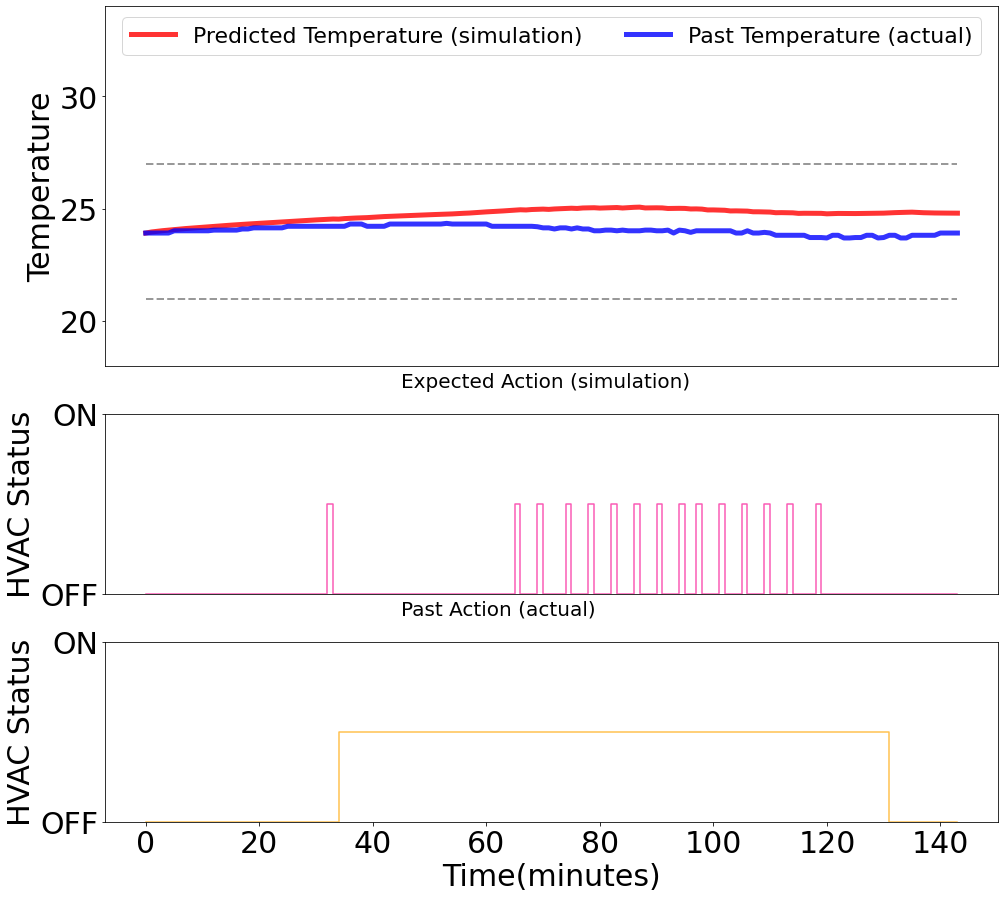

2023-02-02 03:47:47,560	WARNING trainer.py:2348 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.


97.0
15
1 일 평균 절감율 :  84.5360824742268 실제 평균 온도 :  24.05208333333334 학습 평균 온도 :  24.72176796785801 오차율 :  -0.6696846345246712
/raid/deallab/ecm/model_result/2019-10-21/20191021w14_linear_regression.joblib
Reset data f3_temp : 24.05
Reset data f3_temp : 23.92
Reset data f3_temp : 24.22


2023-02-02 03:47:49,632	WARNING deprecation.py:46 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
2023-02-02 03:47:49,634	WARNING trainer.py:2348 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.
2023-02-02 03:47:50,345	INFO trainable.py:496 -- Restored on 192.168.0.40 from checkpoint: /raid/deallab/yechae/ECM/2023/result/2019-10-20/RL_ECM_DoubleDQN_2023-02-02_03-45-44wakurwjl/checkpoint_005700/checkpoint-5700
2023-02-02 03:47:50,348	INFO trainable.py:503 -- Current state after restoring: {'_iteration': 5700, '_timesteps_total': 1459200, '_time_total': 6320.720687866211, '_episodes_total': 27913}


100
start_after_for :  0.0005834102630615234
Reset data f3_temp : 23.92
Reset data f3_temp : 23.92
Reset data f3_temp : 24.15
Reset data f3_temp : 24.05
Reset data f3_temp : 24.15
Reset data f3_temp : 24.22
Reset data f3_temp : 24.22
Reset data f3_temp : 24.05
Reset data f3_temp : 24.02
Reset data f3_temp : 24.22
Reset data f3_temp : 23.92
Reset data f3_temp : 24.02
Reset data f3_temp : 24.02
Reset data f3_temp : 24.02
Reset data f3_temp : 23.92
Reset data f3_temp : 24.22
Reset data f3_temp : 24.02
Reset data f3_temp : 24.05
  1 reward min :   9.96/ mean :  14.41/ max :  15.00/ len   6.00
(scheduler +12m6s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
checkpoint saved at /raid/deallab/yechae/ECM/2023/result/2019-10-21/RL_ECM_DoubleDQN_2023-02-02_03-47-47x20v3uy9/checkpoint_005701/checkpoint-5701

2023-02-02 03:48:01,637	WARNING worker.py:1326 -- The actor or task with ID ffffffffffffffff8ba53bbed3774bb329ae2d9f01000000 cannot be scheduled right now. You can ignore this message if this Ray cluster is expected to auto-scale or if you specified a runtime_env for this actor or task, which may take time to install.  Otherwise, this is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increasing the resources available to this Ray cluster.
Required resources for this actor or task: {GPU: 1.000000}, {CPU: 1.000000}
Available resources on this node: {39.000000/40.000000 CPU, 98.620785 GiB/98.620785 GiB memory, 0.000000/1.000000 GPU, 46.257433 GiB/46.257433 GiB object_store_memory, 1.000000/1.000000 node:192.168.0.40, 1.000000/1.000000 accelerator_type:V100}
 In total there are 0 pending tasks and 1 pending actors on this node.


  8 reward min : -15.00/ mean :   3.88/ max :  15.00/ len   6.00
Elapsed time one episode :  1.1293818950653076
start_after_for :  1.6689300537109375e-06
Reset data f3_temp : 24.15
Reset data f3_temp : 24.1
  9 reward min : -15.00/ mean :   3.82/ max :  15.00/ len   6.00
Elapsed time one episode :  1.2958834171295166
start_after_for :  1.430511474609375e-06
Reset data f3_temp : 24.02
Reset data f3_temp : 23.92
Reset data f3_temp : 24.15
Reset data f3_temp : 24.02
Reset data f3_temp : 23.82
 10 reward min : -15.00/ mean :   4.01/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0564026832580566
start_after_for :  5.0067901611328125e-06
Reset data f3_temp : 24.02
Reset data f3_temp : 24.22
Reset data f3_temp : 23.92
Reset data f3_temp : 24.22
Reset data f3_temp : 24.22
(RolloutWorker pid=19454) Reset data f3_temp : 23.92
(RolloutWorker pid=19454) Reset data f3_temp : 23.92
 11 reward min : -15.00/ mean :   4.72/ max :  15.00/ len   6.00
Elapsed time one episode :  1.052633285522461

(RolloutWorker pid=19454) /home/deallab/anaconda3/envs/daewoong/lib/python3.7/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=19454)   warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


Reset data f3_temp : 23.92
Reset data f3_temp : 24.1
Reset data f3_temp : 24.15
Reset data f3_temp : 24.15
Reset data f3_temp : 24.15
 12 reward min : -15.00/ mean :   5.16/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0738418102264404
start_after_for :  1.1920928955078125e-06
Reset data f3_temp : 24.22
Reset data f3_temp : 24.02
Reset data f3_temp : 24.05
Reset data f3_temp : 23.92
Reset data f3_temp : 24.02
 13 reward min : -15.00/ mean :   5.65/ max :  15.00/ len   6.00
Elapsed time one episode :  1.1719696521759033
start_after_for :  7.62939453125e-06
Reset data f3_temp : 24.02
Reset data f3_temp : 24.15
Reset data f3_temp : 24.15
Reset data f3_temp : 24.05
 14 reward min : -15.00/ mean :   5.88/ max :  15.00/ len   6.00
Elapsed time one episode :  1.1005182266235352
start_after_for :  6.4373016357421875e-06
Reset data f3_temp : 24.15
Reset data f3_temp : 24.05
Reset data f3_temp : 24.05
Reset data f3_temp : 24.15
 15 reward min : -15.00/ mean :   6.06/ max :  15.00/ len 

Reset data f3_temp : 24.15
 43 reward min : -10.02/ mean :   9.94/ max :  15.00/ len   6.00
Elapsed time one episode :  1.355759620666504
start_after_for :  1.9073486328125e-06
Reset data f3_temp : 23.82
Reset data f3_temp : 24.1
Reset data f3_temp : 24.15
Reset data f3_temp : 24.32
 44 reward min : -10.02/ mean :   9.92/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0053672790527344
start_after_for :  1.1920928955078125e-06
Reset data f3_temp : 24.15
Reset data f3_temp : 24.32
Reset data f3_temp : 24.22
Reset data f3_temp : 24.05
 45 reward min : -10.02/ mean :   9.97/ max :  15.00/ len   6.00
Elapsed time one episode :  1.104562520980835
start_after_for :  8.58306884765625e-06
Reset data f3_temp : 24.05
Reset data f3_temp : 24.22
Reset data f3_temp : 24.02
Reset data f3_temp : 24.1
 46 reward min : -10.02/ mean :   9.84/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0240445137023926
start_after_for :  5.7220458984375e-06
Reset data f3_temp : 24.15
Reset data f3_temp

Reset data f3_temp : 23.92
Reset data f3_temp : 24.15
 76 reward min : -15.00/ mean :   6.99/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0169644355773926
start_after_for :  5.7220458984375e-06
Reset data f3_temp : 24.15
Reset data f3_temp : 23.92
Reset data f3_temp : 24.15
Reset data f3_temp : 24.15
Reset data f3_temp : 24.05
 77 reward min : -15.00/ mean :   6.79/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0823633670806885
start_after_for :  1.6689300537109375e-06
Reset data f3_temp : 24.32
Reset data f3_temp : 24.15
Reset data f3_temp : 24.15
Reset data f3_temp : 24.22
 78 reward min : -15.00/ mean :   6.77/ max :  15.00/ len   6.00
Elapsed time one episode :  1.128103256225586
start_after_for :  1.430511474609375e-06
Reset data f3_temp : 24.02
Reset data f3_temp : 24.22
Reset data f3_temp : 24.05
Reset data f3_temp : 24.15
 79 reward min : -15.00/ mean :   6.42/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0548968315124512
start_after_for :  4.76837

<Figure size 432x288 with 0 Axes>

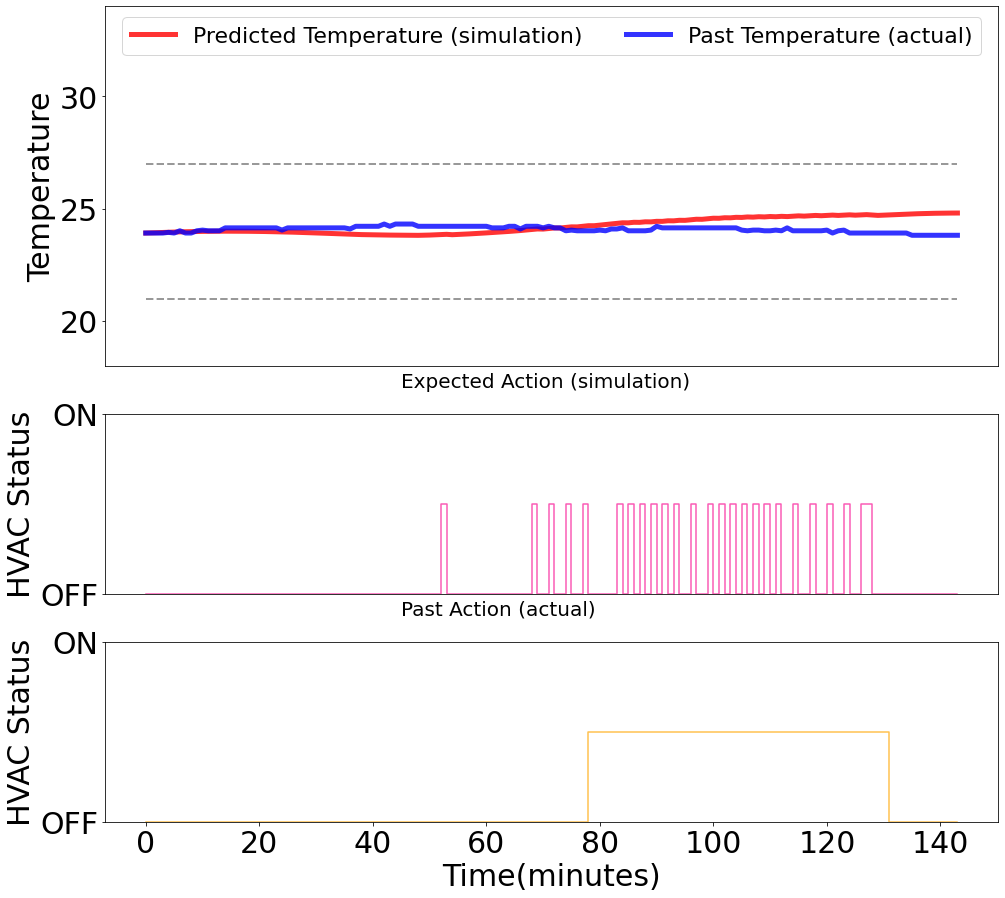

2023-02-02 03:49:52,230	WARNING trainer.py:2348 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.


53.0
25
1 일 평균 절감율 :  52.83018867924528 실제 평균 온도 :  24.083680555555585 학습 평균 온도 :  24.251168734735607 오차율 :  -0.16748817918002246
/raid/deallab/ecm/model_result/2019-10-22/20191022w7_linear_regression.joblib
Reset data f3_temp : 23.52
Reset data f3_temp : 23.52
Reset data f3_temp : 23.52


2023-02-02 03:49:55,963	WARNING deprecation.py:46 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
2023-02-02 03:49:55,966	WARNING trainer.py:2348 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.
2023-02-02 03:49:56,372	INFO trainable.py:496 -- Restored on 192.168.0.40 from checkpoint: /raid/deallab/yechae/ECM/2023/result/2019-10-21/RL_ECM_DoubleDQN_2023-02-02_03-47-47x20v3uy9/checkpoint_005800/checkpoint-5800
2023-02-02 03:49:56,374	INFO trainable.py:503 -- Current state after restoring: {'_iteration': 5800, '_timesteps_total': 1484800, '_time_total': 6423.476629018784, '_episodes_total': 28321}


100
start_after_for :  7.2479248046875e-05
Reset data f3_temp : 23.82
Reset data f3_temp : 23.52
Reset data f3_temp : 23.52
Reset data f3_temp : 23.52
Reset data f3_temp : 23.52
Reset data f3_temp : 23.52
Reset data f3_temp : 23.42
Reset data f3_temp : 23.52
Reset data f3_temp : 23.55
Reset data f3_temp : 23.52
Reset data f3_temp : 23.52
Reset data f3_temp : 23.82
Reset data f3_temp : 23.82
Reset data f3_temp : 23.82
Reset data f3_temp : 23.52
Reset data f3_temp : 23.42
Reset data f3_temp : 23.72
Reset data f3_temp : 23.52
  1 reward min :  12.48/ mean :  14.56/ max :  15.00/ len   6.00
checkpoint saved at /raid/deallab/yechae/ECM/2023/result/2019-10-22/RL_ECM_DoubleDQN_2023-02-02_03-49-52v0igykqm/checkpoint_005801/checkpoint-5801
Elapsed time one episode :  5.211130142211914
start_after_for :  3.0517578125e-05
Reset data f3_temp : 23.82
Reset data f3_temp : 23.42
  2 reward min :  12.48/ mean :  14.47/ max :  15.00/ len   6.00
Elapsed time one episode :  0.2286694049835205
start_after

2023-02-02 03:50:11,664	WARNING worker.py:1326 -- The actor or task with ID ffffffffffffffff2a42f4f5bc7f624f6d77298e01000000 cannot be scheduled right now. You can ignore this message if this Ray cluster is expected to auto-scale or if you specified a runtime_env for this actor or task, which may take time to install.  Otherwise, this is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increasing the resources available to this Ray cluster.
Required resources for this actor or task: {CPU: 1.000000}, {GPU: 1.000000}
Available resources on this node: {39.000000/40.000000 CPU, 98.620785 GiB/98.620785 GiB memory, 0.000000/1.000000 GPU, 46.257433 GiB/46.257433 GiB object_store_memory, 1.000000/1.000000 node:192.168.0.40, 1.000000/1.000000 accelerator_type:V100}
 In total there are 0 pending tasks and 1 pending actors on this node.


Reset data f3_temp : 23.52
 10 reward min :  12.48/ mean :  14.52/ max :  15.00/ len   6.00
Elapsed time one episode :  2.0859909057617188
start_after_for :  5.0067901611328125e-05
Reset data f3_temp : 23.82
 11 reward min :  12.48/ mean :  14.47/ max :  15.00/ len   6.00
Elapsed time one episode :  0.5528538227081299
start_after_for :  1.9073486328125e-05
Reset data f3_temp : 23.52
Reset data f3_temp : 23.72
Reset data f3_temp : 23.52
 12 reward min :  12.48/ mean :  14.51/ max :  15.00/ len   6.00
Elapsed time one episode :  1.4604003429412842
start_after_for :  1.3113021850585938e-05
Reset data f3_temp : 23.52
Reset data f3_temp : 23.62
(RolloutWorker pid=19448) Reset data f3_temp : 23.82
(RolloutWorker pid=19448) Reset data f3_temp : 23.52


(RolloutWorker pid=19448) /home/deallab/anaconda3/envs/daewoong/lib/python3.7/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=19448)   warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


Reset data f3_temp : 23.62
 13 reward min :  12.48/ mean :  14.49/ max :  15.00/ len   6.00
Elapsed time one episode :  1.2049777507781982
start_after_for :  1.9073486328125e-06
Reset data f3_temp : 23.42
Reset data f3_temp : 23.42
Reset data f3_temp : 23.42
Reset data f3_temp : 23.55
 14 reward min :  12.48/ mean :  14.48/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0687828063964844
start_after_for :  1.1920928955078125e-06
Reset data f3_temp : 23.52
Reset data f3_temp : 23.52
Reset data f3_temp : 23.82
 15 reward min :  12.48/ mean :  14.46/ max :  15.00/ len   6.00
Elapsed time one episode :  1.356092929840088
start_after_for :  1.5735626220703125e-05
Reset data f3_temp : 23.72
Reset data f3_temp : 23.55
Reset data f3_temp : 23.62
 16 reward min :  12.48/ mean :  14.45/ max :  15.00/ len   6.00
Elapsed time one episode :  1.384605884552002
start_after_for :  5.4836273193359375e-06
Reset data f3_temp : 23.52
Reset data f3_temp : 23.62
Reset data f3_temp : 23.52
 17 reward 

 48 reward min :  12.48/ mean :  14.75/ max :  15.00/ len   6.00
Elapsed time one episode :  1.8194081783294678
start_after_for :  9.5367431640625e-06
Reset data f3_temp : 23.62
Reset data f3_temp : 23.52
Reset data f3_temp : 23.82
 49 reward min :  12.48/ mean :  14.77/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0645403861999512
start_after_for :  8.344650268554688e-06
Reset data f3_temp : 23.52
Reset data f3_temp : 23.52
Reset data f3_temp : 23.52
Reset data f3_temp : 23.52
 50 reward min :  12.48/ mean :  14.80/ max :  15.00/ len   6.00
Elapsed time one episode :  1.2252728939056396
start_after_for :  1.5020370483398438e-05
Reset data f3_temp : 23.52
Reset data f3_temp : 23.52
Reset data f3_temp : 23.52
 51 reward min :  12.48/ mean :  14.80/ max :  15.00/ len   6.00
Elapsed time one episode :  1.1896467208862305
start_after_for :  9.5367431640625e-06
Reset data f3_temp : 23.52
Reset data f3_temp : 23.72
Reset data f3_temp : 23.82
 52 reward min :  12.48/ mean :  14.80/ 

Reset data f3_temp : 23.42
Reset data f3_temp : 23.82
Reset data f3_temp : 23.52
 84 reward min :  12.48/ mean :  14.82/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0540964603424072
start_after_for :  1.1920928955078125e-06
Reset data f3_temp : 23.62
Reset data f3_temp : 23.52
Reset data f3_temp : 23.52
 85 reward min :  12.48/ mean :  14.82/ max :  15.00/ len   6.00
Elapsed time one episode :  1.1192572116851807
start_after_for :  1.4543533325195312e-05
Reset data f3_temp : 23.52
Reset data f3_temp : 23.55
Reset data f3_temp : 23.52
 86 reward min :  12.48/ mean :  14.82/ max :  15.00/ len   6.00
Elapsed time one episode :  1.2056684494018555
start_after_for :  1.1920928955078125e-06
Reset data f3_temp : 23.82
Reset data f3_temp : 23.82
Reset data f3_temp : 23.52
 87 reward min :  12.48/ mean :  14.82/ max :  15.00/ len   6.00
Elapsed time one episode :  0.9450376033782959
start_after_for :  4.76837158203125e-06
Reset data f3_temp : 23.52
Reset data f3_temp : 23.52
Reset da

<Figure size 432x288 with 0 Axes>

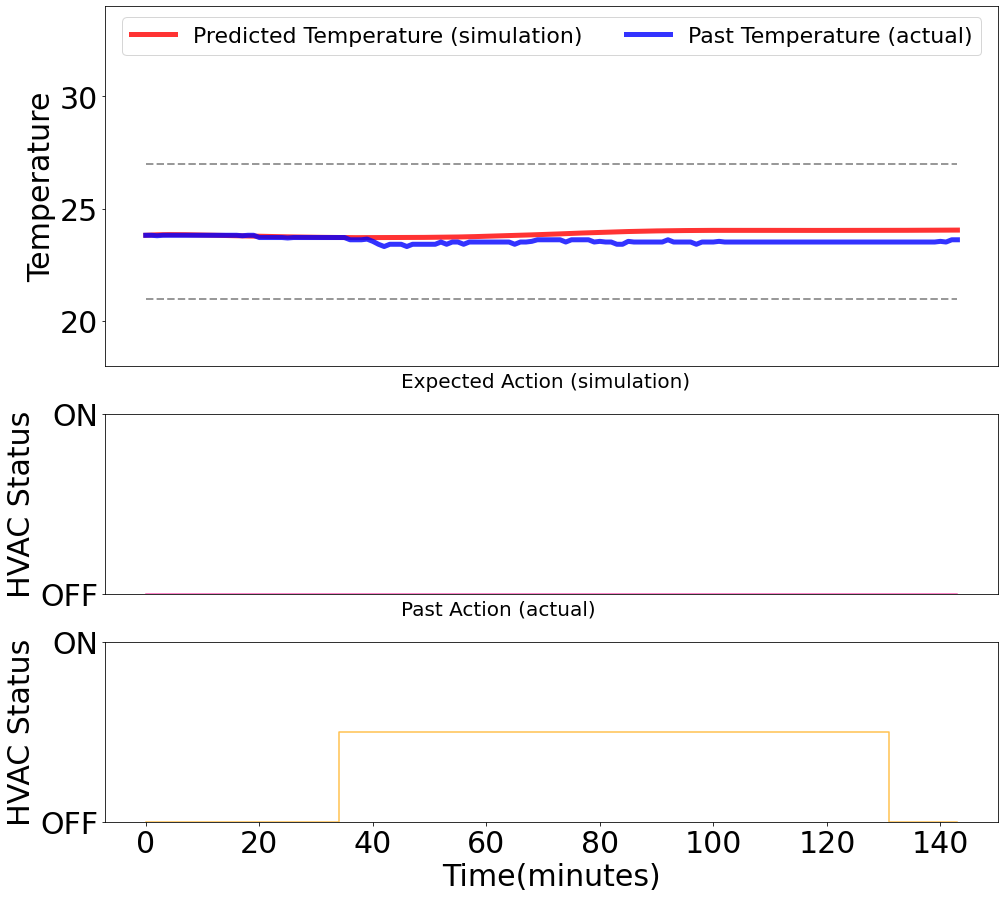

97.0
0
1 일 평균 절감율 :  100.0 실제 평균 온도 :  23.582847222222213 학습 평균 온도 :  23.89472602409192 오차율 :  -0.31187880186970673


2023-02-02 03:52:04,979	WARNING trainer.py:2348 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.


/raid/deallab/ecm/model_result/2019-10-23/20191023w30_linear_regression.joblib
Reset data f3_temp : 23.42
Reset data f3_temp : 24.22
Reset data f3_temp : 23.92


2023-02-02 03:52:08,519	WARNING deprecation.py:46 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
2023-02-02 03:52:08,523	WARNING trainer.py:2348 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.
2023-02-02 03:52:09,642	INFO trainable.py:496 -- Restored on 192.168.0.40 from checkpoint: /raid/deallab/yechae/ECM/2023/result/2019-10-22/RL_ECM_DoubleDQN_2023-02-02_03-49-52v0igykqm/checkpoint_005900/checkpoint-5900
2023-02-02 03:52:09,646	INFO trainable.py:503 -- Current state after restoring: {'_iteration': 5900, '_timesteps_total': 1510400, '_time_total': 6531.857882022858, '_episodes_total': 28635}


100
start_after_for :  0.00036597251892089844
Reset data f3_temp : 23.72
Reset data f3_temp : 23.72
Reset data f3_temp : 23.92
Reset data f3_temp : 23.92
Reset data f3_temp : 23.62
Reset data f3_temp : 23.52
Reset data f3_temp : 23.7
Reset data f3_temp : 23.42
Reset data f3_temp : 23.82
Reset data f3_temp : 23.92
Reset data f3_temp : 23.32
Reset data f3_temp : 23.82
Reset data f3_temp : 24.02
Reset data f3_temp : 24.22
Reset data f3_temp : 23.8
Reset data f3_temp : 24.05
(scheduler +16m26s) Warning: The following resource request cannot be scheduled right now: {'GPU': 1.0, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
Reset data f3_temp : 23.7
Reset data f3_temp : 24.15
  1 reward min : -15.00/ mean :  -3.24/ max :  15.00/ len   6.00
checkpoint saved at /raid/deallab/yechae/ECM/2023/result/2019-10-23/RL_ECM_DoubleDQN_2023-02-02_03-52-04bx2iw7h7/checkpoint_005901/checkpoint-5901


2023-02-02 03:52:21,701	WARNING worker.py:1326 -- The actor or task with ID ffffffffffffffffdc9c5eccc10b0c0debd361e701000000 cannot be scheduled right now. You can ignore this message if this Ray cluster is expected to auto-scale or if you specified a runtime_env for this actor or task, which may take time to install.  Otherwise, this is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increasing the resources available to this Ray cluster.
Required resources for this actor or task: {CPU: 1.000000}, {GPU: 1.000000}
Available resources on this node: {39.000000/40.000000 CPU, 98.620785 GiB/98.620785 GiB memory, 0.000000/1.000000 GPU, 46.257433 GiB/46.257433 GiB object_store_memory, 1.000000/1.000000 node:192.168.0.40, 1.000000/1.000000 accelerator_type:V100}
 In total there are 0 pending tasks and 1 pending actors on this node.


Reset data f3_temp : 23.42
  7 reward min : -15.00/ mean :  -2.21/ max :  15.00/ len   6.00
Elapsed time one episode :  2.4322047233581543
start_after_for :  9.5367431640625e-06
Reset data f3_temp : 23.72
Reset data f3_temp : 24.05
  8 reward min : -15.00/ mean :  -2.08/ max :  15.00/ len   6.00
Elapsed time one episode :  0.8668744564056396
start_after_for :  4.0531158447265625e-06
Reset data f3_temp : 24.15
(RolloutWorker pid=19413) Reset data f3_temp : 23.72
(RolloutWorker pid=19413) Reset data f3_temp : 23.72
Reset data f3_temp : 23.52


(RolloutWorker pid=19413) /home/deallab/anaconda3/envs/daewoong/lib/python3.7/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=19413)   warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


Reset data f3_temp : 23.62
  9 reward min : -15.00/ mean :  -1.91/ max :  15.00/ len   6.00
Elapsed time one episode :  1.8787312507629395
start_after_for :  1.2874603271484375e-05
Reset data f3_temp : 23.52
Reset data f3_temp : 23.52
 10 reward min : -15.00/ mean :  -1.81/ max :  15.00/ len   6.00
Elapsed time one episode :  1.113800048828125
start_after_for :  1.4781951904296875e-05
Reset data f3_temp : 23.95
Reset data f3_temp : 23.82
 11 reward min : -15.00/ mean :  -1.73/ max :  15.00/ len   6.00
Elapsed time one episode :  1.6622674465179443
start_after_for :  2.1457672119140625e-06
Reset data f3_temp : 23.42
 12 reward min : -15.00/ mean :  -1.69/ max :  15.00/ len   6.00
Elapsed time one episode :  0.5747334957122803
start_after_for :  2.384185791015625e-06
Reset data f3_temp : 24.15
Reset data f3_temp : 23.42
 13 reward min : -15.00/ mean :  -1.61/ max :  15.00/ len   6.00
Elapsed time one episode :  0.9799339771270752
start_after_for :  5.9604644775390625e-06
Reset data f3_te

Reset data f3_temp : 23.42
 49 reward min : -15.00/ mean :   1.93/ max :   7.44/ len   6.00
Elapsed time one episode :  1.0507018566131592
start_after_for :  7.867813110351562e-06
Reset data f3_temp : 23.7
Reset data f3_temp : 24.02
Reset data f3_temp : 23.82
 50 reward min :  -5.04/ mean :   2.30/ max :   7.44/ len   6.00
Elapsed time one episode :  1.4427404403686523
start_after_for :  9.5367431640625e-06
Reset data f3_temp : 23.72
Reset data f3_temp : 23.92
 51 reward min :  -0.12/ mean :   2.43/ max :   7.44/ len   6.00
Elapsed time one episode :  1.3024928569793701
start_after_for :  7.62939453125e-06
Reset data f3_temp : 23.42
Reset data f3_temp : 24.22
 52 reward min :  -0.12/ mean :   2.50/ max :   7.44/ len   6.00
Elapsed time one episode :  1.0477144718170166
start_after_for :  8.106231689453125e-06
Reset data f3_temp : 23.4
Reset data f3_temp : 23.82
 53 reward min :  -0.12/ mean :   2.60/ max :   7.44/ len   6.00
Elapsed time one episode :  1.1842176914215088
start_after_fo

Reset data f3_temp : 23.42
Reset data f3_temp : 23.52
 88 reward min :  -5.04/ mean :   6.74/ max :  15.00/ len   6.00
Elapsed time one episode :  1.1908330917358398
start_after_for :  4.5299530029296875e-06
Reset data f3_temp : 24.05
Reset data f3_temp : 24.15
 89 reward min :  -5.04/ mean :   6.84/ max :  15.00/ len   6.00
Elapsed time one episode :  1.1519155502319336
start_after_for :  1.6689300537109375e-06
Reset data f3_temp : 23.52
Reset data f3_temp : 23.92
 90 reward min :  -5.04/ mean :   6.96/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0235857963562012
start_after_for :  2.1457672119140625e-06
Reset data f3_temp : 24.15
Reset data f3_temp : 23.92
 91 reward min :  -5.04/ mean :   7.07/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0578374862670898
start_after_for :  1.9073486328125e-06
Reset data f3_temp : 23.42
Reset data f3_temp : 23.42
 92 reward min :  -5.04/ mean :   7.19/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0565202236175537
start

<Figure size 432x288 with 0 Axes>

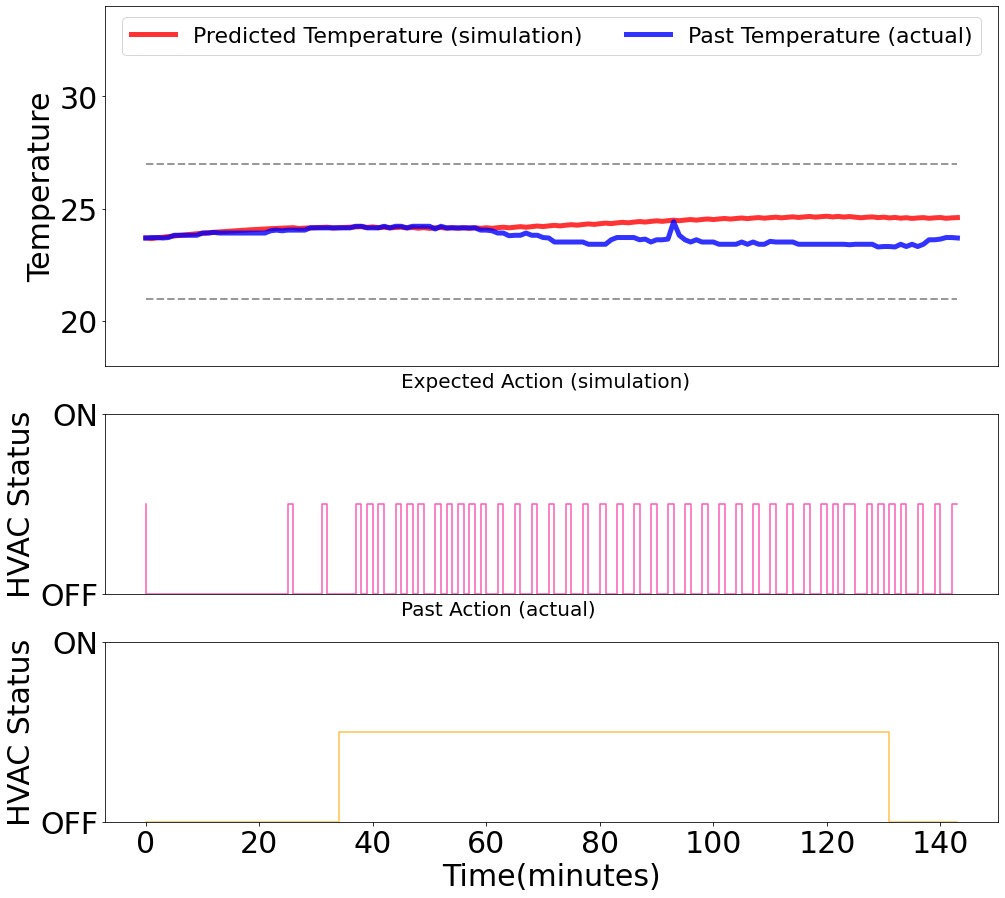

2023-02-02 03:54:22,330	WARNING trainer.py:2348 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.


97.0
44
1 일 평균 절감율 :  54.63917525773196 실제 평균 온도 :  23.762013888888905 학습 평균 온도 :  24.303272837853562 오차율 :  -0.5412589489646571
/raid/deallab/ecm/model_result/2019-10-24/20191024w7_linear_regression.joblib
Reset data f3_temp : 23.2
Reset data f3_temp : 23.42
Reset data f3_temp : 23.3


2023-02-02 03:54:28,718	WARNING deprecation.py:46 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
2023-02-02 03:54:28,722	WARNING trainer.py:2348 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.
2023-02-02 03:54:30,354	INFO trainable.py:496 -- Restored on 192.168.0.40 from checkpoint: /raid/deallab/yechae/ECM/2023/result/2019-10-23/RL_ECM_DoubleDQN_2023-02-02_03-52-04bx2iw7h7/checkpoint_006000/checkpoint-6000
2023-02-02 03:54:30,357	INFO trainable.py:503 -- Current state after restoring: {'_iteration': 6000, '_timesteps_total': 1536000, '_time_total': 6638.129773378372, '_episodes_total': 28860}


100
start_after_for :  8.821487426757812e-05
Reset data f3_temp : 24.05
Reset data f3_temp : 23.42
Reset data f3_temp : 23.92
Reset data f3_temp : 23.92
Reset data f3_temp : 23.2
Reset data f3_temp : 23.42
Reset data f3_temp : 23.2
Reset data f3_temp : 23.82
Reset data f3_temp : 23.52
Reset data f3_temp : 23.92
Reset data f3_temp : 23.92
(scheduler +18m46s) Warning: The following resource request cannot be scheduled right now: {'GPU': 1.0, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
Reset data f3_temp : 23.12
Reset data f3_temp : 23.42
Reset data f3_temp : 23.92
Reset data f3_temp : 23.92
Reset data f3_temp : 23.2
Reset data f3_temp : 23.72
Reset data f3_temp : 23.92
  1 reward min :   4.96/ mean :   8.64/ max :   9.98/ len   6.00
checkpoint saved at /raid/deallab/yechae/ECM/2023/result/2019-10-24/RL_ECM_DoubleDQN_2023-02-02_03-54-223a2rx4ka/checkpoint_006001/checkpoint-6001
E

2023-02-02 03:54:42,163	WARNING worker.py:1326 -- The actor or task with ID ffffffffffffffffcfcac64fc5347bbf0225d1fc01000000 cannot be scheduled right now. You can ignore this message if this Ray cluster is expected to auto-scale or if you specified a runtime_env for this actor or task, which may take time to install.  Otherwise, this is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increasing the resources available to this Ray cluster.
Required resources for this actor or task: {CPU: 1.000000}, {GPU: 1.000000}
Available resources on this node: {39.000000/40.000000 CPU, 98.620785 GiB/98.620785 GiB memory, 0.000000/1.000000 GPU, 46.257433 GiB/46.257433 GiB object_store_memory, 1.000000/1.000000 node:192.168.0.40, 1.000000/1.000000 accelerator_type:V100}
 In total there are 0 pending tasks and 1 pending actors on this node.


Reset data f3_temp : 23.42
  4 reward min :   4.96/ mean :   8.94/ max :   9.98/ len   6.00
Elapsed time one episode :  2.991419792175293
start_after_for :  8.106231689453125e-06
Reset data f3_temp : 24.1
Reset data f3_temp : 23.42


(RolloutWorker pid=19456) /home/deallab/anaconda3/envs/daewoong/lib/python3.7/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=19456)   warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


(RolloutWorker pid=19456) Reset data f3_temp : 24.05
(RolloutWorker pid=19456) Reset data f3_temp : 23.42
  5 reward min :   4.96/ mean :   9.02/ max :   9.98/ len   6.00
Elapsed time one episode :  1.3071370124816895
start_after_for :  1.430511474609375e-06
Reset data f3_temp : 24.02
Reset data f3_temp : 24.1
  6 reward min :   4.96/ mean :   9.09/ max :   9.98/ len   6.00
Elapsed time one episode :  1.0761520862579346
start_after_for :  4.0531158447265625e-06
Reset data f3_temp : 23.72
Reset data f3_temp : 23.52
  7 reward min :   4.96/ mean :   9.07/ max :   9.98/ len   6.00
Elapsed time one episode :  1.4433410167694092
start_after_for :  1.4543533325195312e-05
Reset data f3_temp : 24.02
Reset data f3_temp : 23.92
  8 reward min :   4.96/ mean :   9.13/ max :   9.98/ len   6.00
Elapsed time one episode :  1.8516552448272705
start_after_for :  9.298324584960938e-06
Reset data f3_temp : 23.95
  9 reward min :   4.96/ mean :   9.07/ max :   9.98/ len   6.00
Elapsed time one episode : 

Reset data f3_temp : 23.15
 47 reward min : -15.00/ mean :   9.99/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0702404975891113
start_after_for :  5.245208740234375e-06
Reset data f3_temp : 23.12
Reset data f3_temp : 23.42
 48 reward min : -15.00/ mean :   9.49/ max :  15.00/ len   6.00
Elapsed time one episode :  2.2338428497314453
start_after_for :  9.5367431640625e-06
Reset data f3_temp : 23.32
 49 reward min : -15.00/ mean :   9.28/ max :  15.00/ len   6.00
Elapsed time one episode :  1.1015474796295166
start_after_for :  1.5497207641601562e-05
Reset data f3_temp : 23.2
Reset data f3_temp : 23.32
 50 reward min : -15.00/ mean :   8.81/ max :  15.00/ len   6.00
Elapsed time one episode :  1.2301719188690186
start_after_for :  1.1920928955078125e-06
Reset data f3_temp : 23.42
 51 reward min : -15.00/ mean :   8.56/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0158038139343262
start_after_for :  5.0067901611328125e-06
Reset data f3_temp : 24.05
 52 reward min : -1

Reset data f3_temp : 23.92
 91 reward min : -15.00/ mean :   4.48/ max :  15.00/ len   6.00
Elapsed time one episode :  1.2057573795318604
start_after_for :  6.67572021484375e-06
Reset data f3_temp : 23.42
 92 reward min : -15.00/ mean :   4.43/ max :  15.00/ len   6.00
Elapsed time one episode :  1.3056838512420654
start_after_for :  4.291534423828125e-06
Reset data f3_temp : 23.62
 93 reward min : -15.00/ mean :   4.43/ max :  15.00/ len   6.00
Elapsed time one episode :  1.1376237869262695
start_after_for :  1.6689300537109375e-06
Reset data f3_temp : 23.4
 94 reward min : -15.00/ mean :   4.43/ max :  15.00/ len   6.00
Elapsed time one episode :  0.9095196723937988
start_after_for :  6.67572021484375e-06
Reset data f3_temp : 23.72
Reset data f3_temp : 24.15
 95 reward min : -15.00/ mean :   4.38/ max :  15.00/ len   6.00
Elapsed time one episode :  1.659766674041748
start_after_for :  1.239776611328125e-05
Reset data f3_temp : 23.2
 96 reward min : -15.00/ mean :   4.40/ max :  15.

<Figure size 432x288 with 0 Axes>

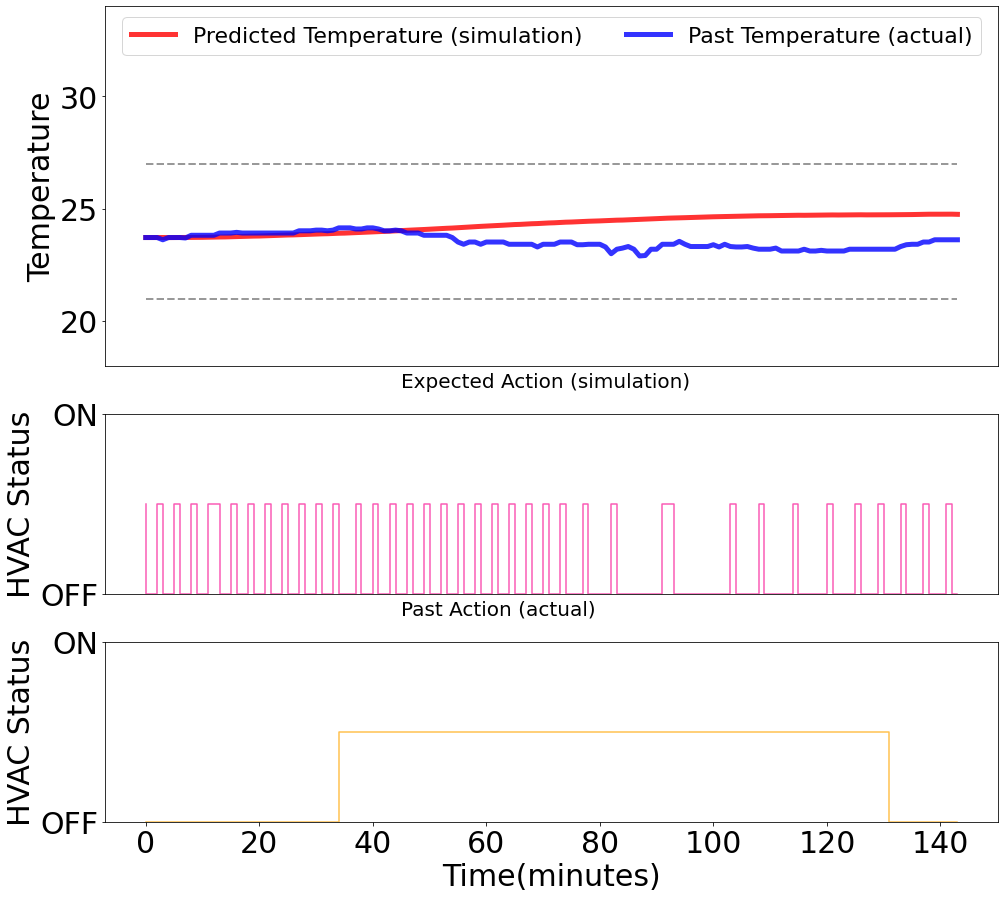

97.0
39
1 일 평균 절감율 :  59.79381443298969 실제 평균 온도 :  23.554791666666656 학습 평균 온도 :  24.30096291861858 오차율 :  -0.7461712519519246


In [38]:
Train_date =  datetime.date(2019,10,15)
#start_date = datetime.date(2019, 8,23)
end_date = datetime.date(2019,10,24)
daterange = pd.date_range(Train_date, end_date)

checkpoint_path = '/raid/deallab/yechae/ECM/2023/result/2019-10-14/RL_ECM_DoubleDQN_2023-02-02_03-27-41dg41ijg_/checkpoint_005100/checkpoint-5100'
print(checkpoint_path)
first_start = time.time()
result_final_df = pd.read_csv(f'/raid/deallab/yechae/ECM/2023/result/DoubleDQN-pre.csv')

for single_date in daterange:
#for i in range(81):
# 발산값 처리 
    if Train_date==datetime.date(2019,9,18) or Train_date==datetime.date(2019,8,27)  :
        Train_date = Train_date+datetime.timedelta(days=1)
        continue
        
    cur_model = best_forecastmodel[(pd.to_datetime(best_forecastmodel.index).date) == Train_date]
    df_test_pre = makeData(df_train, Train_date)
    date = datetime.datetime.strptime(cur_model.index.values[0], '%Y-%m-%d')
    Train_window_size = cur_model.window_size.values[0]
    model_name = cur_model.model.values[0]
    
    if Train_date == datetime.date(2019,10,3) or Train_date == datetime.date(2019,10,4):  # 결측 데이터 처리 
        df_test_pre = df_test_pre.interpolate(method='linear', limit_direction='forward')
    
    #dl_path = f'/raid/deallab/ecm/model_result_no_window_dl/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w{Train_window_size}_{model_name}.h5'
#     one_day_path =  f'/raid/deallab/ecm/model_result_no_window/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w1_linear_regression.joblib'
#     seven_day_path =  f'/raid/deallab/ecm/model_result_no_window/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w7_linear_regression.joblib'
#     fourtenn_day_path =  f'/raid/deallab/ecm/model_result_no_window/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w14_linear_regression.joblib'
#     model_path = f'/raid/deallab/ecm/model_result_no_window/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w21_linear_regression.joblib'


#     if Train_date <= datetime.date(2019,8,28):
#         path = one_day_path
#     elif Train_date <= datetime.date(2019,9,4):
#         path = seven_day_path
#     elif Train_date <= datetime.date(2019, 9,11):
#         path = fourtenn_day_path
#     else:
#         path = model_path
    path = f'/raid/deallab/ecm/model_result/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w{Train_window_size}_linear_regression.joblib'
    print(path)
    
    max_action = getMaxAction(df_test_pre)
    method_name = "Env_ML"
    env_config = {'max_temp': 25, 'min_temp' : 23.5, 'method_name': method_name, 'model' : path, 'max_action' : max_action, 'init_data' : df_test_pre}
    


    env = ECM_Env_ML(env_config)
    select_env = "ECMEnv2023-v0"
    register_env(select_env, lambda config: ECM_Env_ML(env_config))
    
    save_path = f'/raid/deallab/yechae/ECM/2023/result/{Train_date.strftime("%Y-%m-%d")}/' #./result/agent
    trainer_dqn = agents.dqn.DQNTrainer(config_dqn, env=select_env, logger_creator = custom_log_creator(os.path.expanduser(save_path), 'RL_ECM_DoubleDQN'))
    
    trainer_dqn.restore(checkpoint_path)
    
    
    s = "{:3d} reward min : {:6.2f}/ mean : {:6.2f}/ max : {:6.2f}/ len {:6.2f}"
    train_dqn_episode = 100
    reward_dqn_list = pd.DataFrame(columns = ['mean'])
    
    # === Train === 
    start = time.time()
    start_after_for = time.time()
    print(train_dqn_episode)
    for i in range(train_dqn_episode):
        print("start_after_for : ", time.time() - start_after_for )
        start_episode = time.time()
        result = trainer_dqn.train()
        print(s.format(
            i + 1,
            result["episode_reward_min"],
            result["episode_reward_mean"],
            result["episode_reward_max"],
            result["episode_len_mean"]
           ))
        reward_dqn_list = reward_dqn_list.append({'mean': result["episode_reward_mean"]}, ignore_index=True)
        if i % 100 == 0:
            checkpoint = trainer_dqn.save()
            print("checkpoint saved at", checkpoint)
        print("Elapsed time one episode : ", time.time() - start_episode)
        start_after_for = time.time()
    Elapsed_time = time.time() - start
    print("Elapsed time : ", Elapsed_time)
   
    checkpoint_path = trainer_dqn.save()

    print("checkpoint saved at", checkpoint_path)
    
    
    real_df, next_df, actions, result_df = result_base_RL([df_test_pre], Train_date, path, max_action, trainer_dqn)
    new_df = pd.DataFrame()
    new_df.index = real_df.index
    new_df['real_temp'] = real_df['temp']
    new_df['real_hum'] = real_df['hum']
    new_df['real_action'] = real_df['action']
    new_df['RL_temp'] = next_df['f3_temp']
    new_df['RL_hum'] = next_df['f3_hum']
    new_df['RL_action'] = actions
    
    # path 변경하기 
    new_df_path = f'/raid/deallab/yechae/ECM/2023/result/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y-%m-%d")}-DoubleDQN-pre.csv.csv'
    new_df.to_csv(new_df_path)
    result_final_df = result_df.append(result_final_df)
    
     # elapsed 타임 너무 오래 걸리면 끝내기
    if Elapsed_time > 240:
        print(checkpoint)
        print(Train_date)
        print("Finished Time : ", time.time() - first_start)
        break

    
    Train_date = Train_date+datetime.timedelta(days=1)
    
#result_final_df = result_final_df.sort_values(by=['0'], axis=0)
result_df_path = f'/raid/deallab/yechae/ECM/2023/result/DoubleDQN-pre.csv'
result_final_df.to_csv(result_df_path)

    # ENV 세팅
    #env_config = {'max_temp': 27, 'min_temp' : 21, 'method_name': method_name, 'model' : path, 'max_action' : max_action}
    #env = ECM_Env_DL(env_config)
    
    #select_env = "ECMEnv2023-v0"
    #register_env(select_env, lambda config: ECM_Env_DL(env_config))
        

In [ ]:
# /raid/deallab/yechae/ECM/2023/result/2019-09-20/RL_ECM_DQN-lin-6-pre-basic-3_2023-02-01_13-15-35fvg49ev7/checkpoint_002800/checkpoint-2800 : 결과 잘 나올 것 같음 ㅠㅠ 

In [66]:
[ 5.2000000e+01,  5.6270924e+01,  2.5820463e+01,  2.2370001e+01,
       -7.8326700e+11,  8.0400002e+01,  9.6600801e+10,  2.7500000e+01,
       -2.0922839e+10]

2023-02-01 11:14:06,722	WARNING worker.py:1326 -- The actor or task with ID ffffffffffffffff0e159c35f2d0f2d108f42edd01000000 cannot be scheduled right now. You can ignore this message if this Ray cluster is expected to auto-scale or if you specified a runtime_env for this actor or task, which may take time to install.  Otherwise, this is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increasing the resources available to this Ray cluster.
Required resources for this actor or task: {CPU: 1.000000}, {GPU: 1.000000}
Available resources on this node: {39.000000/40.000000 CPU, 126.704317 GiB/126.704317 GiB memory, 0.000000/1.000000 GPU, 58.293233 GiB/58.293233 GiB object_store_memory, 1.000000/1.000000 node:192.168.0.40, 1.000000/1.000000 accelerator_type:V100}
 In total there are 0 pending tasks and 1 pending actors on this node.


[52.0,
 56.270924,
 25.820463,
 22.370001,
 -783267000000.0,
 80.400002,
 96600801000.0,
 27.5,
 -20922839000.0]

(RolloutWorker pid=18204) /home/deallab/anaconda3/envs/daewoong/lib/python3.7/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=18204)   warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


(RolloutWorker pid=18204) Reset data f3_temp : 21.07
(RolloutWorker pid=18204) Reset data f3_temp : 25.37


In [ ]:
app = test1.append(test2)

In [50]:
app = app.sort_values(by=['0'], axis=0)

In [51]:
app.to_csv(f'/raid/deallab/yechae/ECM/2023/result/DQN_final-linear-6-range-pre-result.csv')

In [43]:
test1= pd.read_csv(f'/raid/deallab/yechae/ECM/2023/result/DQN_final-linear-6-range-pre-result.csv')

In [44]:
test2= pd.read_csv(f'/raid/deallab/yechae/ECM/2023/result/DQN_final-linear-6-range-pre-result-2.csv')

In [43]:
result_df_path = f'/raid/deallab/yechae/ECM/2023/result/DQN_final-linear-6-result.csv'
result_df.to_csv(result_df_path)

In [ ]:
'/raid/deallab/yechae/ECM/2023/result/2019-10-24/RL_ECM_DQN-lin-6-pre-basic_2023-01-31_21-28-08h1rw2fp6/checkpoint_006300/checkpoint-6300' # 첫번째, reward = (action_reward * 2.5)  - temp_violation_reward - power_reward , basic

# 결과 확인

2023-02-02 04:00:46,507	INFO trainer.py:2141 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also then want to set eager_tracing=True in order to reach similar execution speed as with static-graph mode.
2023-02-02 04:00:46,512	WARNING trainer.py:2348 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.
2023-02-02 04:00:46,513	INFO simple_q.py:155 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting `simple_optimizer=True` if this doesn't work for you.
2023-02-02 04:00:46,513	INFO trainer.py:781 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


/raid/deallab/yechae/ECM/2023/result/2019-10-24/RL_ECM_DoubleDQN_2023-02-02_03-54-223a2rx4ka/checkpoint_006100/checkpoint-6100
Reset data f3_temp : 20.17
Reset data f3_temp : 20.27
Reset data f3_temp : 20.55


2023-02-02 04:00:51,089	WARNING deprecation.py:46 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
2023-02-02 04:00:51,090	WARNING trainer.py:2348 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.


Instructions for updating:
Prefer Variable.assign which has equivalent behavior in 2.X.


2023-02-02 04:00:51,349	INFO trainable.py:496 -- Restored on 192.168.0.40 from checkpoint: /raid/deallab/yechae/ECM/2023/result/2019-10-24/RL_ECM_DoubleDQN_2023-02-02_03-54-223a2rx4ka/checkpoint_006100/checkpoint-6100
2023-02-02 04:00:51,351	INFO trainable.py:503 -- Current state after restoring: {'_iteration': 6100, '_timesteps_total': 1561600, '_time_total': 6745.958900928497, '_episodes_total': 29016}
2023-02-02 04:00:51,391	WARNING deprecation.py:46 -- DeprecationWarning: `compute_action` has been deprecated. Use `Trainer.compute_single_action()` instead. This will raise an error in the future!


/raid/deallab/ecm/model_result/2019-08-23/20190823w1_linear_regression.joblib
F_SET_MODE_4
Reset data f3_temp : 27.3
[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
2019-08-23 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  96 실제 평균 온도 :  25.0945138888889 학습 평균 온도 :  28.43648954421515


<Figure size 432x288 with 0 Axes>

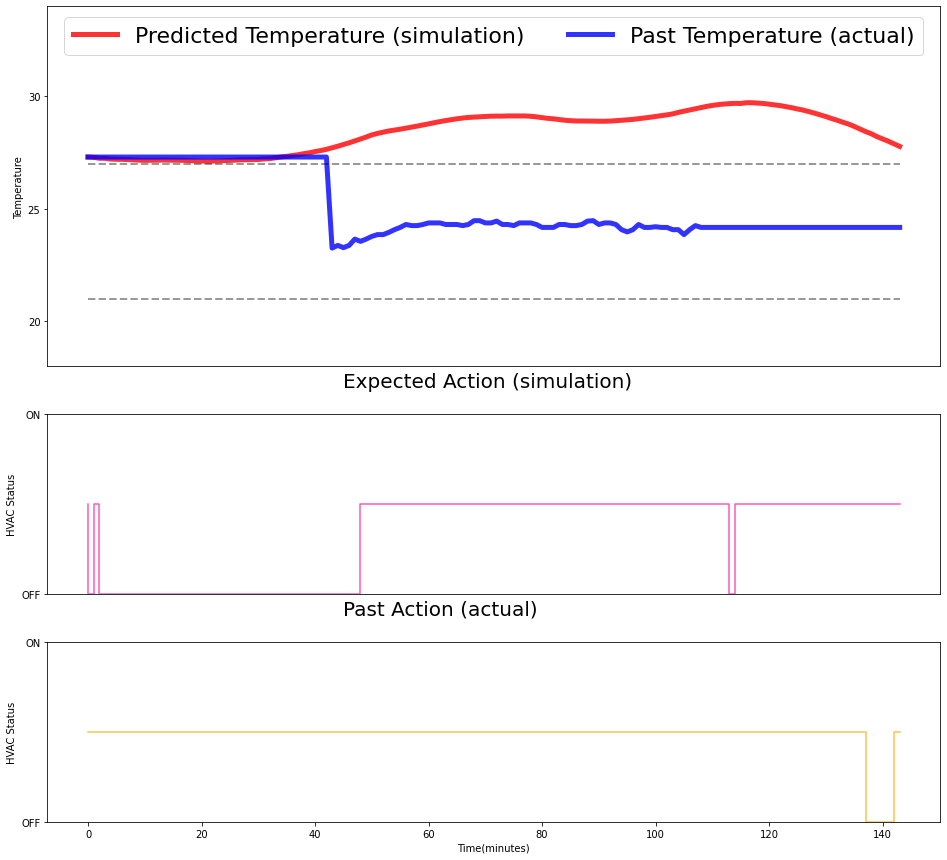

139.0
96
1 일 평균 절감율 :  30.935251798561154 실제 평균 온도 :  25.0945138888889 학습 평균 온도 :  28.43648954421515 오차율 :  -3.341975655326248
/raid/deallab/ecm/model_result/2019-08-24/20190824w1_linear_regression.joblib
F_SET_MODE_4
Reset data f3_temp : 24.17
(RolloutWorker pid=10470) Reset data f3_temp : 20.55
(RolloutWorker pid=10470) Reset data f3_temp : 20.15


(RolloutWorker pid=10470) /home/deallab/anaconda3/envs/daewoong/lib/python3.7/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=10470)   warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-08-24 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  107 실제 평균 온도 :  21.98923611111115 학습 평균 온도 :  22.597462789047285


<Figure size 432x288 with 0 Axes>

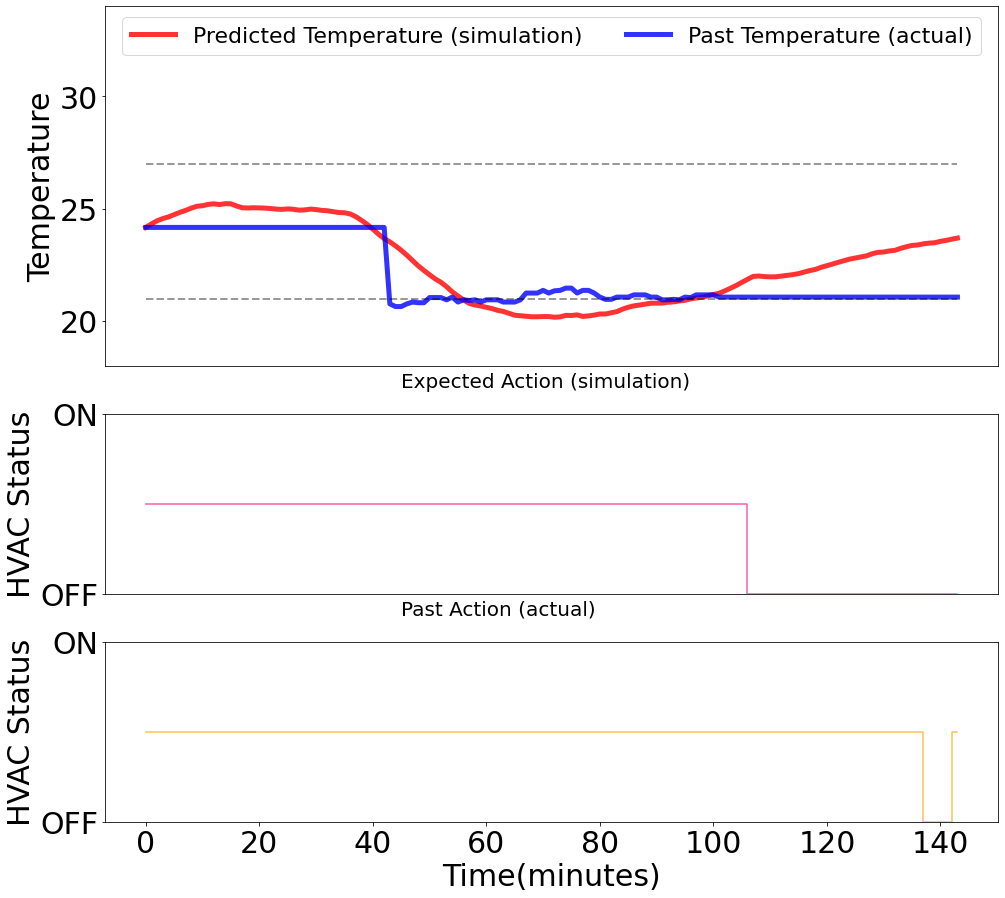

139.0
107
1 일 평균 절감율 :  23.021582733812952 실제 평균 온도 :  21.98923611111115 학습 평균 온도 :  22.597462789047285 오차율 :  -0.608226677936134
/raid/deallab/ecm/model_result/2019-08-25/20190825w1_linear_regression.joblib
F_SET_MODE_4
Reset data f3_temp : 21.07
[1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
2019-08-25 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  65 실제 평균 온도 :  21.070000000000036 학습 평균 온도 :  21.41766873102666


<Figure size 432x288 with 0 Axes>

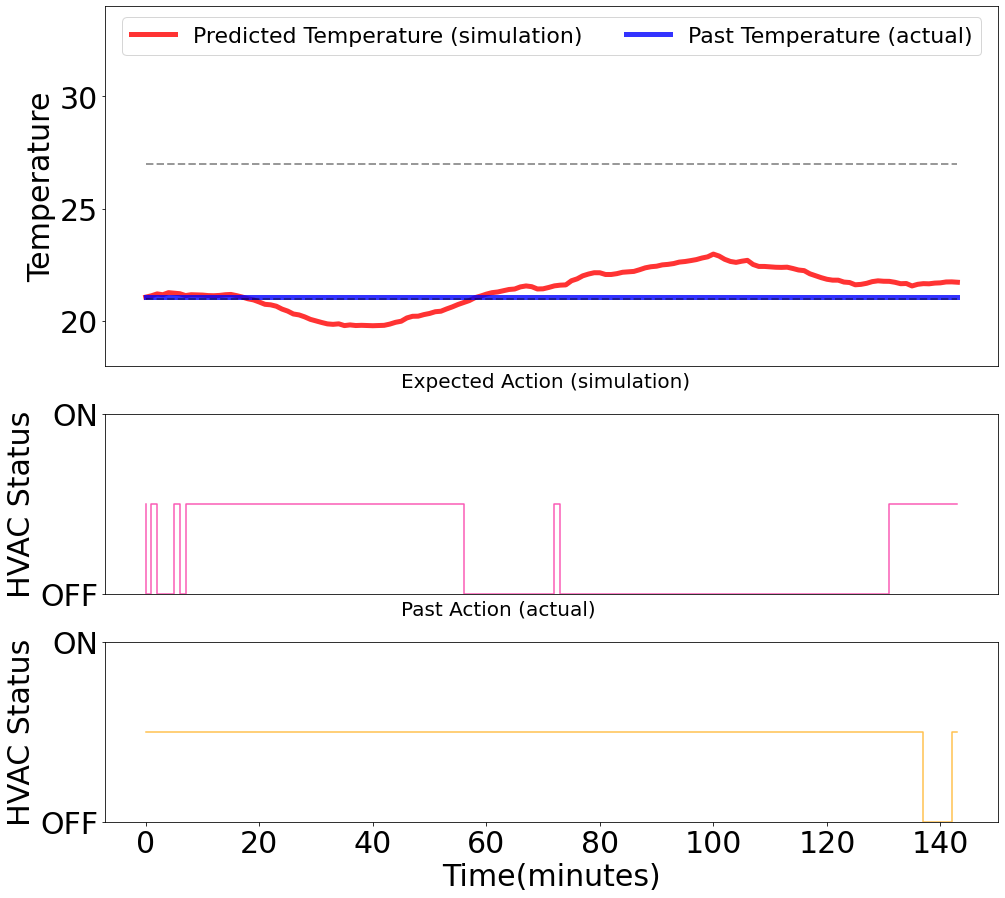

139.0
65
1 일 평균 절감율 :  53.23741007194245 실제 평균 온도 :  21.070000000000036 학습 평균 온도 :  21.41766873102666 오차율 :  -0.3476687310266229
/raid/deallab/ecm/model_result/2019-08-26/20190826w1_linear_regression.joblib
F_SET_MODE_4
Reset data f3_temp : 21.07
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
2019-08-26 실제 데이터 길이 :  144  : real action :  144.0 , expected action :  142 실제 평균 온도 :  21.070000000000036 학습 평균 온도 :  21.07000000000004


<Figure size 432x288 with 0 Axes>

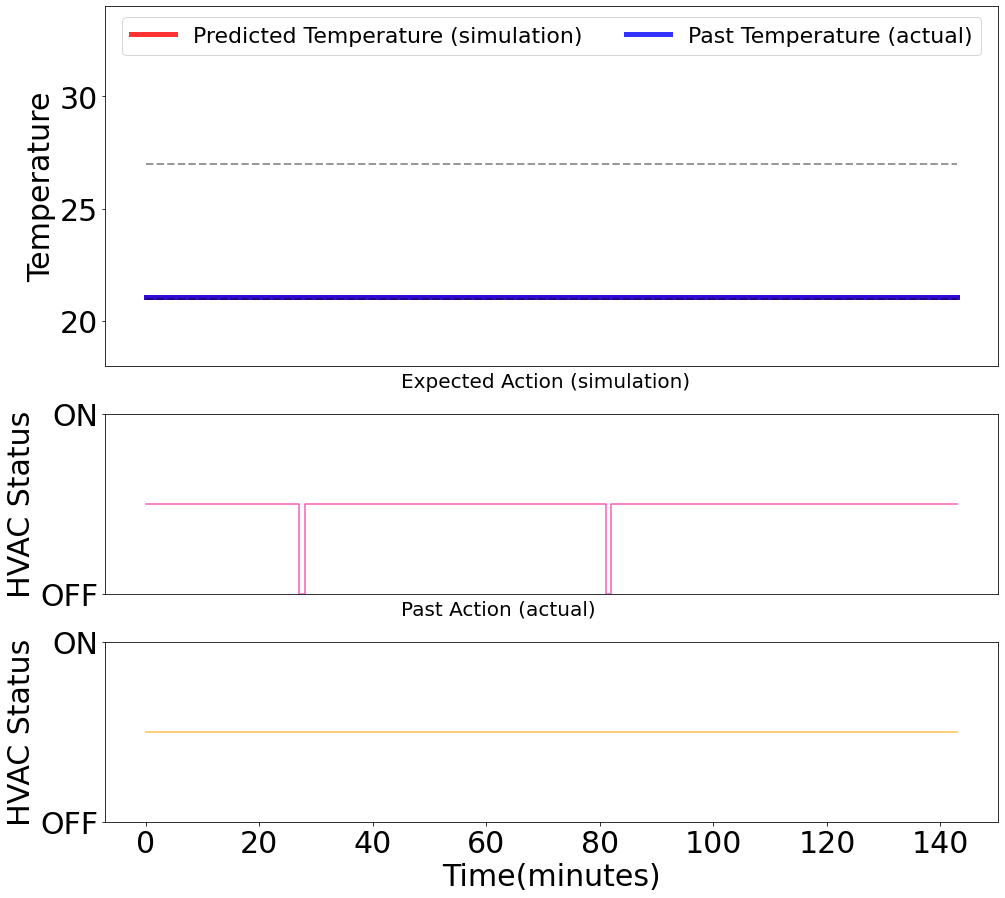

144.0
142
1 일 평균 절감율 :  1.3888888888888888 실제 평균 온도 :  21.070000000000036 학습 평균 온도 :  21.07000000000004 오차율 :  -3.552713678800501e-15
/raid/deallab/ecm/model_result/2019-08-27/20190827w1_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 21.07
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
2019-08-27 실제 데이터 길이 :  144  : real action :  79.0 , expected action :  143 실제 평균 온도 :  23.379374999999953 학습 평균 온도 :  21.070000000000036


<Figure size 432x288 with 0 Axes>

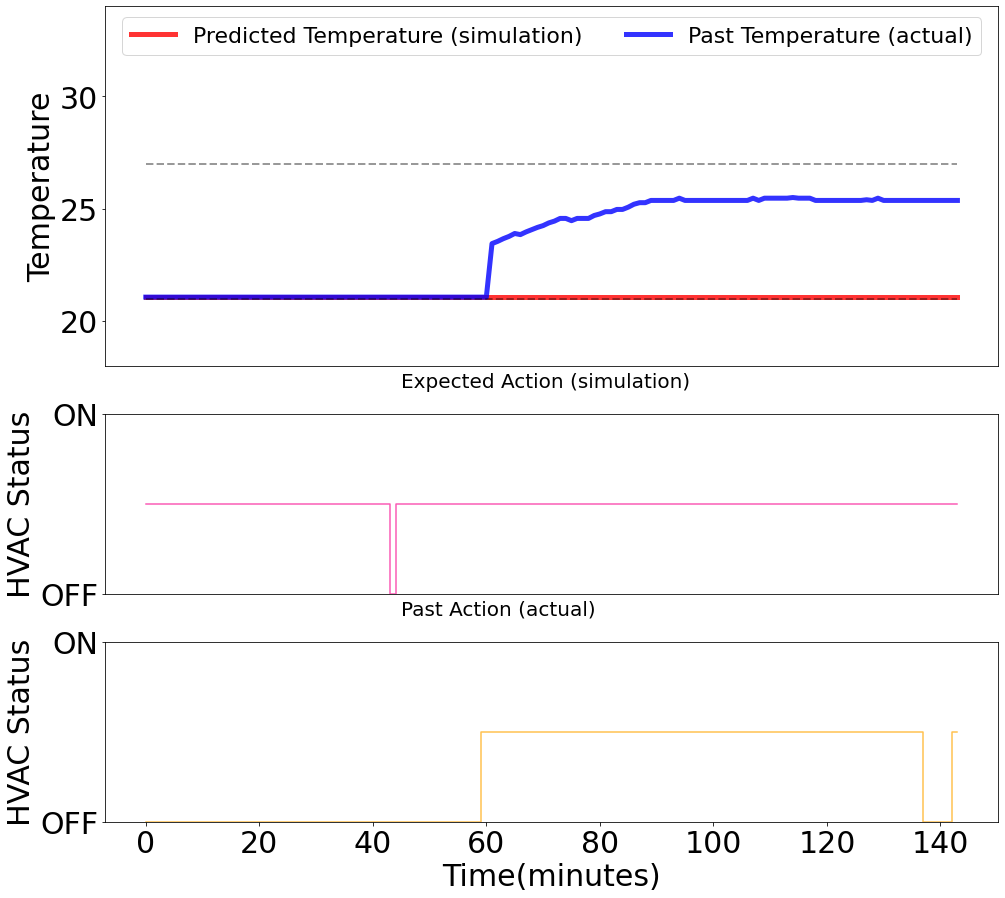

79.0
143
1 일 평균 절감율 :  -81.0126582278481 실제 평균 온도 :  23.379374999999953 학습 평균 온도 :  21.070000000000036 오차율 :  2.3093749999999176
/raid/deallab/ecm/model_result/2019-08-28/20190828w1_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 25.37
[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
2019-08-28 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  79 실제 평균 온도 :  25.814513888888925 학습 평균 온도 :  25.334610518200847


<Figure size 432x288 with 0 Axes>

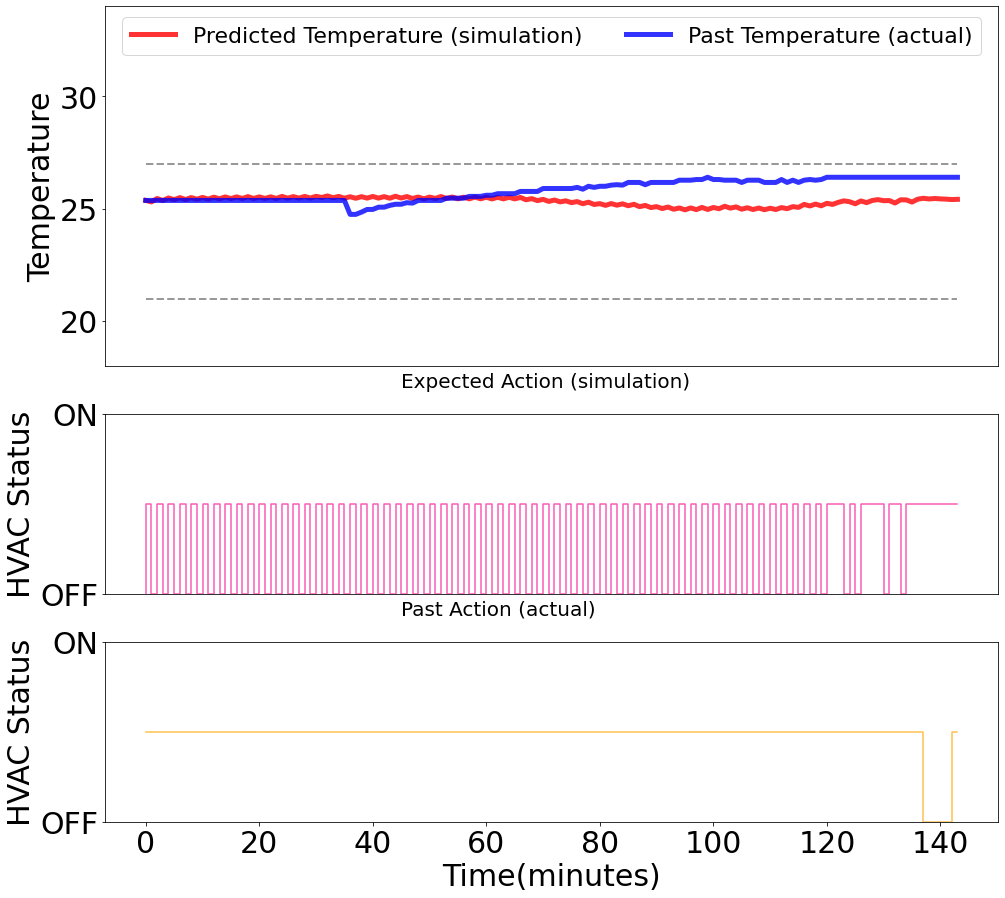

139.0
79
1 일 평균 절감율 :  43.16546762589928 실제 평균 온도 :  25.814513888888925 학습 평균 온도 :  25.334610518200847 오차율 :  0.47990337068807776
/raid/deallab/ecm/model_result/2019-08-29/20190829w1_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 26.4
[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
2019-08-29 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  70 실제 평균 온도 :  25.631250000000026 학습 평균 온도 :  26.15595521277151


<Figure size 432x288 with 0 Axes>

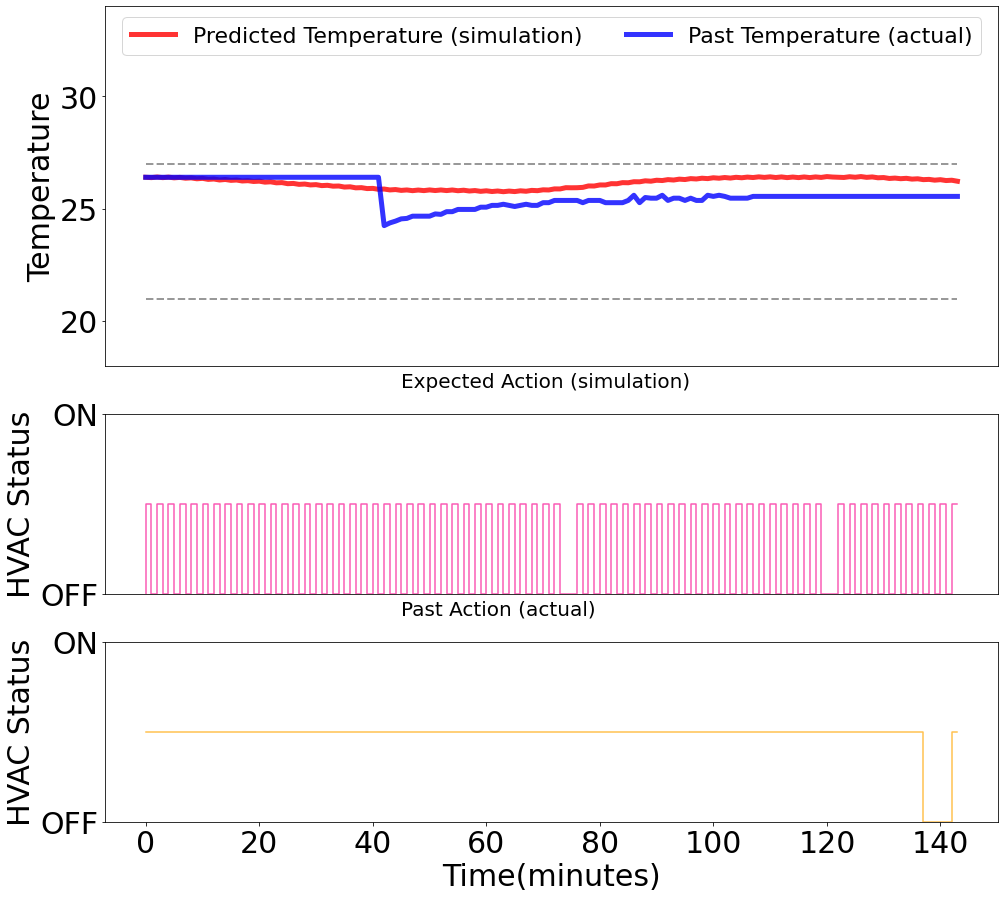

139.0
70
1 일 평균 절감율 :  49.64028776978417 실제 평균 온도 :  25.631250000000026 학습 평균 온도 :  26.15595521277151 오차율 :  -0.5247052127714831
/raid/deallab/ecm/model_result/2019-08-30/20190830w7_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 25.55
[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-08-30 실제 데이터 길이 :  144  : real action :  137.0 , expected action :  34 실제 평균 온도 :  24.43333333333327 학습 평균 온도 :  23.850787765543295


<Figure size 432x288 with 0 Axes>

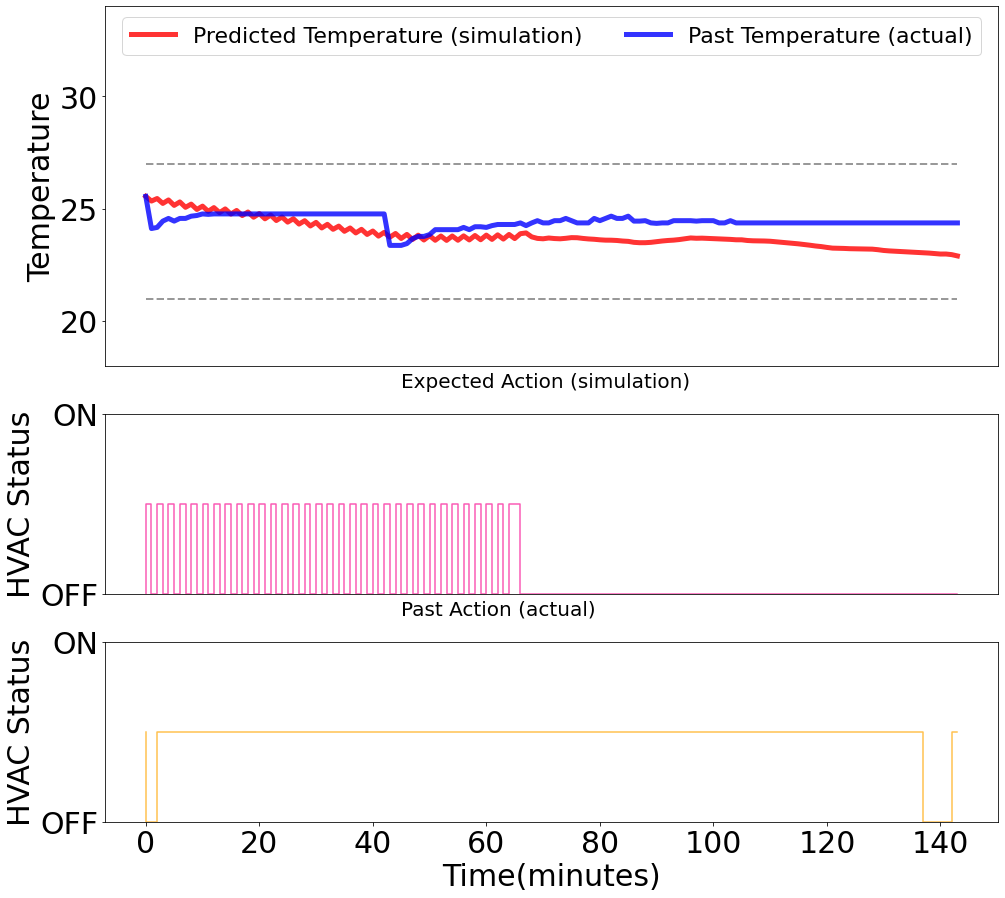

137.0
34
1 일 평균 절감율 :  75.18248175182481 실제 평균 온도 :  24.43333333333327 학습 평균 온도 :  23.850787765543295 오차율 :  0.5825455677899747
/raid/deallab/ecm/model_result/2019-08-31/20190831w7_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 24.37
[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
2019-08-31 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  35 실제 평균 온도 :  23.26999999999999 학습 평균 온도 :  23.23317132362949


<Figure size 432x288 with 0 Axes>

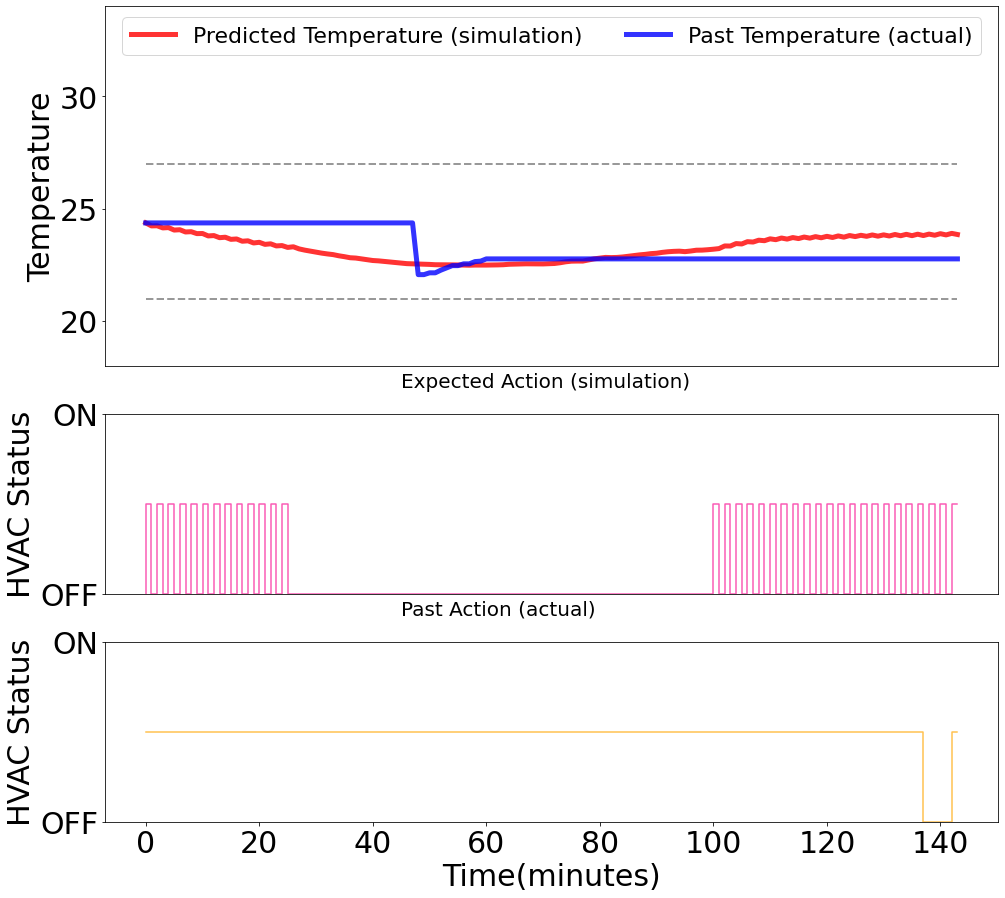

139.0
35
1 일 평균 절감율 :  74.82014388489209 실제 평균 온도 :  23.26999999999999 학습 평균 온도 :  23.23317132362949 오차율 :  0.03682867637049725
/raid/deallab/ecm/model_result/2019-09-01/20190901w7_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 22.77
[0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
2019-09-01 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  49 실제 평균 온도 :  22.769999999999985 학습 평균 온도 :  23.512655392262435


<Figure size 432x288 with 0 Axes>

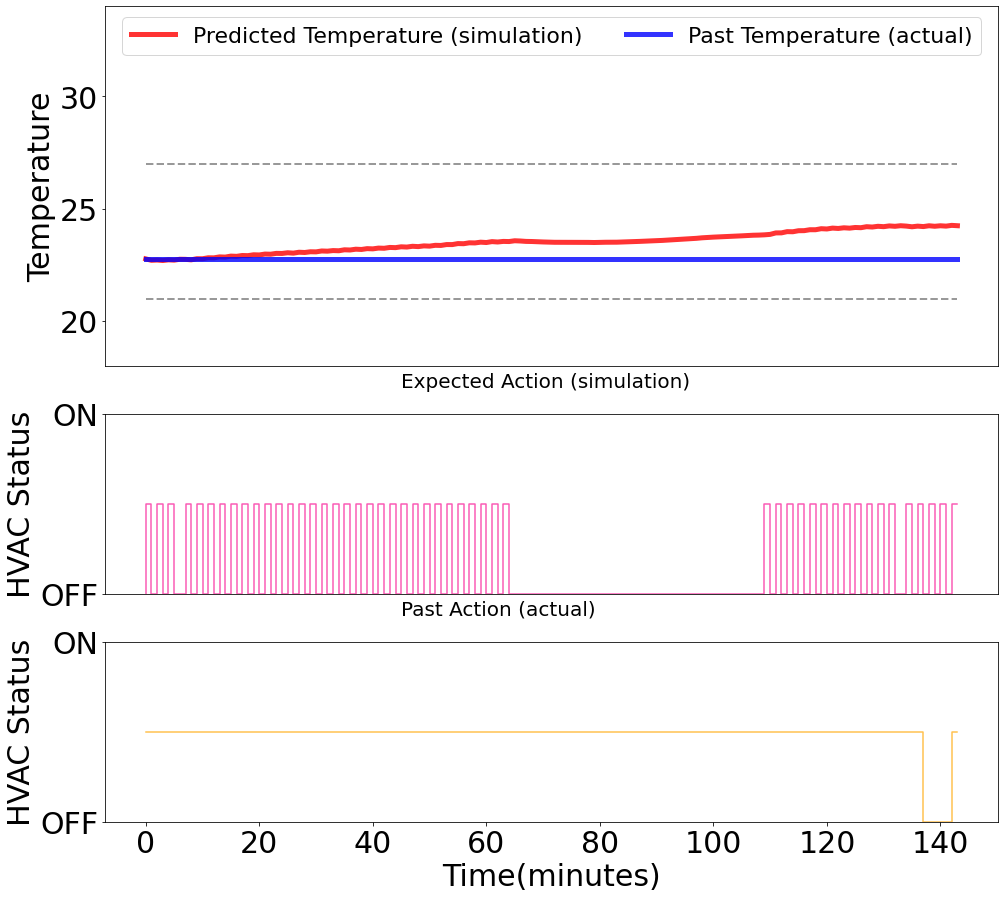

139.0
49
1 일 평균 절감율 :  64.74820143884892 실제 평균 온도 :  22.769999999999985 학습 평균 온도 :  23.512655392262435 오차율 :  -0.7426553922624493
/raid/deallab/ecm/model_result/2019-09-02/20190902w7_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 22.77
[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
2019-09-02 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  72 실제 평균 온도 :  23.638333333333335 학습 평균 온도 :  23.456595744037465


<Figure size 432x288 with 0 Axes>

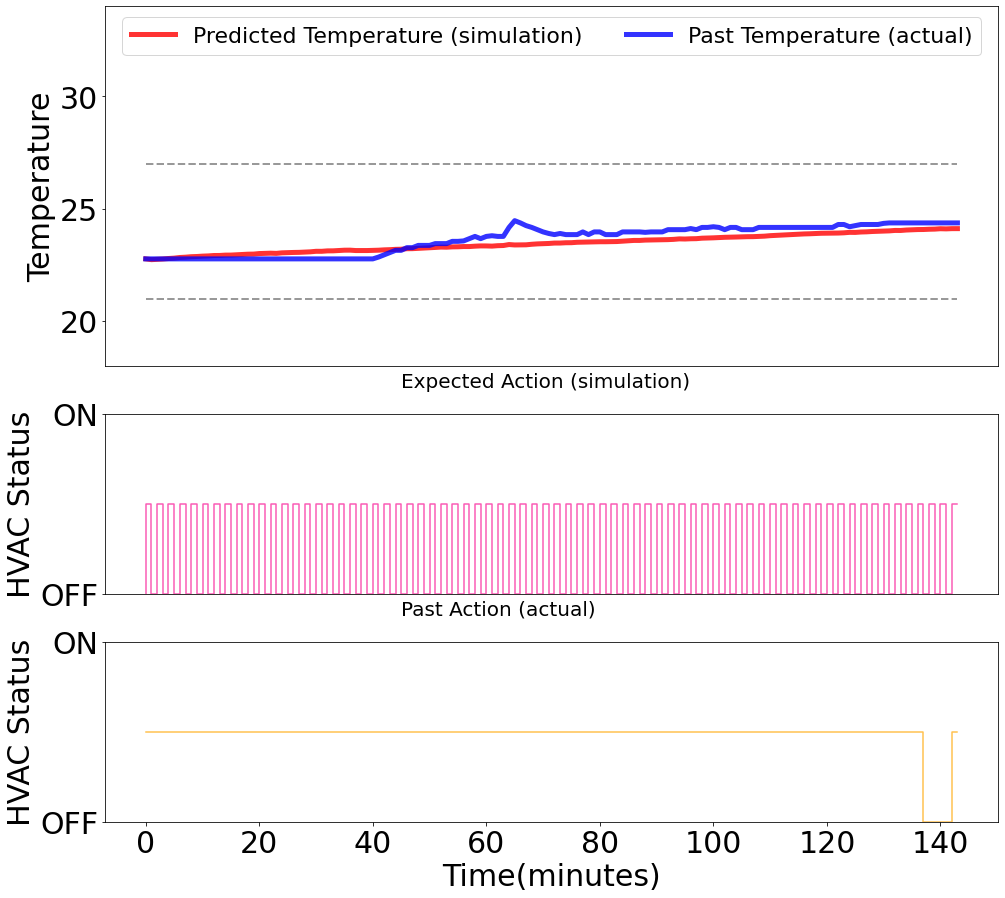

139.0
72
1 일 평균 절감율 :  48.201438848920866 실제 평균 온도 :  23.638333333333335 학습 평균 온도 :  23.456595744037465 오차율 :  0.1817375892958708
/raid/deallab/ecm/model_result/2019-09-03/20190903w7_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 24.37
[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
2019-09-03 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  72 실제 평균 온도 :  24.793124999999982 학습 평균 온도 :  24.76765255966386


<Figure size 432x288 with 0 Axes>

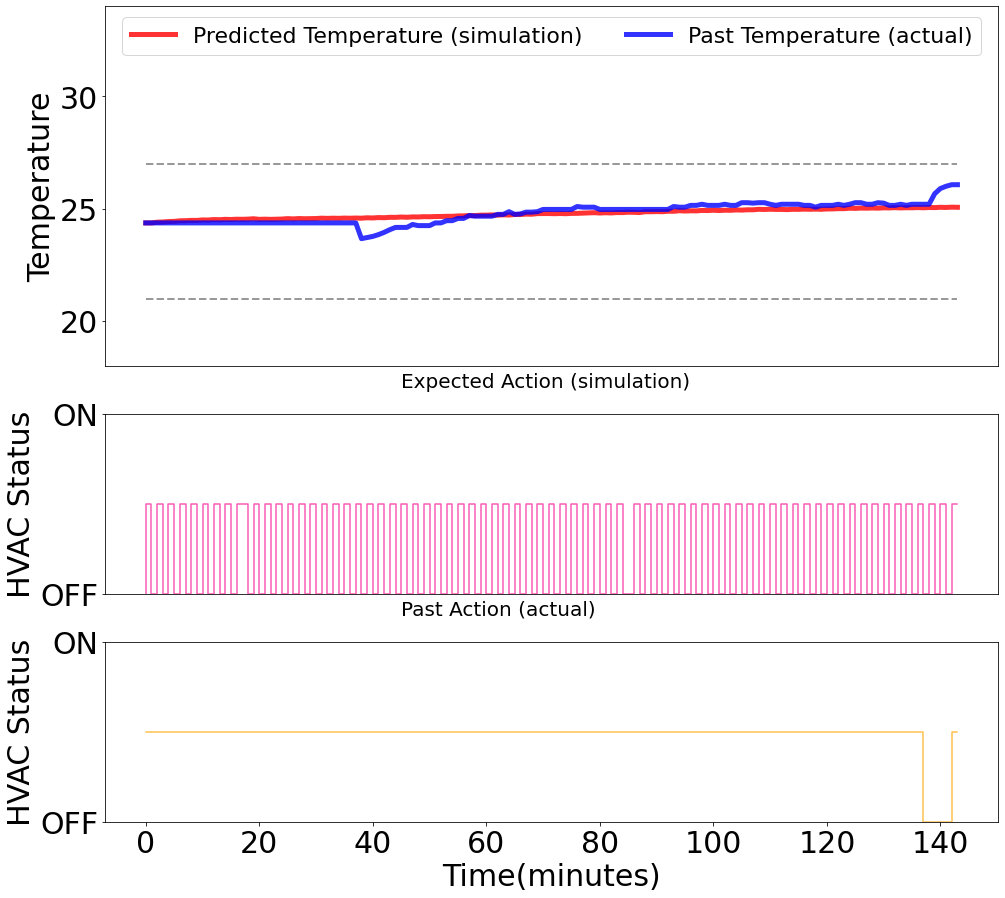

139.0
72
1 일 평균 절감율 :  48.201438848920866 실제 평균 온도 :  24.793124999999982 학습 평균 온도 :  24.76765255966386 오차율 :  0.025472440336123725
/raid/deallab/ecm/model_result/2019-09-04/20190904w7_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 26.07
[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
2019-09-04 실제 데이터 길이 :  144  : real action :  130.0 , expected action :  73 실제 평균 온도 :  26.05597222222217 학습 평균 온도 :  25.631478970279385


<Figure size 432x288 with 0 Axes>

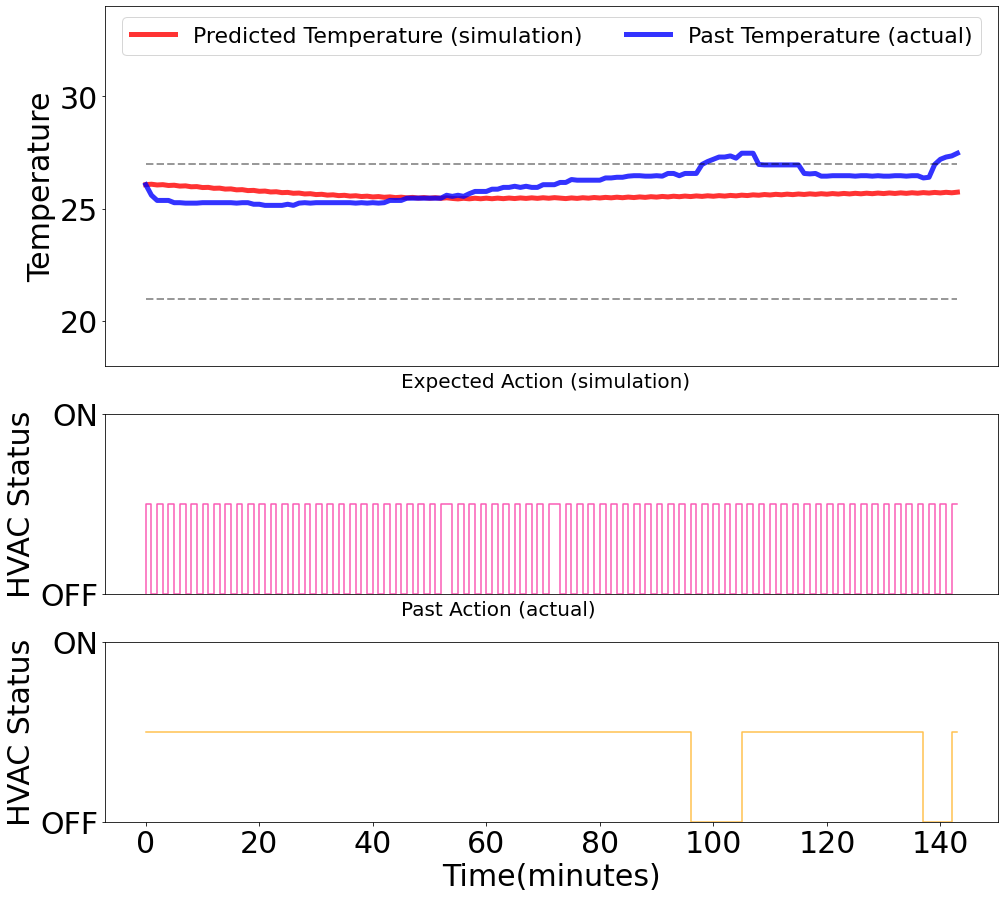

130.0
73
1 일 평균 절감율 :  43.84615384615385 실제 평균 온도 :  26.05597222222217 학습 평균 온도 :  25.631478970279385 오차율 :  0.42449325194278487
/raid/deallab/ecm/model_result/2019-09-05/20190905w14_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 27.37
[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
2019-09-05 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  71 실제 평균 온도 :  25.426458333333343 학습 평균 온도 :  27.764182350064026


<Figure size 432x288 with 0 Axes>

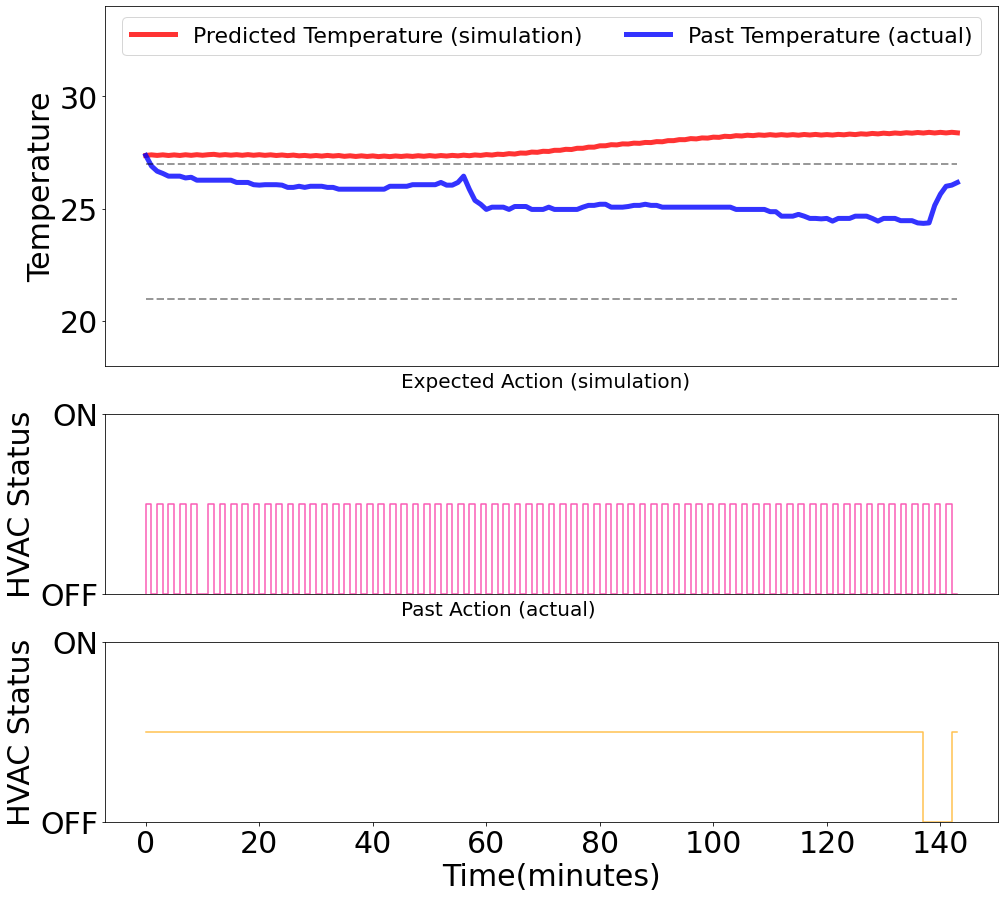

139.0
71
1 일 평균 절감율 :  48.92086330935252 실제 평균 온도 :  25.426458333333343 학습 평균 온도 :  27.764182350064026 오차율 :  -2.3377240167306823
/raid/deallab/ecm/model_result/2019-09-06/20190906w14_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 26.17
[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-09-06 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  57 실제 평균 온도 :  24.405972222222196 학습 평균 온도 :  27.648975053913134


<Figure size 432x288 with 0 Axes>

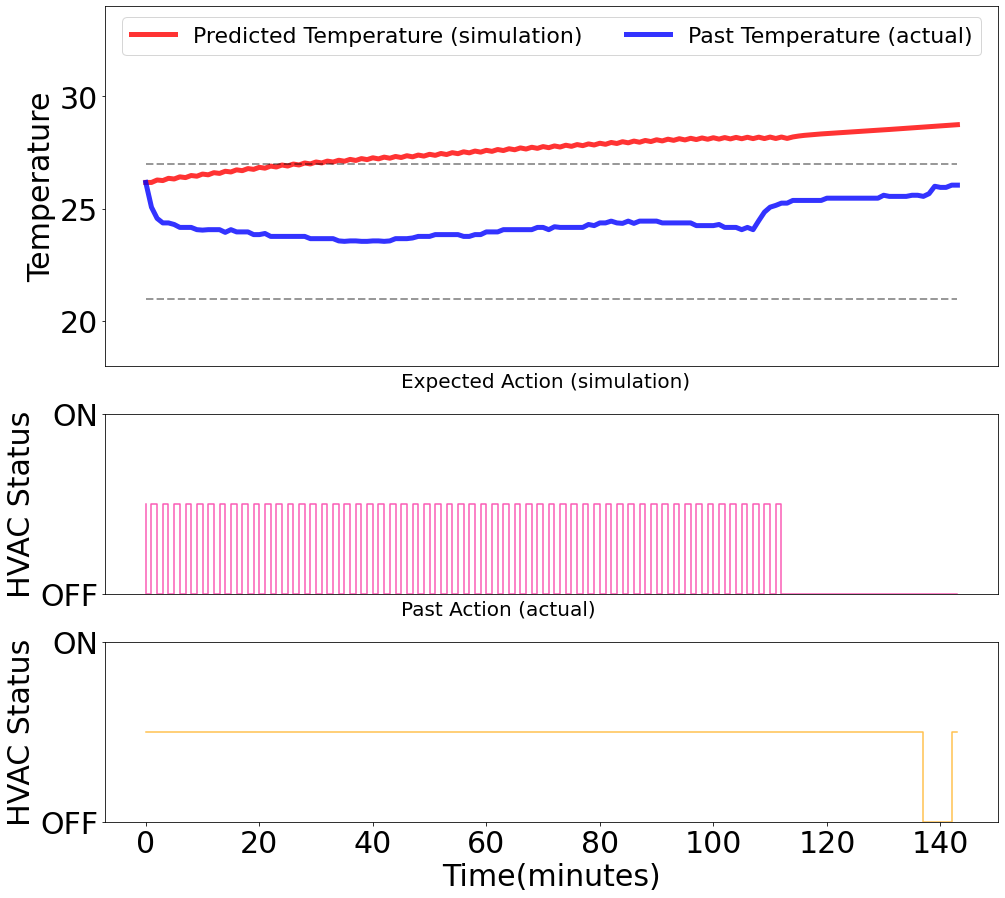

139.0
57
1 일 평균 절감율 :  58.992805755395686 실제 평균 온도 :  24.405972222222196 학습 평균 온도 :  27.648975053913134 오차율 :  -3.243002831690937
/raid/deallab/ecm/model_result/2019-09-07/20190907w7_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 25.95
[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
2019-09-07 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  72 실제 평균 온도 :  25.782152777777753 학습 평균 온도 :  27.349869604299126


<Figure size 432x288 with 0 Axes>

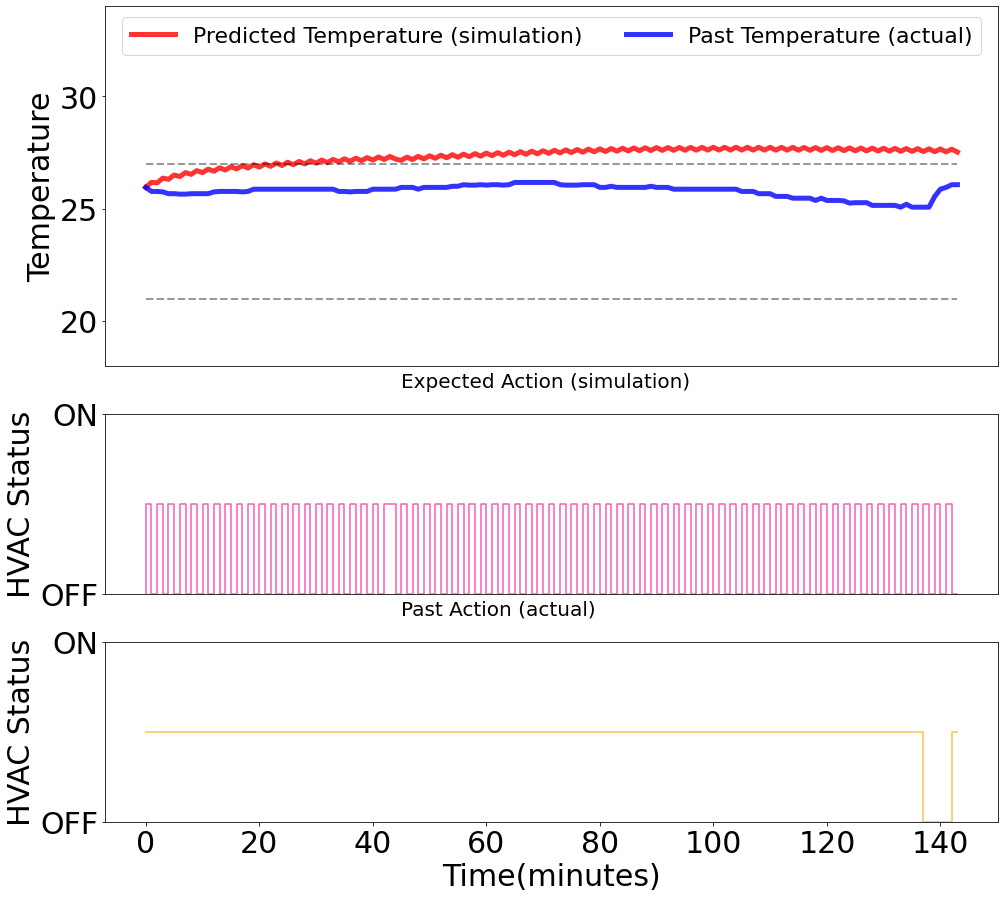

139.0
72
1 일 평균 절감율 :  48.201438848920866 실제 평균 온도 :  25.782152777777753 학습 평균 온도 :  27.349869604299126 오차율 :  -1.567716826521373
/raid/deallab/ecm/model_result/2019-09-08/20190908w14_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 26.05
[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
2019-09-08 실제 데이터 길이 :  144  : real action :  138.0 , expected action :  72 실제 평균 온도 :  25.039444444444403 학습 평균 온도 :  26.765342802163445


<Figure size 432x288 with 0 Axes>

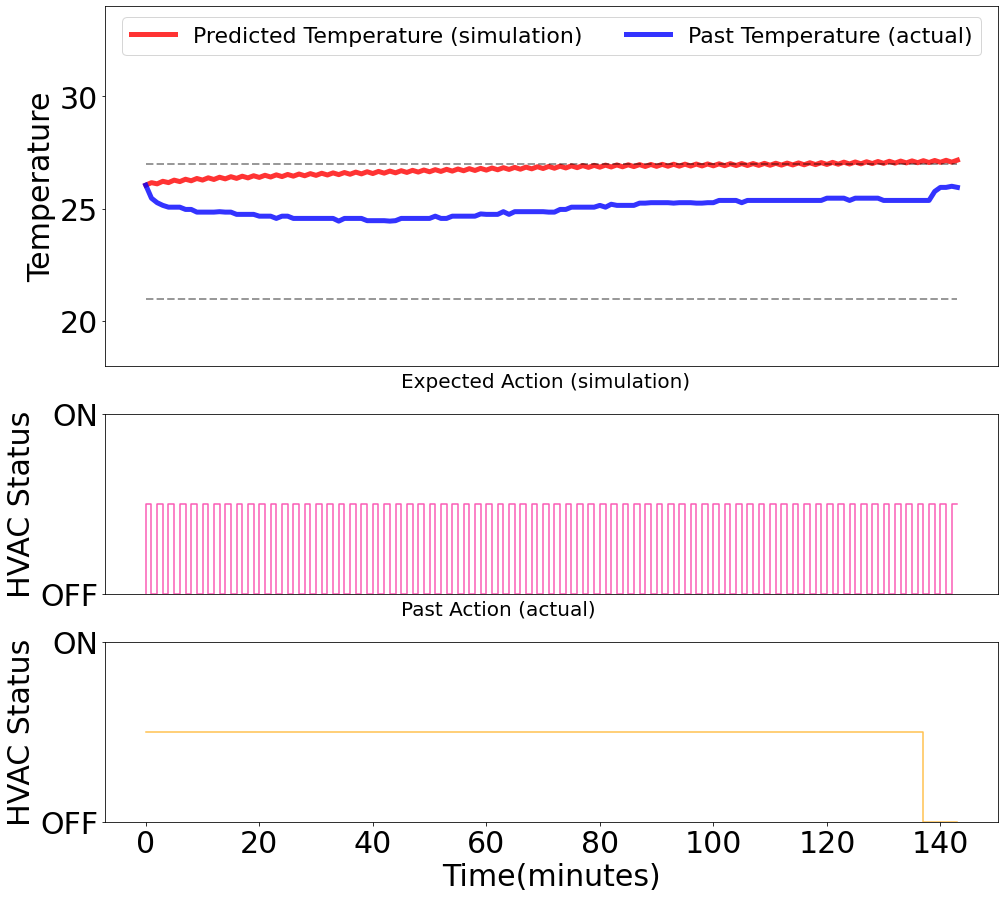

138.0
72
1 일 평균 절감율 :  47.82608695652174 실제 평균 온도 :  25.039444444444403 학습 평균 온도 :  26.765342802163445 오차율 :  -1.7258983577190428
/raid/deallab/ecm/model_result/2019-09-09/20190909w14_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 25.95
[1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
2019-09-09 실제 데이터 길이 :  144  : real action :  140.0 , expected action :  72 실제 평균 온도 :  25.180833333333325 학습 평균 온도 :  26.915946263643534


<Figure size 432x288 with 0 Axes>

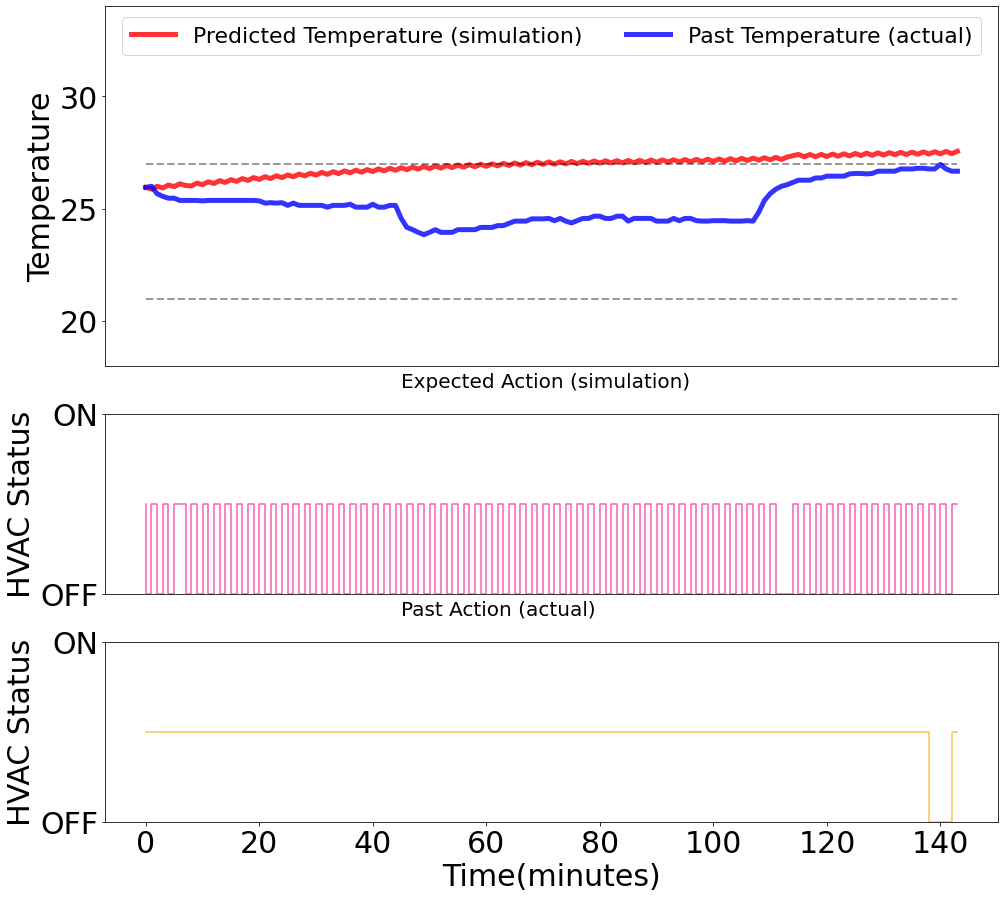

140.0
72
1 일 평균 절감율 :  48.57142857142857 실제 평균 온도 :  25.180833333333325 학습 평균 온도 :  26.915946263643534 오차율 :  -1.7351129303102084
/raid/deallab/ecm/model_result/2019-09-10/20190910w7_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 26.77
[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1]
2019-09-10 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  74 실제 평균 온도 :  25.288888888888867 학습 평균 온도 :  26.75216014841201


<Figure size 432x288 with 0 Axes>

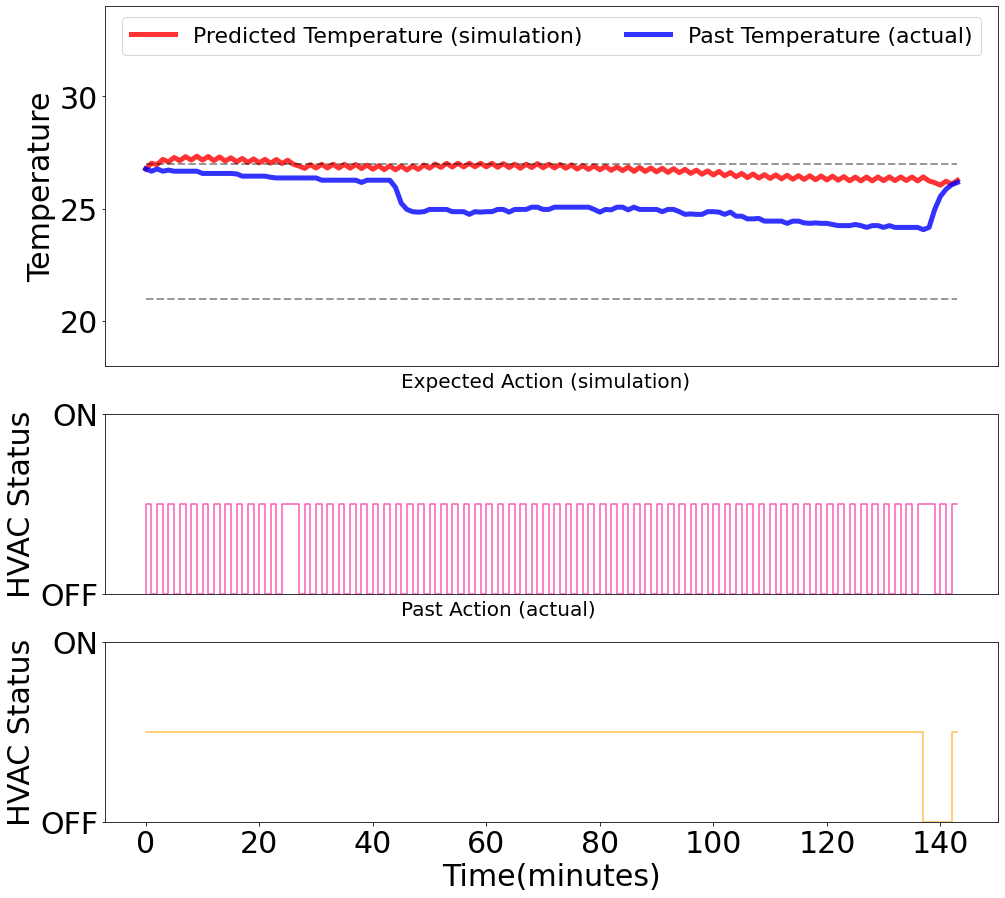

139.0
74
1 일 평균 절감율 :  46.76258992805755 실제 평균 온도 :  25.288888888888867 학습 평균 온도 :  26.75216014841201 오차율 :  -1.4632712595231432
/raid/deallab/ecm/model_result/2019-09-11/20190911w7_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 26.17
[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
2019-09-11 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  69 실제 평균 온도 :  24.302152777777774 학습 평균 온도 :  26.706479226730043


<Figure size 432x288 with 0 Axes>

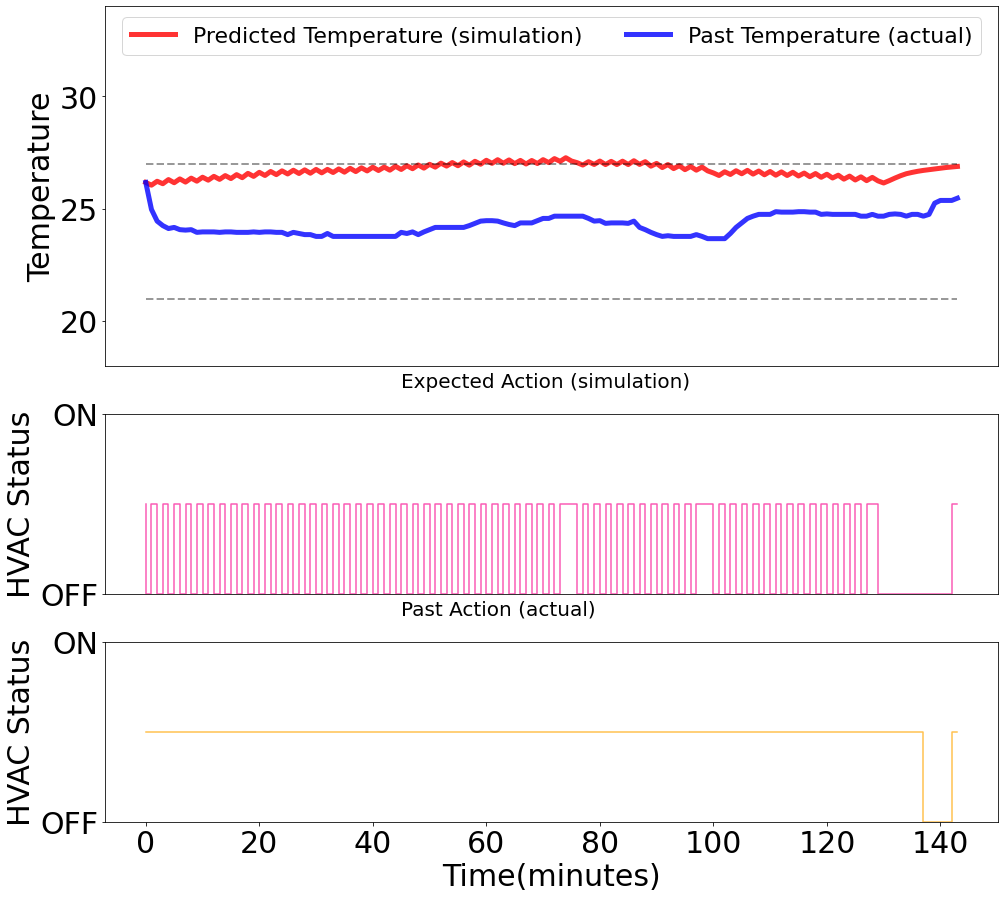

139.0
69
1 일 평균 절감율 :  50.35971223021583 실제 평균 온도 :  24.302152777777774 학습 평균 온도 :  26.706479226730043 오차율 :  -2.4043264489522684
/raid/deallab/ecm/model_result/2019-09-12/20190912w7_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 25.47
[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-09-12 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  27 실제 평균 온도 :  23.907569444444448 학습 평균 온도 :  25.588125724578664


<Figure size 432x288 with 0 Axes>

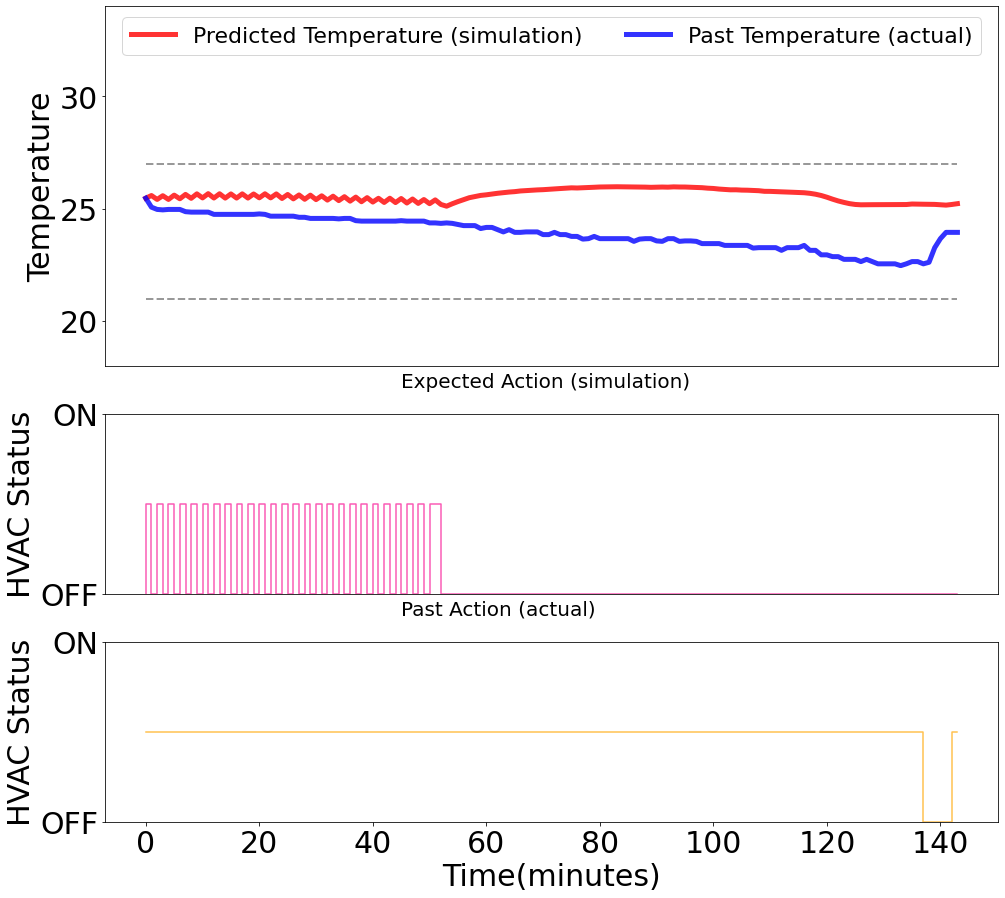

139.0
27
1 일 평균 절감율 :  80.57553956834532 실제 평균 온도 :  23.907569444444448 학습 평균 온도 :  25.588125724578664 오차율 :  -1.6805562801342155
/raid/deallab/ecm/model_result/2019-09-13/20190913w14_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 23.95
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-09-13 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  0 실제 평균 온도 :  22.905625000000043 학습 평균 온도 :  26.07264162850676


<Figure size 432x288 with 0 Axes>

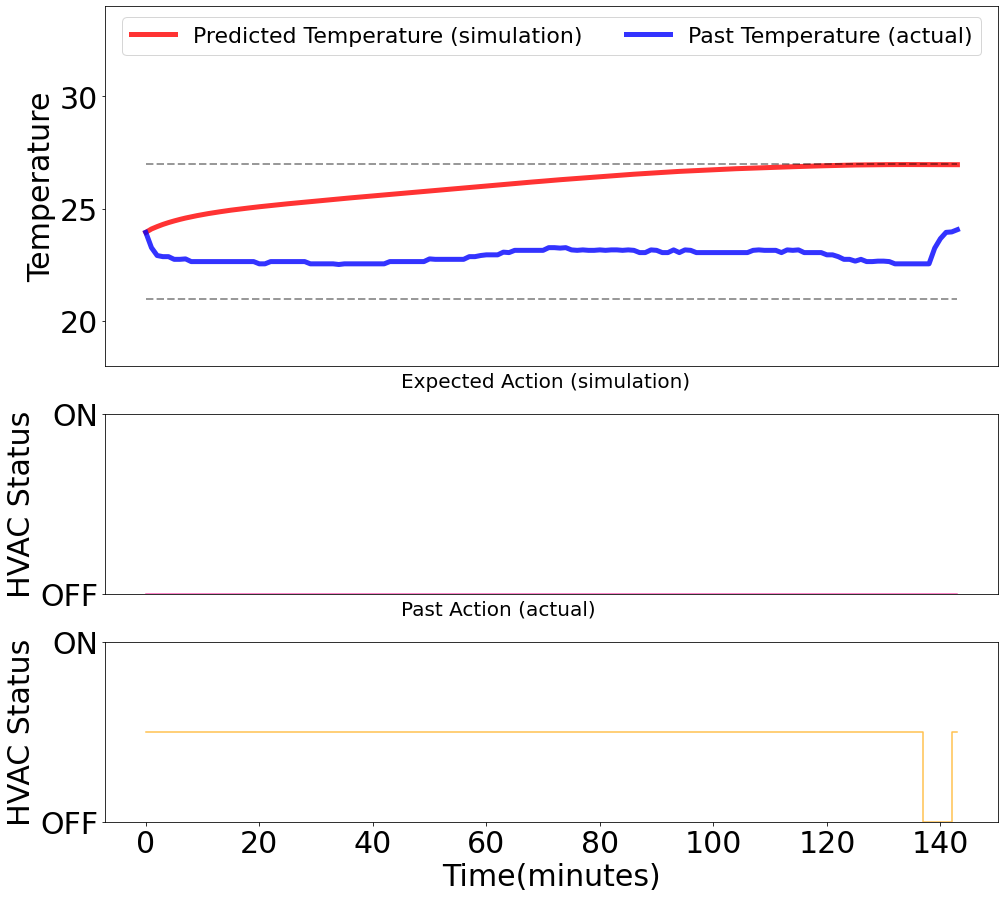

139.0
0
1 일 평균 절감율 :  100.0 실제 평균 온도 :  22.905625000000043 학습 평균 온도 :  26.07264162850676 오차율 :  -3.1670166285067154
/raid/deallab/ecm/model_result/2019-09-14/20190914w7_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 23.97
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
2019-09-14 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  17 실제 평균 온도 :  23.40687499999999 학습 평균 온도 :  25.48336104441748


<Figure size 432x288 with 0 Axes>

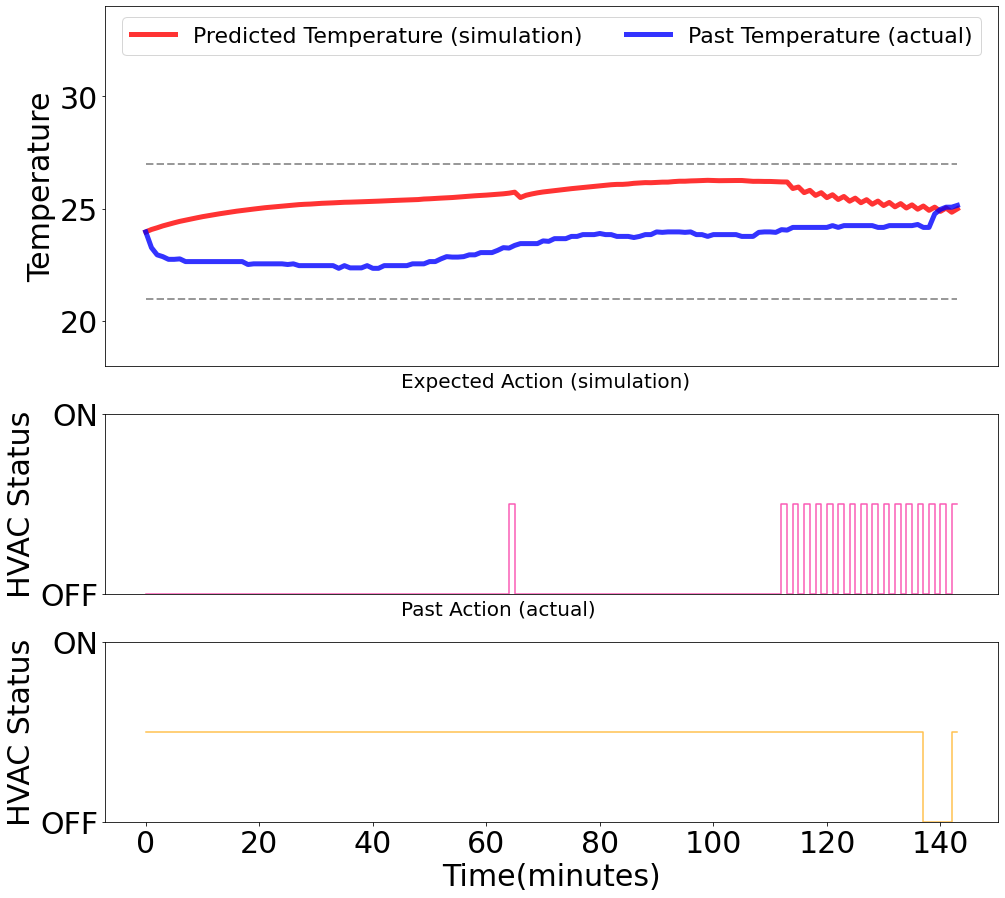

139.0
17
1 일 평균 절감율 :  87.76978417266187 실제 평균 온도 :  23.40687499999999 학습 평균 온도 :  25.48336104441748 오차율 :  -2.076486044417493
/raid/deallab/ecm/model_result/2019-09-15/20190915w14_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 25.15
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-09-15 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  4 실제 평균 온도 :  24.792361111111124 학습 평균 온도 :  27.678783874013185


<Figure size 432x288 with 0 Axes>

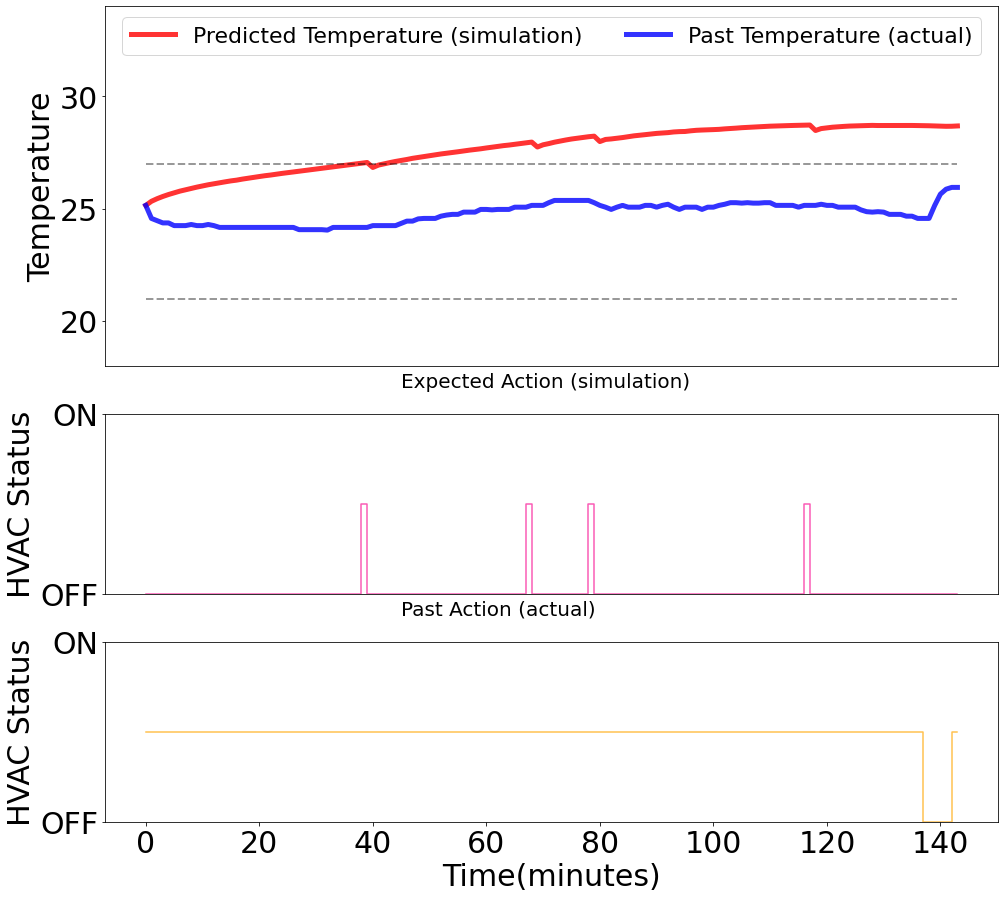

139.0
4
1 일 평균 절감율 :  97.12230215827337 실제 평균 온도 :  24.792361111111124 학습 평균 온도 :  27.678783874013185 오차율 :  -2.886422762902061
/raid/deallab/ecm/model_result/2019-09-16/20190916w14_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 25.87
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-09-16 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  1 실제 평균 온도 :  23.038611111111102 학습 평균 온도 :  27.232947509148225


<Figure size 432x288 with 0 Axes>

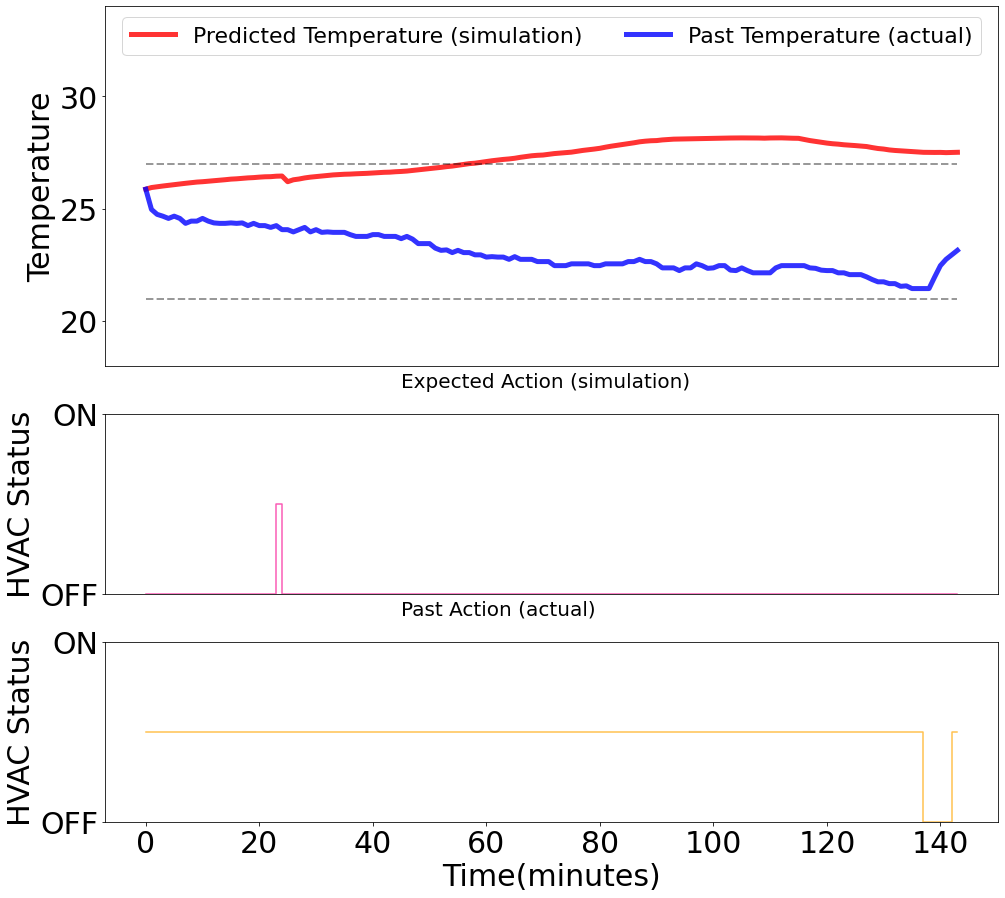

139.0
1
1 일 평균 절감율 :  99.28057553956835 실제 평균 온도 :  23.038611111111102 학습 평균 온도 :  27.232947509148225 오차율 :  -4.194336398037123
/raid/deallab/ecm/model_result/2019-09-17/20190917w14_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 22.95
[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-09-17 실제 데이터 길이 :  144  : real action :  106.0 , expected action :  7 실제 평균 온도 :  20.71111111111105 학습 평균 온도 :  26.472246985364986


<Figure size 432x288 with 0 Axes>

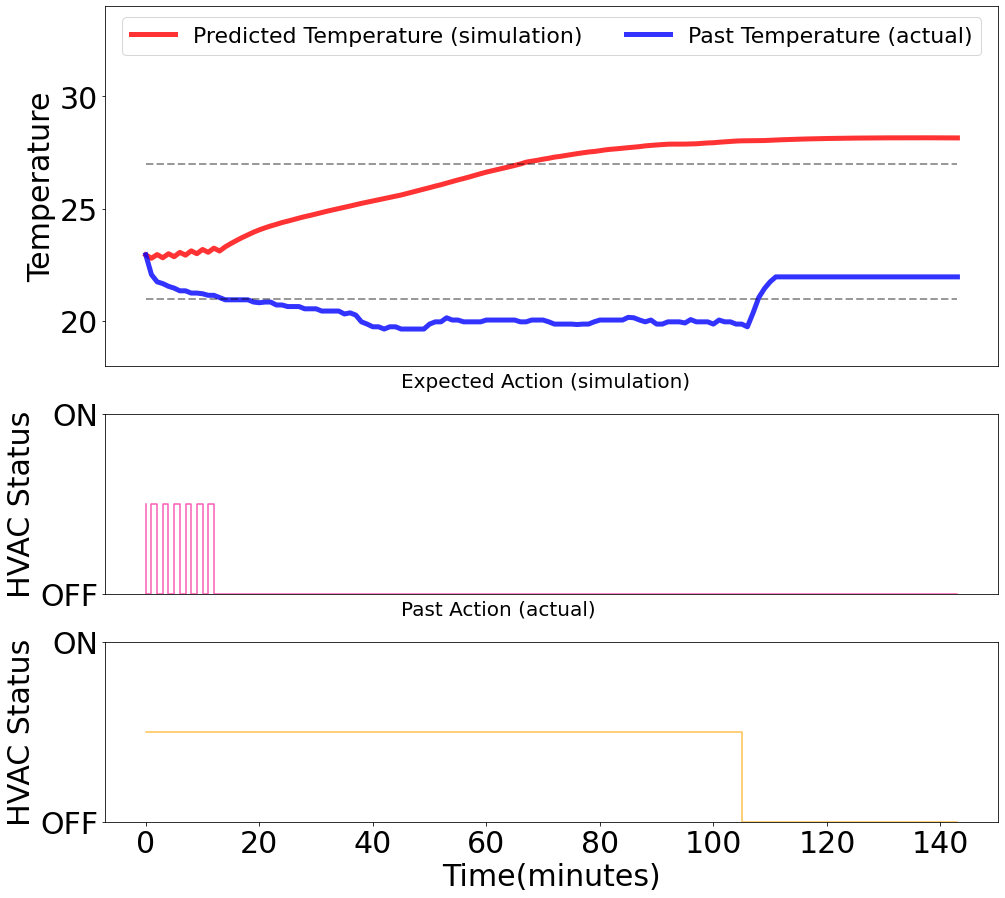

106.0
7
1 일 평균 절감율 :  93.39622641509435 실제 평균 온도 :  20.71111111111105 학습 평균 온도 :  26.472246985364986 오차율 :  -5.7611358742539345
/raid/deallab/ecm/model_result/2019-09-18/20190918w1_linear_regression.joblib
F_SET_MODE_0
Reset data f3_temp : 21.97
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
2019-09-18 실제 데이터 길이 :  144  : real action :  98.0 , expected action :  83 실제 평균 온도 :  21.58861111111112 학습 평균 온도 :  20.735822419252578


<Figure size 432x288 with 0 Axes>

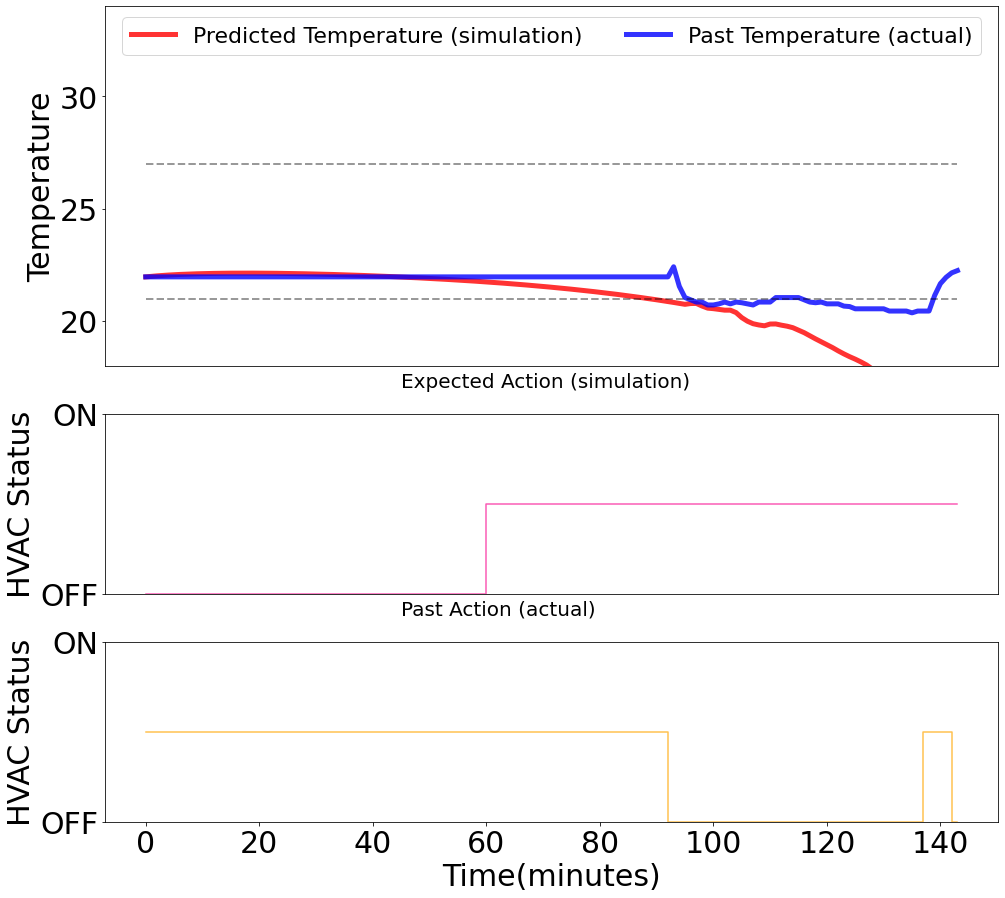

98.0
83
1 일 평균 절감율 :  15.306122448979592 실제 평균 온도 :  21.58861111111112 학습 평균 온도 :  20.735822419252578 오차율 :  0.8527886918585423
/raid/deallab/ecm/model_result/2019-09-19/20190919w14_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 22.07
[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-09-19 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  17 실제 평균 온도 :  20.312569444444435 학습 평균 온도 :  22.81614718735376


<Figure size 432x288 with 0 Axes>

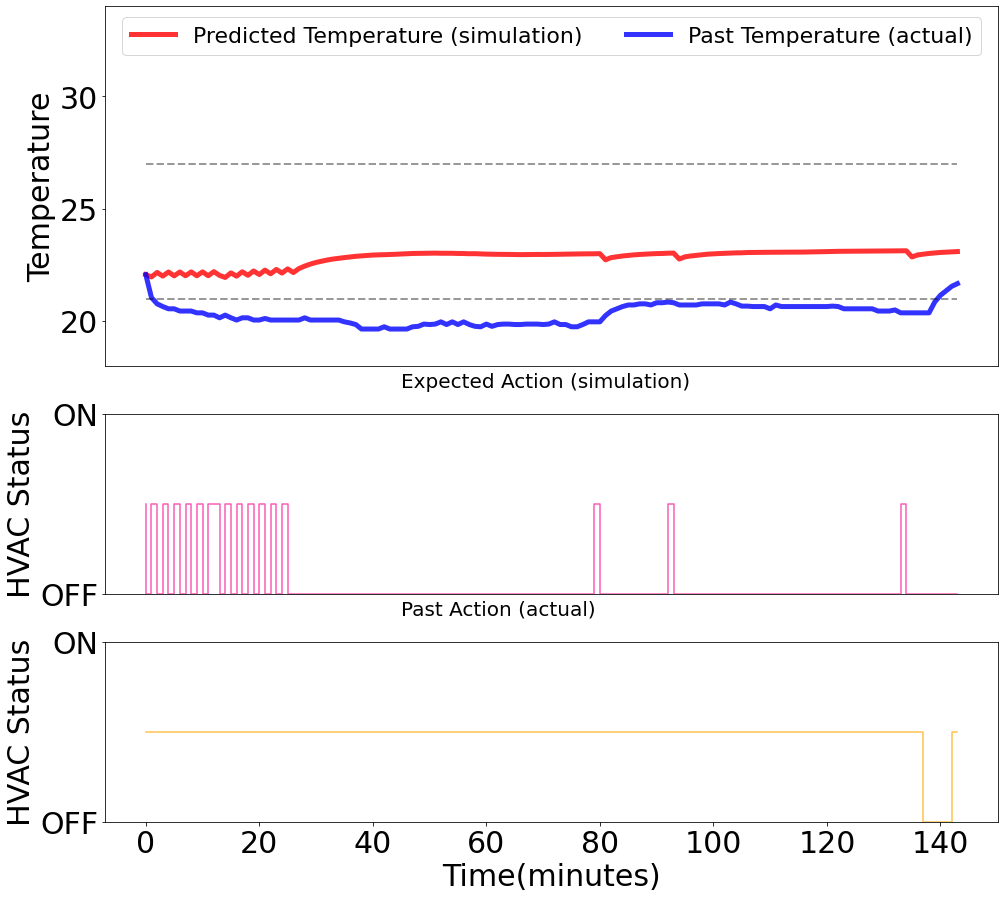

139.0
17
1 일 평균 절감율 :  87.76978417266187 실제 평균 온도 :  20.312569444444435 학습 평균 온도 :  22.81614718735376 오차율 :  -2.503577742909325
/raid/deallab/ecm/model_result/2019-09-20/20190920w7_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 21.55
[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
2019-09-20 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  4 실제 평균 온도 :  20.338472222222222 학습 평균 온도 :  23.377212113086962


<Figure size 432x288 with 0 Axes>

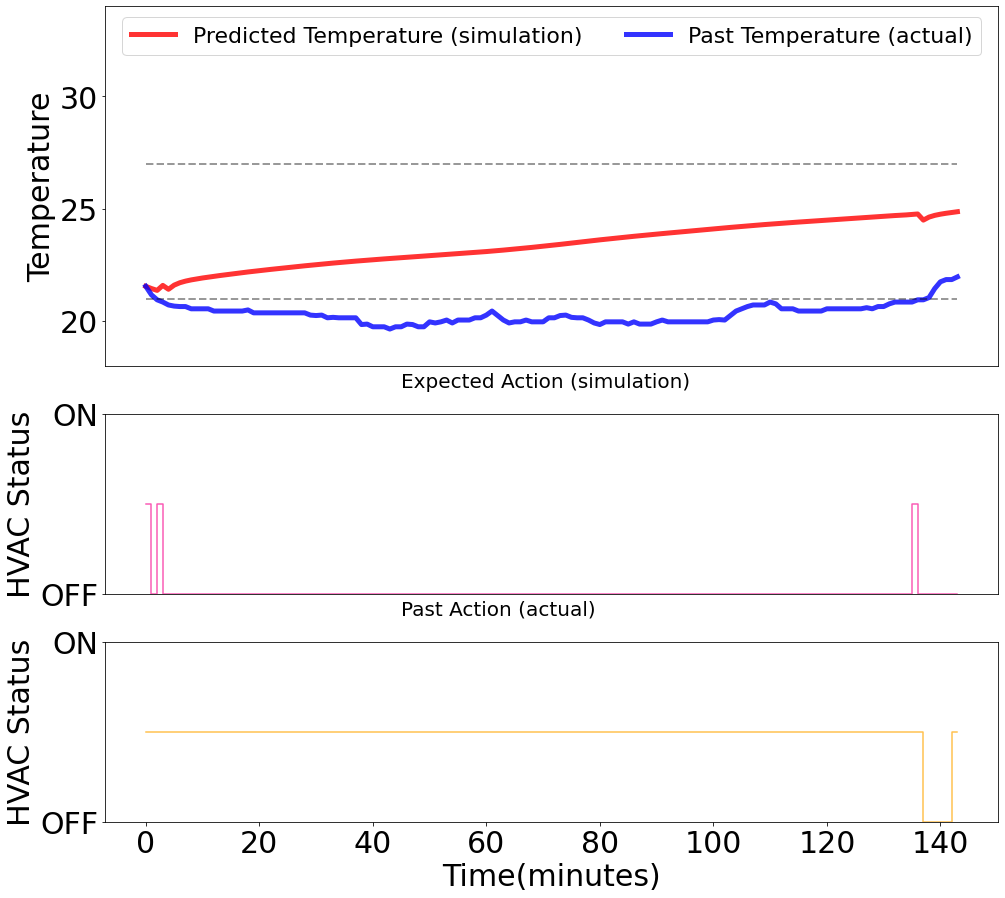

139.0
4
1 일 평균 절감율 :  97.12230215827337 실제 평균 온도 :  20.338472222222222 학습 평균 온도 :  23.377212113086962 오차율 :  -3.03873989086474
/raid/deallab/ecm/model_result/2019-09-21/20190921w14_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 21.85
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-09-21 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  1 실제 평균 온도 :  21.357361111111096 학습 평균 온도 :  24.06277559712617


<Figure size 432x288 with 0 Axes>

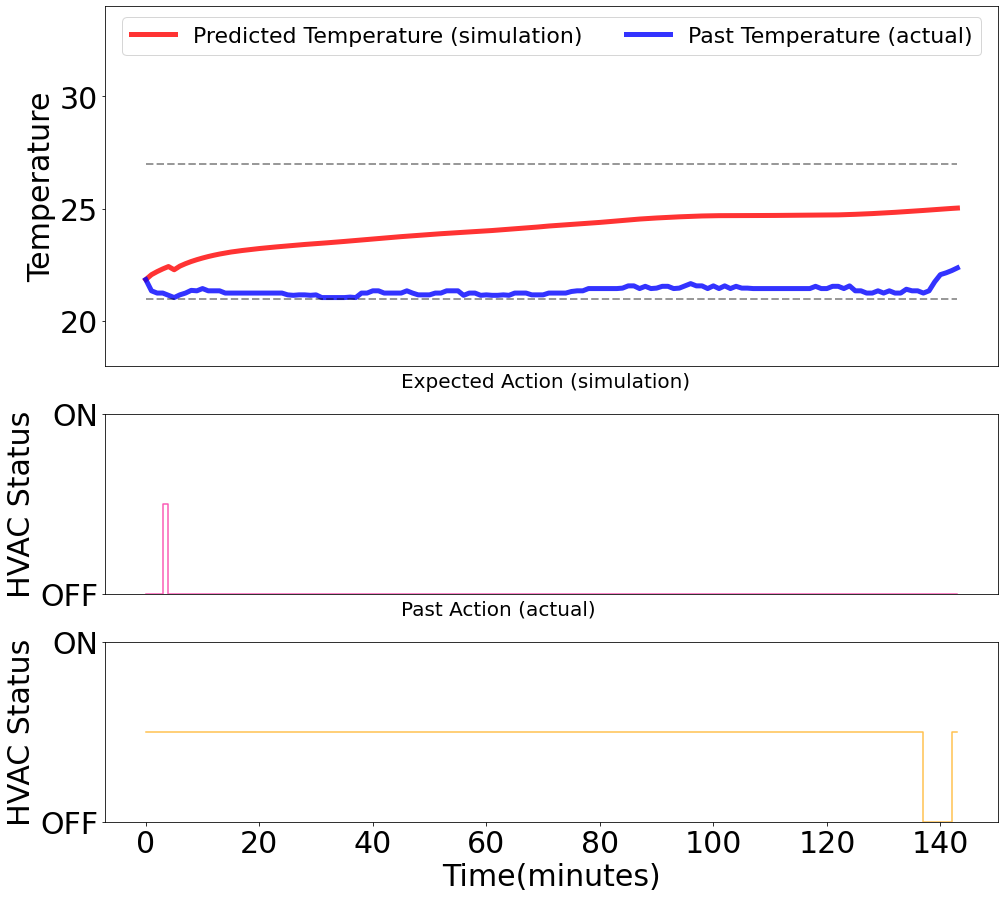

139.0
1
1 일 평균 절감율 :  99.28057553956835 실제 평균 온도 :  21.357361111111096 학습 평균 온도 :  24.06277559712617 오차율 :  -2.705414486015073
/raid/deallab/ecm/model_result/2019-09-22/20190922w30_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 22.15
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-09-22 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  1 실제 평균 온도 :  21.800625000000032 학습 평균 온도 :  24.903212870759564


<Figure size 432x288 with 0 Axes>

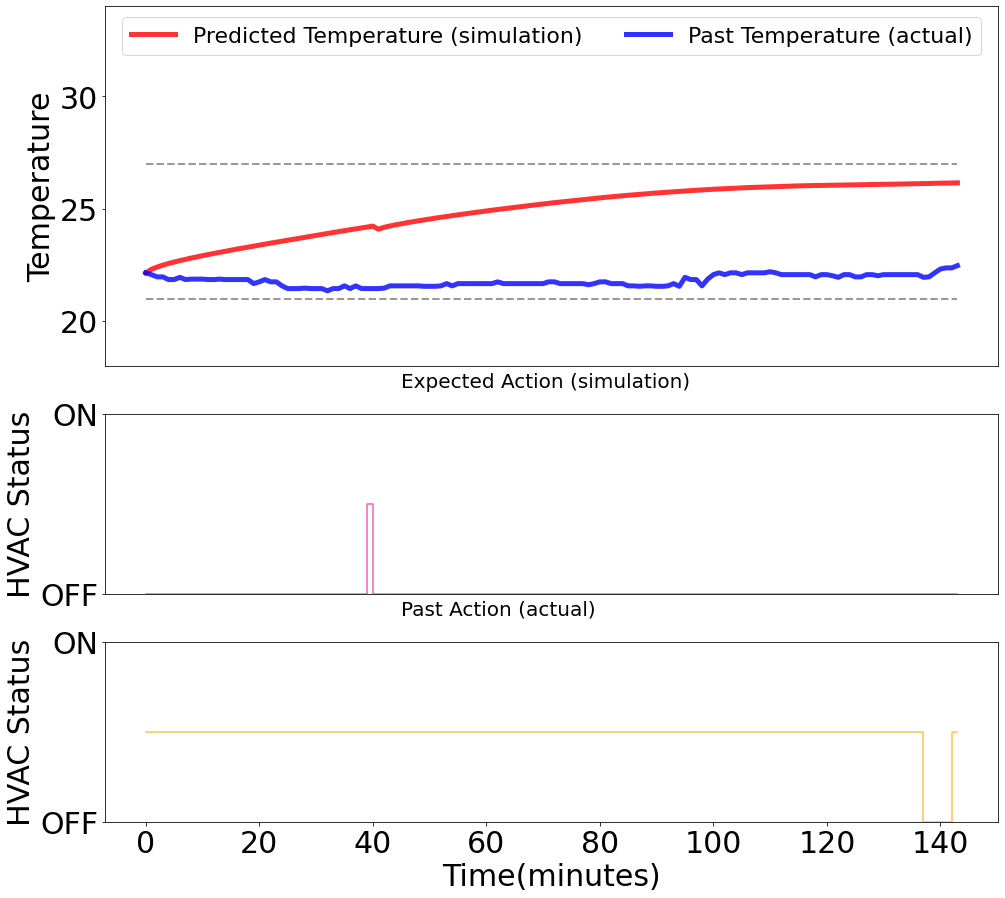

139.0
1
1 일 평균 절감율 :  99.28057553956835 실제 평균 온도 :  21.800625000000032 학습 평균 온도 :  24.903212870759564 오차율 :  -3.102587870759532
/raid/deallab/ecm/model_result/2019-09-23/20190923w30_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 22.25
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-09-23 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  1 실제 평균 온도 :  21.74673611111113 학습 평균 온도 :  23.91655418800208


<Figure size 432x288 with 0 Axes>

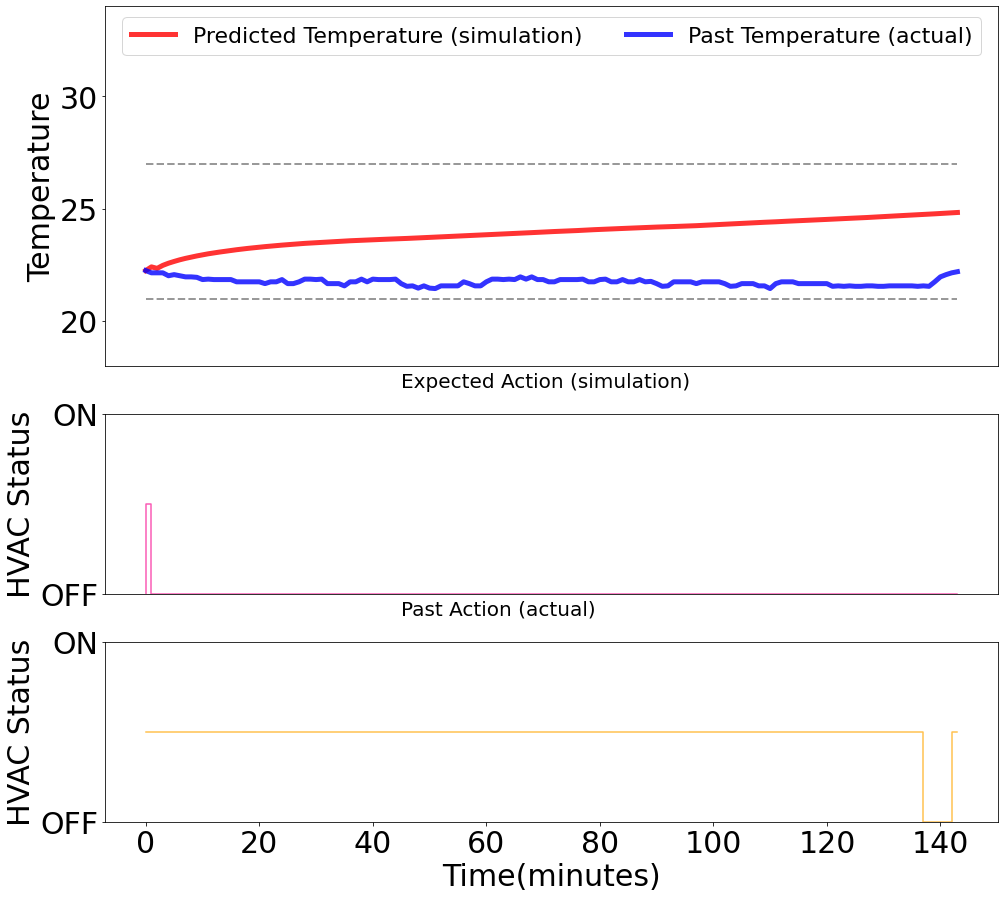

139.0
1
1 일 평균 절감율 :  99.28057553956835 실제 평균 온도 :  21.74673611111113 학습 평균 온도 :  23.91655418800208 오차율 :  -2.1698180768909516
/raid/deallab/ecm/model_result/2019-09-24/20190924w7_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 21.97
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-09-24 실제 데이터 길이 :  144  : real action :  138.0 , expected action :  1 실제 평균 온도 :  21.069166666666646 학습 평균 온도 :  23.181926169928616


<Figure size 432x288 with 0 Axes>

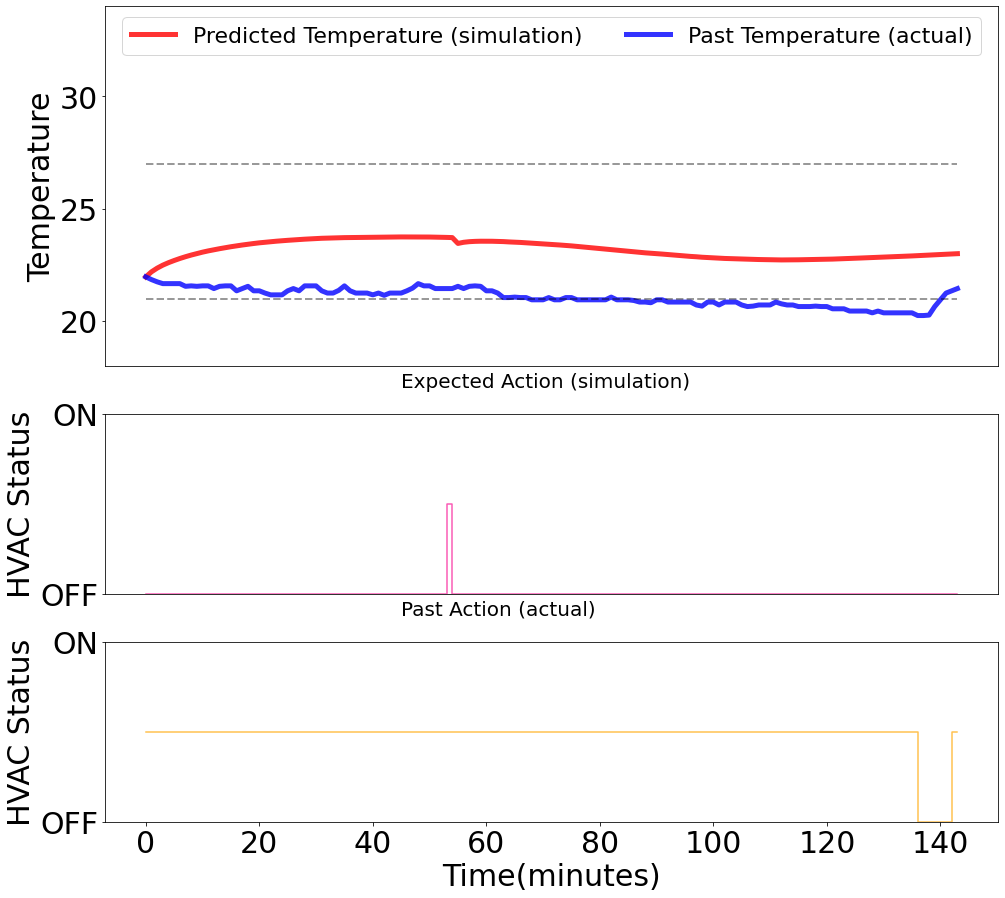

138.0
1
1 일 평균 절감율 :  99.27536231884058 실제 평균 온도 :  21.069166666666646 학습 평균 온도 :  23.181926169928616 오차율 :  -2.1127595032619695
/raid/deallab/ecm/model_result/2019-09-25/20190925w14_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 21.25
[0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
2019-09-25 실제 데이터 길이 :  144  : real action :  138.0 , expected action :  25 실제 평균 온도 :  19.939027777777756 학습 평균 온도 :  22.477247144633914


<Figure size 432x288 with 0 Axes>

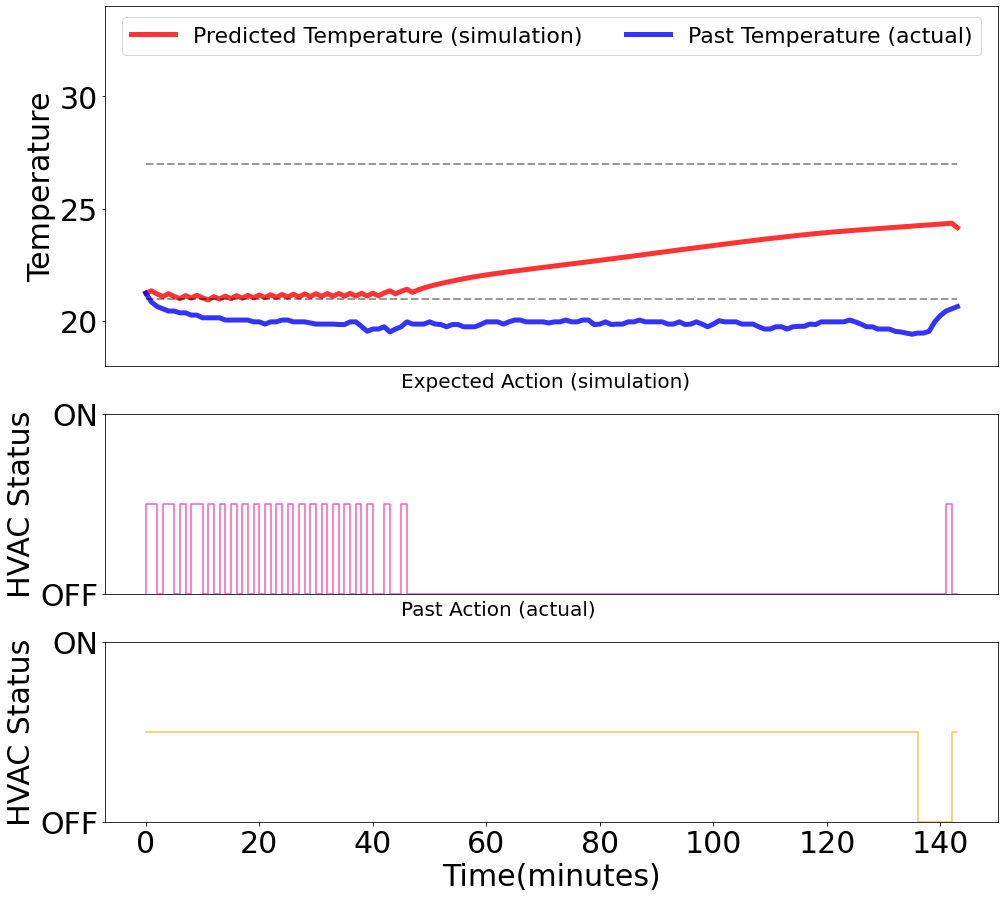

138.0
25
1 일 평균 절감율 :  81.88405797101449 실제 평균 온도 :  19.939027777777756 학습 평균 온도 :  22.477247144633914 오차율 :  -2.5382193668561577
/raid/deallab/ecm/model_result/2019-09-26/20190926w7_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 20.45
[1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-09-26 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  29 실제 평균 온도 :  19.976111111111123 학습 평균 온도 :  23.131474363021923


<Figure size 432x288 with 0 Axes>

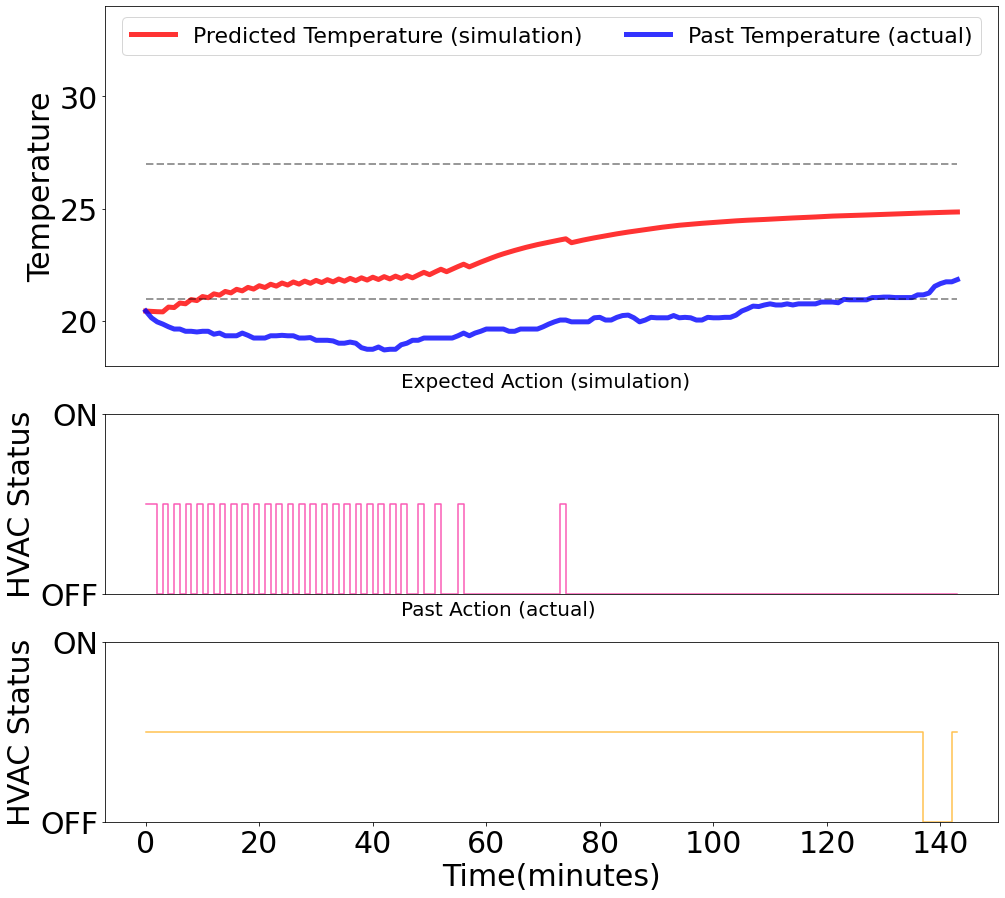

139.0
29
1 일 평균 절감율 :  79.13669064748201 실제 평균 온도 :  19.976111111111123 학습 평균 온도 :  23.131474363021923 오차율 :  -3.1553632519107992
/raid/deallab/ecm/model_result/2019-09-27/20190927w14_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 21.67
[1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
2019-09-27 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  7 실제 평균 온도 :  21.957916666666677 학습 평균 온도 :  25.298566194216658


<Figure size 432x288 with 0 Axes>

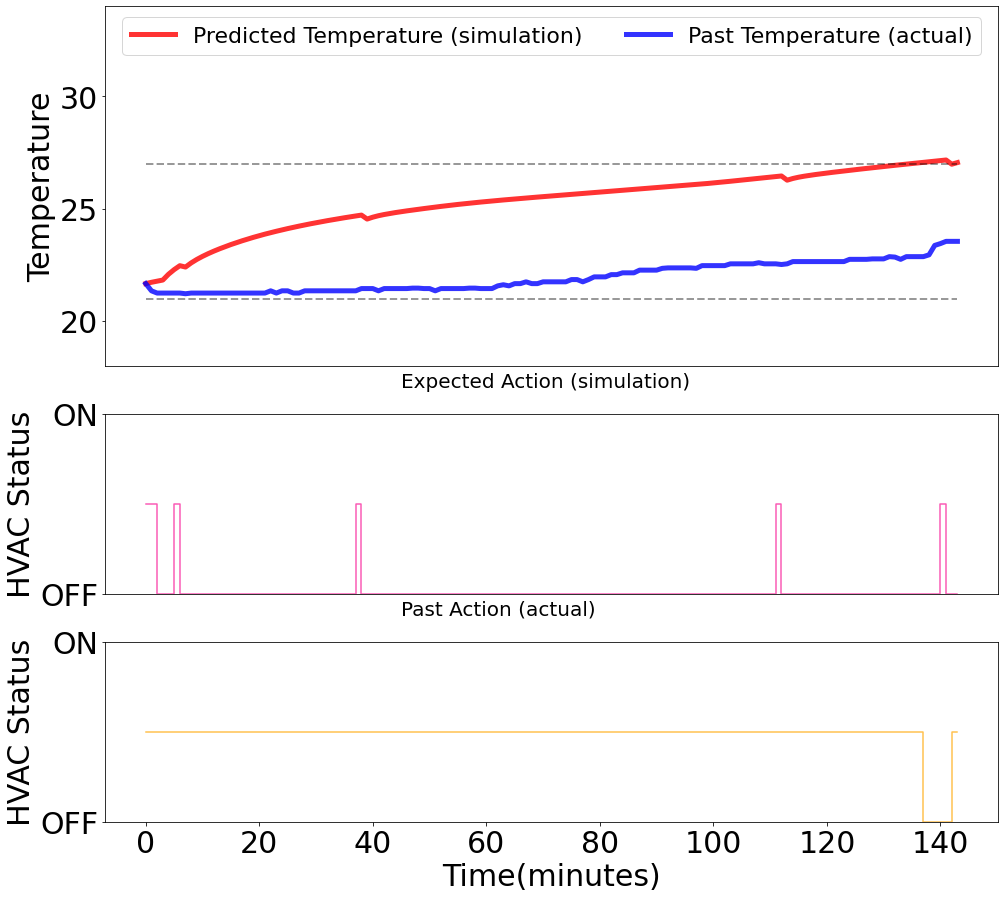

139.0
7
1 일 평균 절감율 :  94.96402877697841 실제 평균 온도 :  21.957916666666677 학습 평균 온도 :  25.298566194216658 오차율 :  -3.3406495275499815
/raid/deallab/ecm/model_result/2019-09-28/20190928w30_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 23.45
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-09-28 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  3 실제 평균 온도 :  23.78881944444445 학습 평균 온도 :  26.771234491666277


<Figure size 432x288 with 0 Axes>

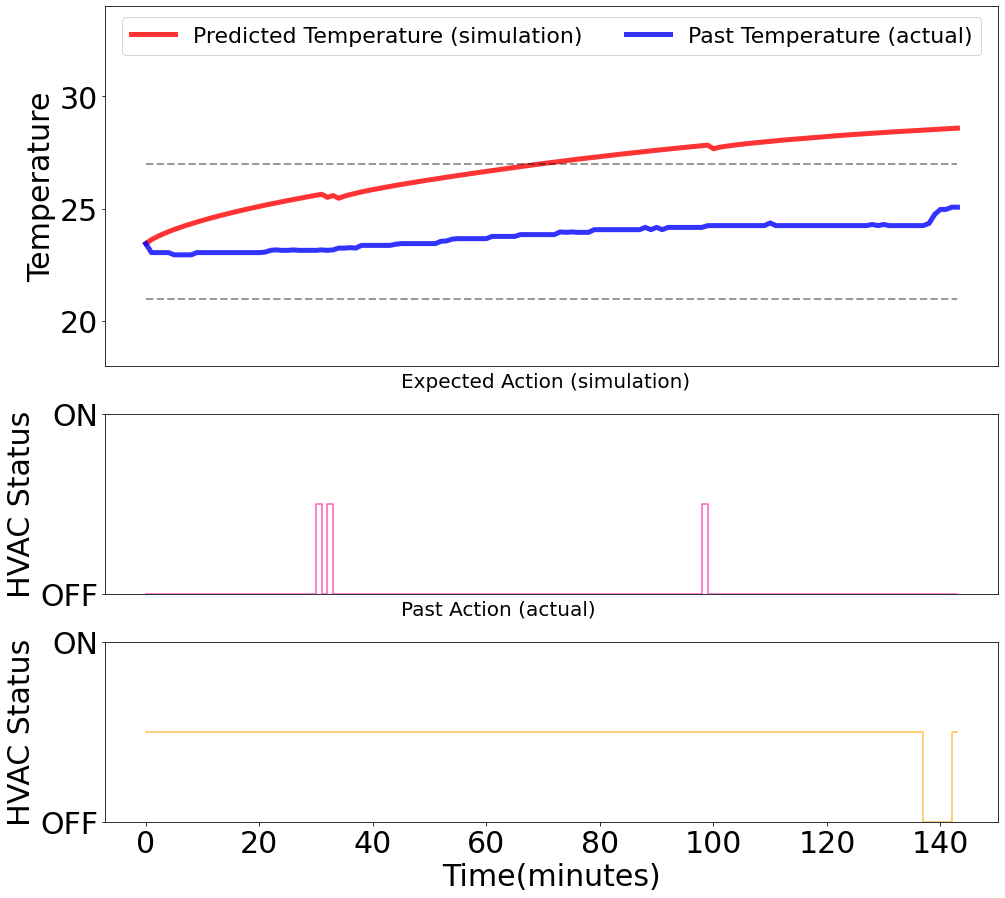

139.0
3
1 일 평균 절감율 :  97.84172661870504 실제 평균 온도 :  23.78881944444445 학습 평균 온도 :  26.771234491666277 오차율 :  -2.982415047221828
/raid/deallab/ecm/model_result/2019-09-29/20190929w1_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 24.87
[0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
2019-09-29 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  71 실제 평균 온도 :  24.81729166666667 학습 평균 온도 :  25.15021438482191


<Figure size 432x288 with 0 Axes>

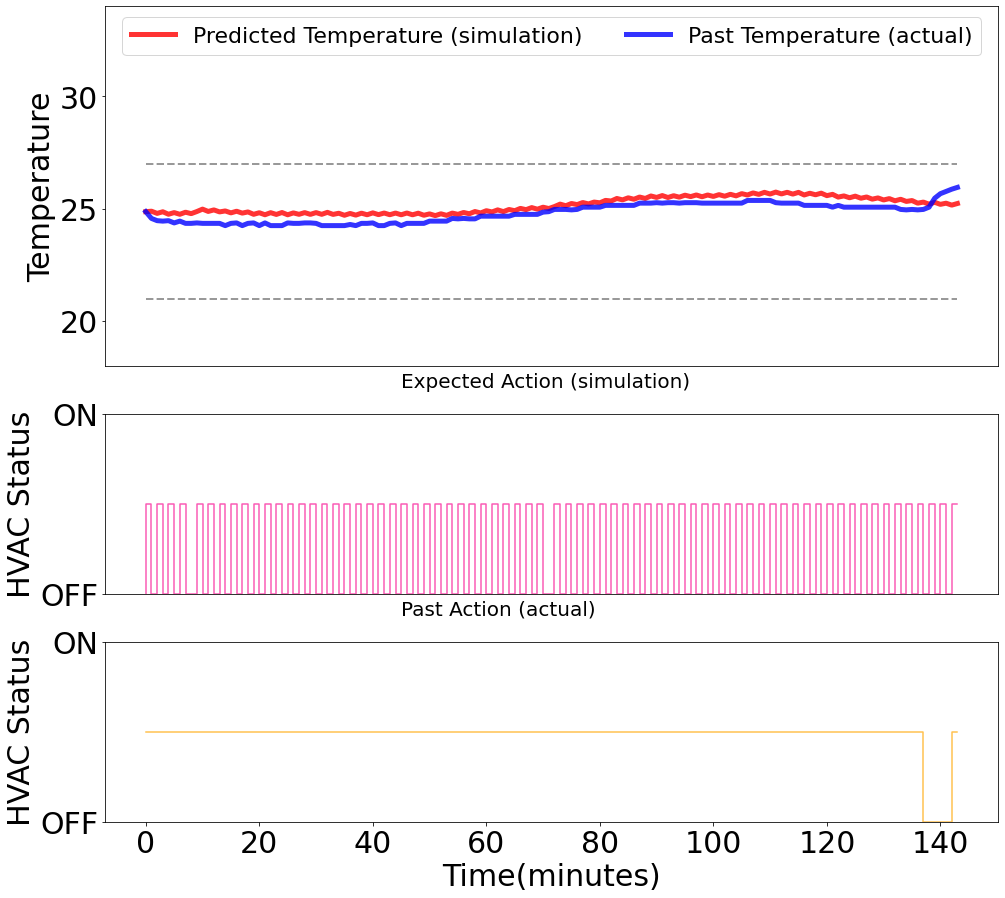

139.0
71
1 일 평균 절감율 :  48.92086330935252 실제 평균 온도 :  24.81729166666667 학습 평균 온도 :  25.15021438482191 오차율 :  -0.3329227181552419
/raid/deallab/ecm/model_result/2019-09-30/20190930w7_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 25.65
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-09-30 실제 데이터 길이 :  144  : real action :  138.0 , expected action :  0 실제 평균 온도 :  24.941805555555547 학습 평균 온도 :  31.46427819635879


<Figure size 432x288 with 0 Axes>

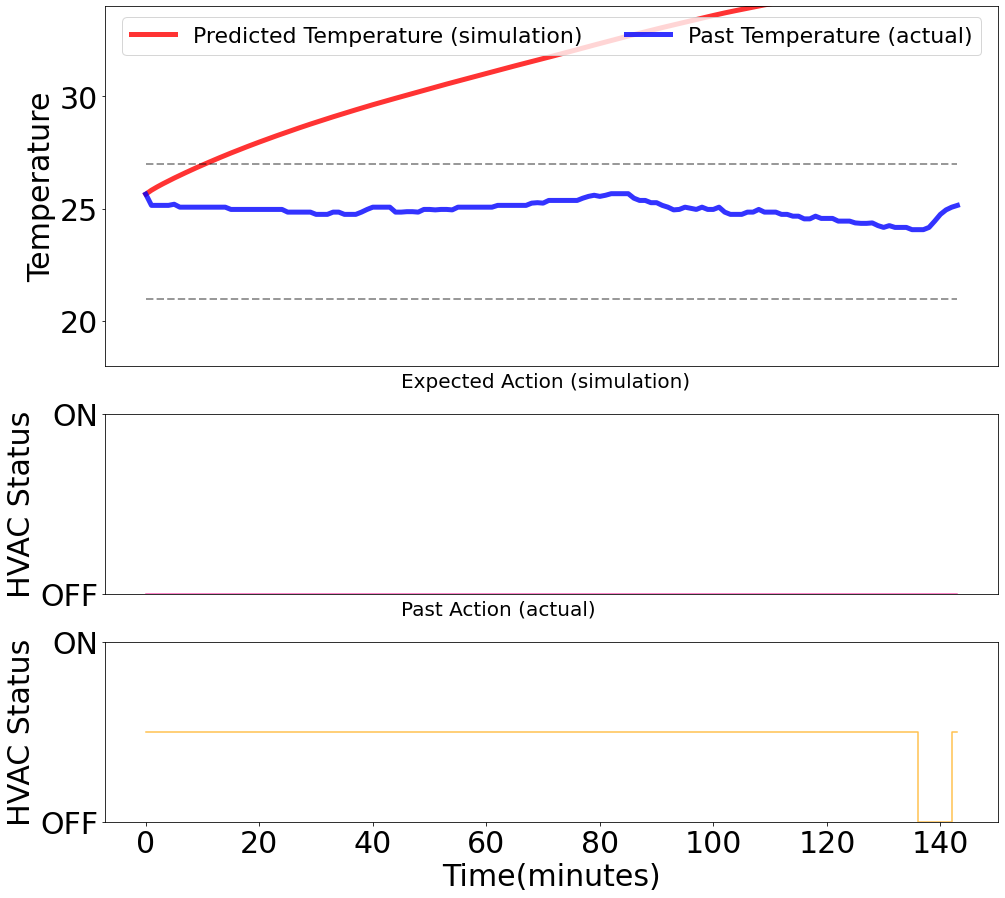

138.0
0
1 일 평균 절감율 :  100.0 실제 평균 온도 :  24.941805555555547 학습 평균 온도 :  31.46427819635879 오차율 :  -6.522472640803244
/raid/deallab/ecm/model_result/2019-10-01/20191001w14_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 24.97
[1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-10-01 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  25 실제 평균 온도 :  24.01958333333332 학습 평균 온도 :  26.222255497747952


<Figure size 432x288 with 0 Axes>

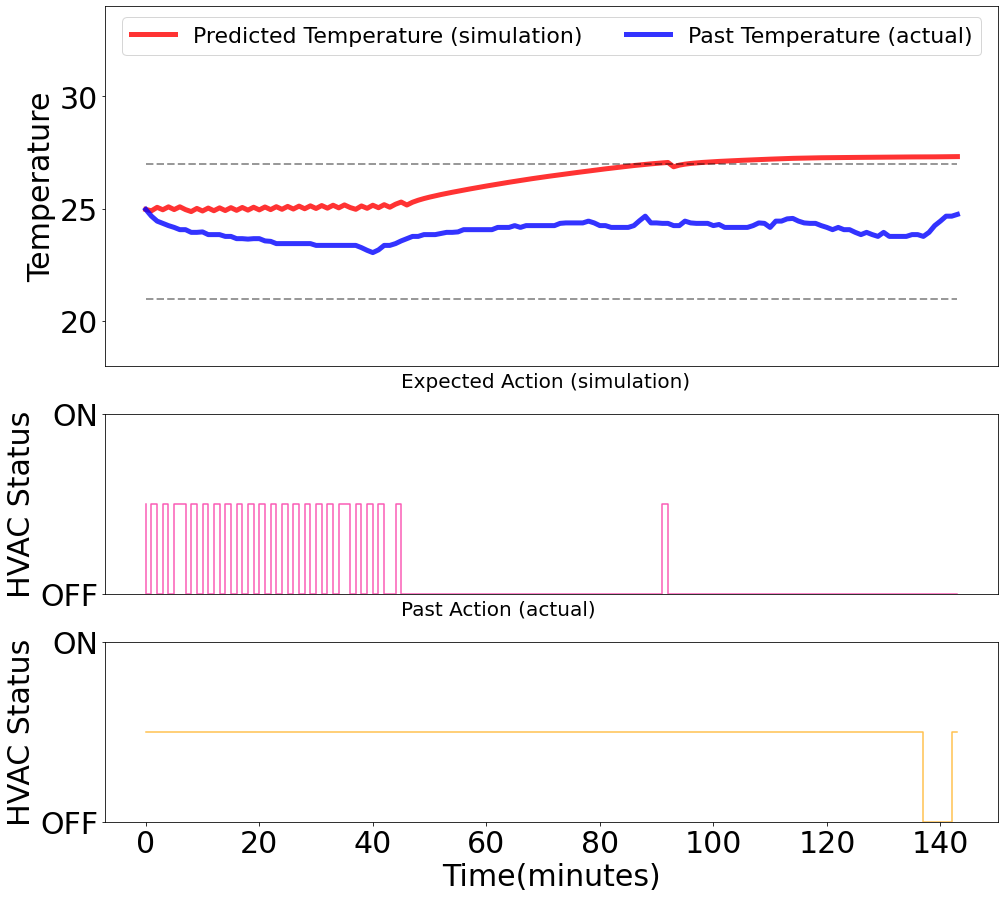

139.0
25
1 일 평균 절감율 :  82.01438848920863 실제 평균 온도 :  24.01958333333332 학습 평균 온도 :  26.222255497747952 오차율 :  -2.2026721644146328
/raid/deallab/ecm/model_result/2019-10-02/20191002w30_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 24.45
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-10-02 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  4 실제 평균 온도 :  24.525972222222197 학습 평균 온도 :  27.274398917351633


<Figure size 432x288 with 0 Axes>

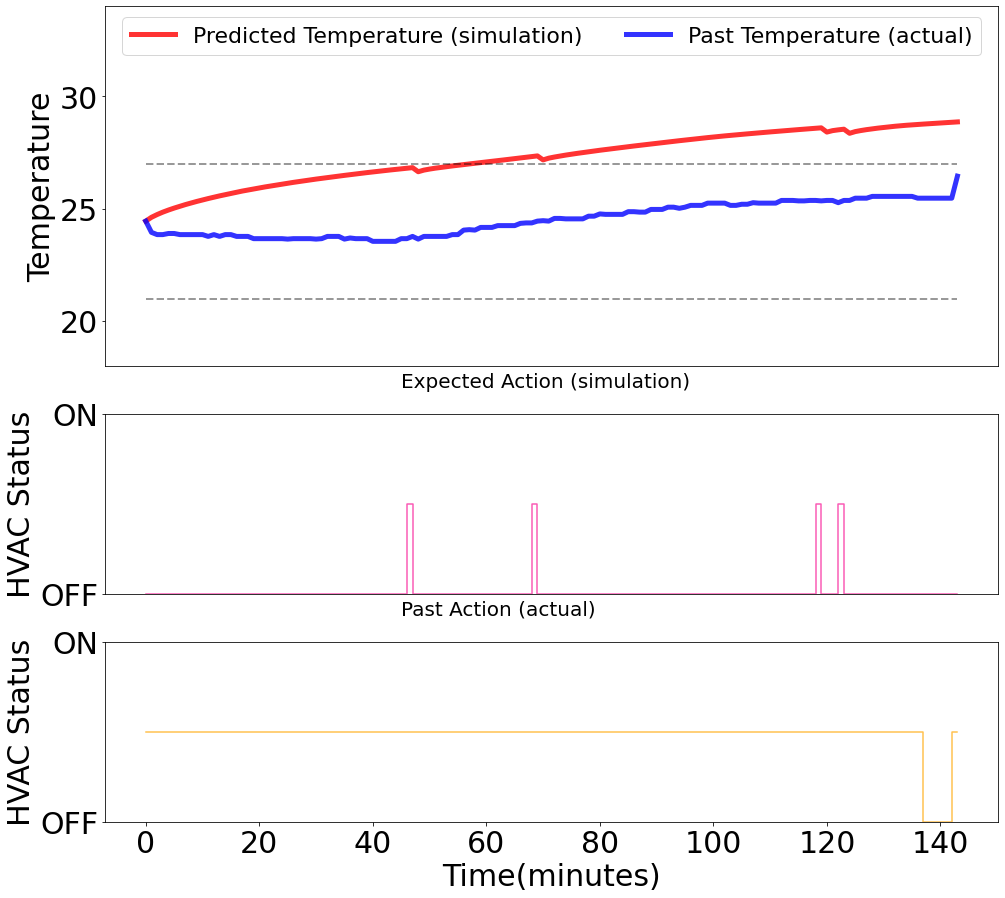

139.0
4
1 일 평균 절감율 :  97.12230215827337 실제 평균 온도 :  24.525972222222197 학습 평균 온도 :  27.274398917351633 오차율 :  -2.748426695129435
/raid/deallab/ecm/model_result/2019-10-03/20191003w30_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 26.17
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-10-03 실제 데이터 길이 :  144  : real action :  97.5 , expected action :  1 실제 평균 온도 :  25.42805555555554 학습 평균 온도 :  27.499536744062468


<Figure size 432x288 with 0 Axes>

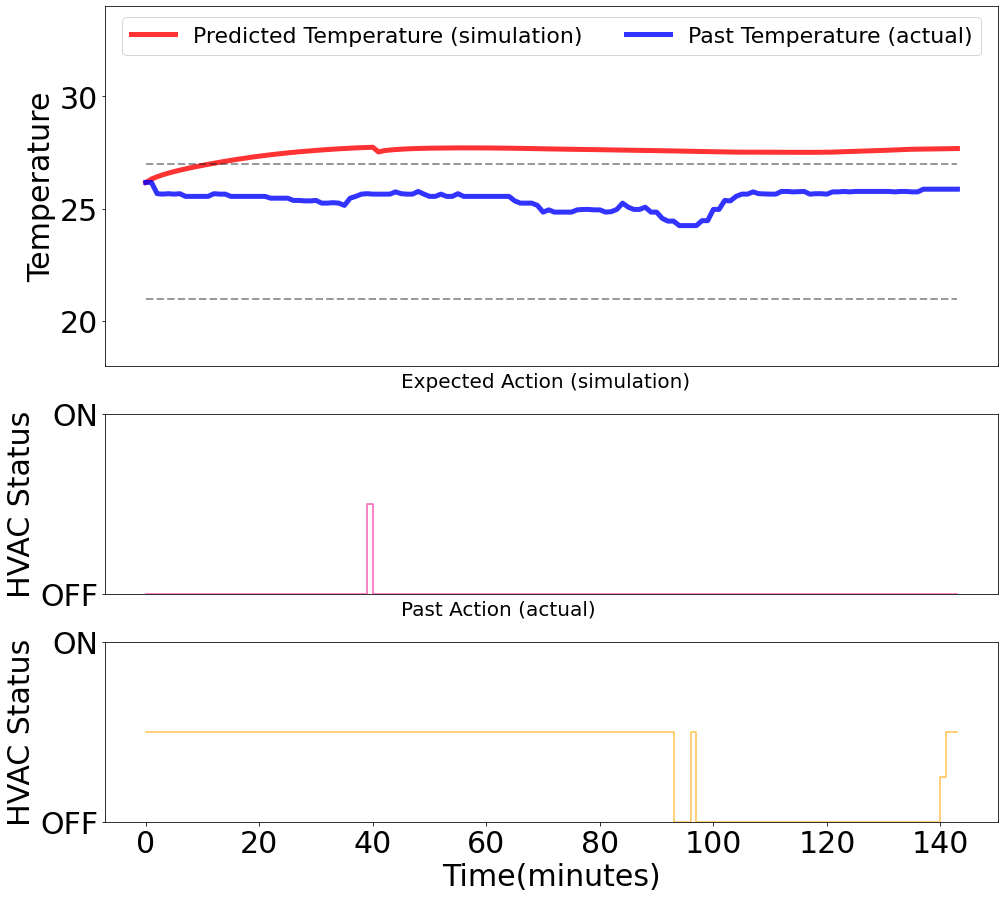

97.5
1
1 일 평균 절감율 :  98.97435897435898 실제 평균 온도 :  25.42805555555554 학습 평균 온도 :  27.499536744062468 오차율 :  -2.071481188506926
/raid/deallab/ecm/model_result/2019-10-04/20191004w7_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 25.25
[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
2019-10-04 실제 데이터 길이 :  144  : real action :  137.0 , expected action :  72 실제 평균 온도 :  23.413124999999994 학습 평균 온도 :  24.74017531097023


<Figure size 432x288 with 0 Axes>

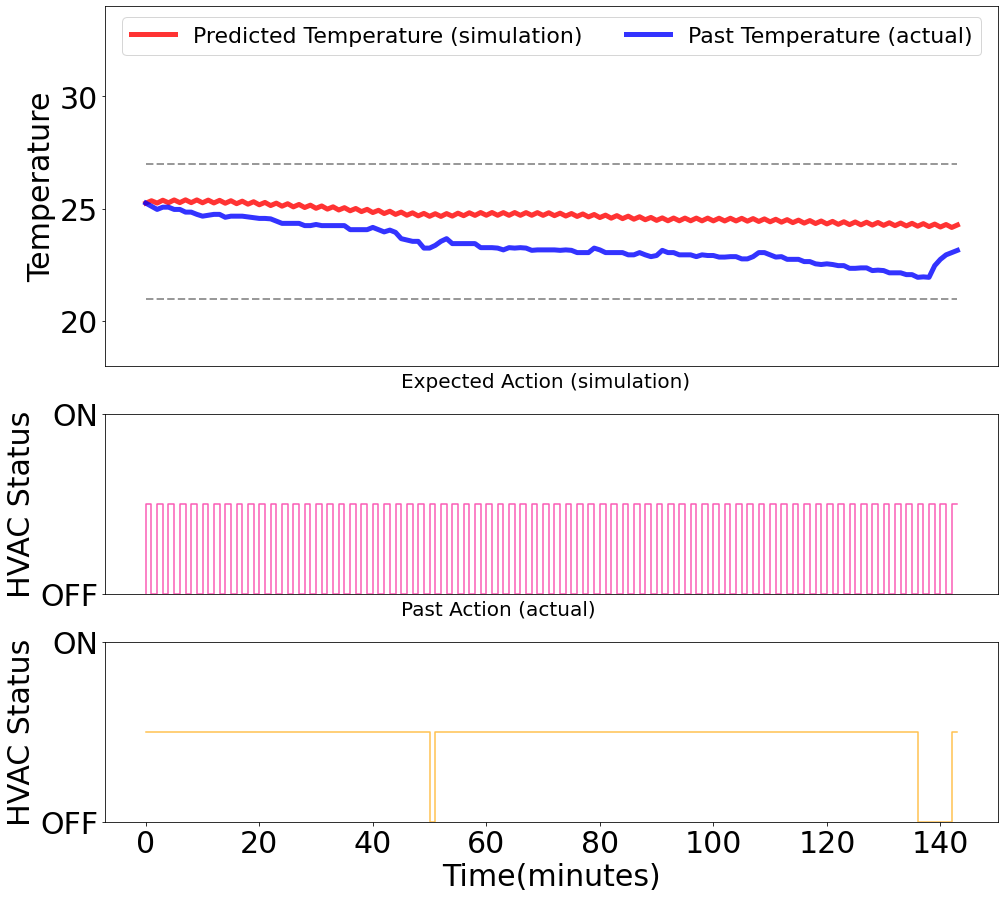

137.0
72
1 일 평균 절감율 :  47.44525547445255 실제 평균 온도 :  23.413124999999994 학습 평균 온도 :  24.74017531097023 오차율 :  -1.327050310970236
/raid/deallab/ecm/model_result/2019-10-05/20191005w14_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 22.85
[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
2019-10-05 실제 데이터 길이 :  144  : real action :  138.0 , expected action :  73 실제 평균 온도 :  21.53027777777776 학습 평균 온도 :  24.374053172355428


<Figure size 432x288 with 0 Axes>

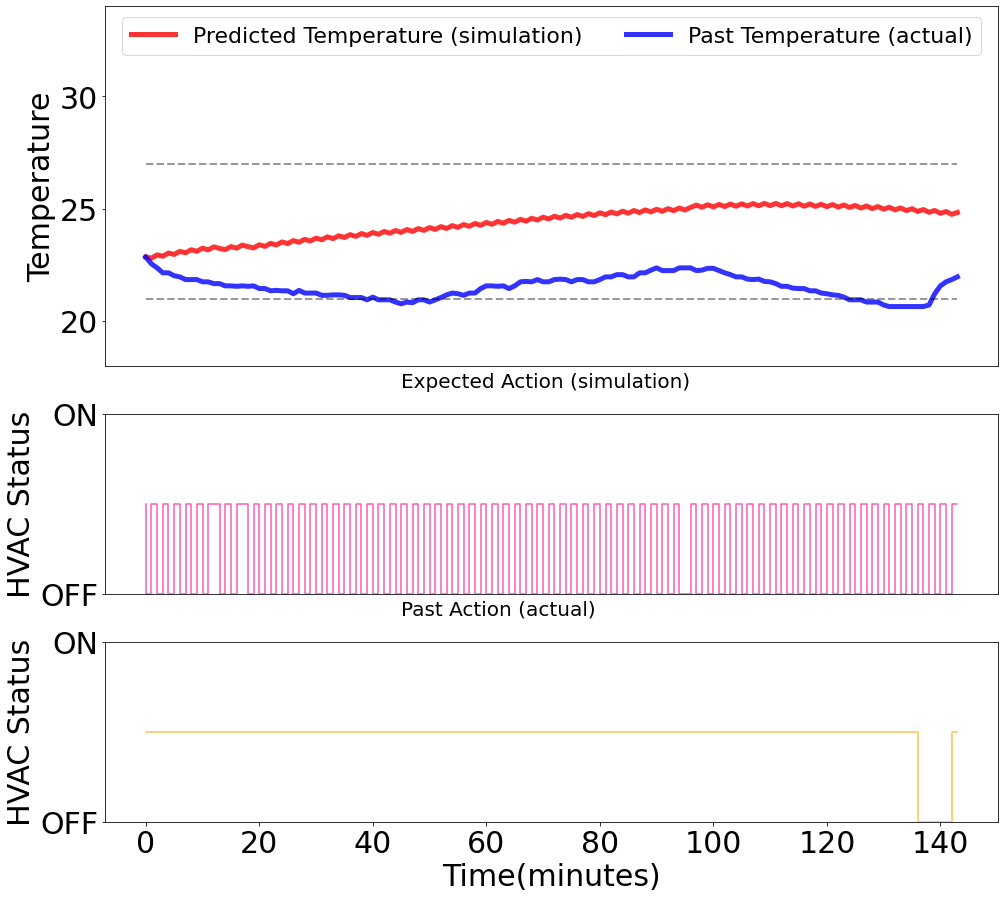

138.0
73
1 일 평균 절감율 :  47.10144927536232 실제 평균 온도 :  21.53027777777776 학습 평균 온도 :  24.374053172355428 오차율 :  -2.843775394577669
/raid/deallab/ecm/model_result/2019-10-06/20191006w7_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 21.67
[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1]
2019-10-06 실제 데이터 길이 :  144  : real action :  138.0 , expected action :  72 실제 평균 온도 :  19.38729166666664 학습 평균 온도 :  20.30498124698818


<Figure size 432x288 with 0 Axes>

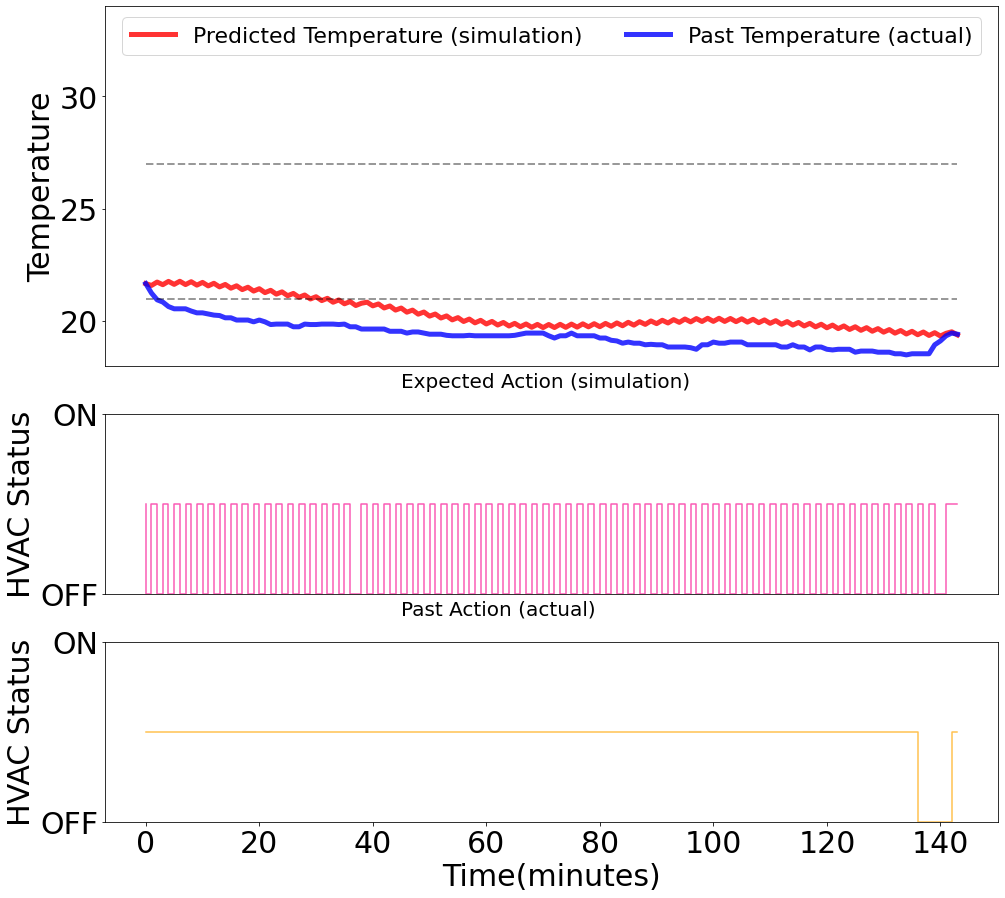

138.0
72
1 일 평균 절감율 :  47.82608695652174 실제 평균 온도 :  19.38729166666664 학습 평균 온도 :  20.30498124698818 오차율 :  -0.9176895803215395
/raid/deallab/ecm/model_result/2019-10-07/20191007w7_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 19.25
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
2019-10-07 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  140 실제 평균 온도 :  19.7011111111111 학습 평균 온도 :  19.520848790979283


<Figure size 432x288 with 0 Axes>

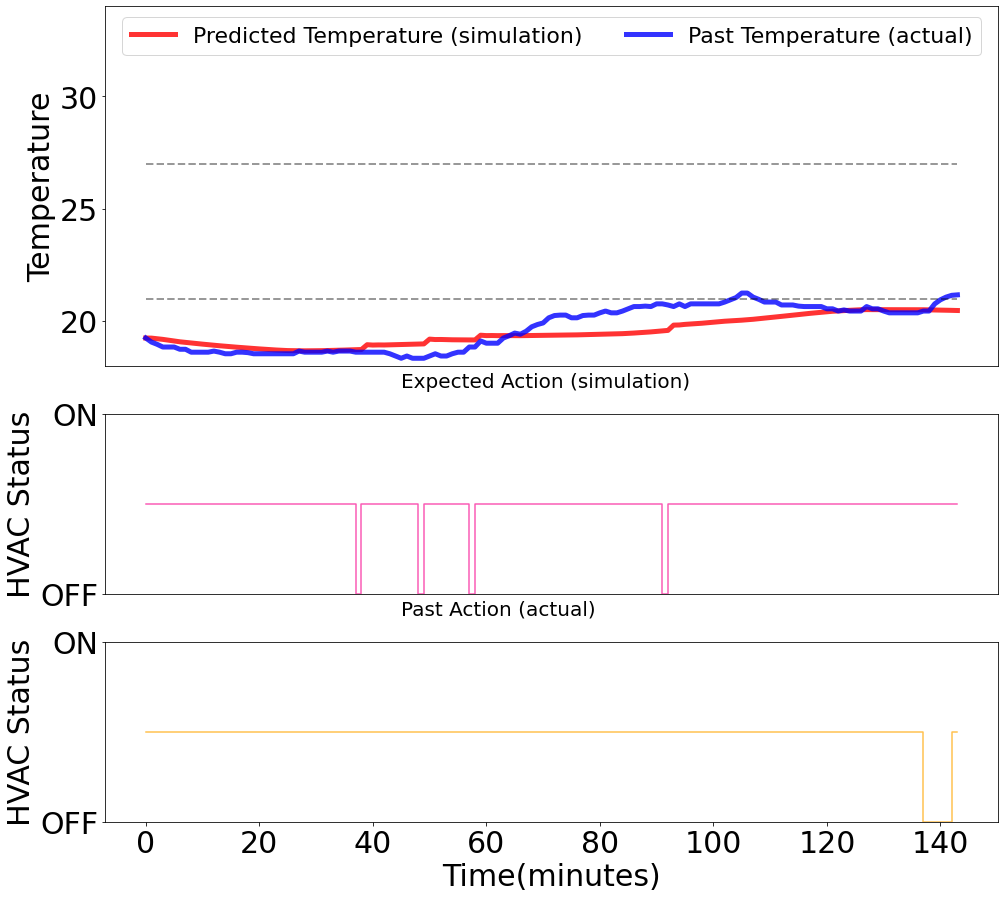

139.0
140
1 일 평균 절감율 :  -0.7194244604316548 실제 평균 온도 :  19.7011111111111 학습 평균 온도 :  19.520848790979283 오차율 :  0.18026232013181698
/raid/deallab/ecm/model_result/2019-10-08/20191008w30_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 20.85
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-10-08 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  0 실제 평균 온도 :  20.987222222222215 학습 평균 온도 :  23.237875271962004


<Figure size 432x288 with 0 Axes>

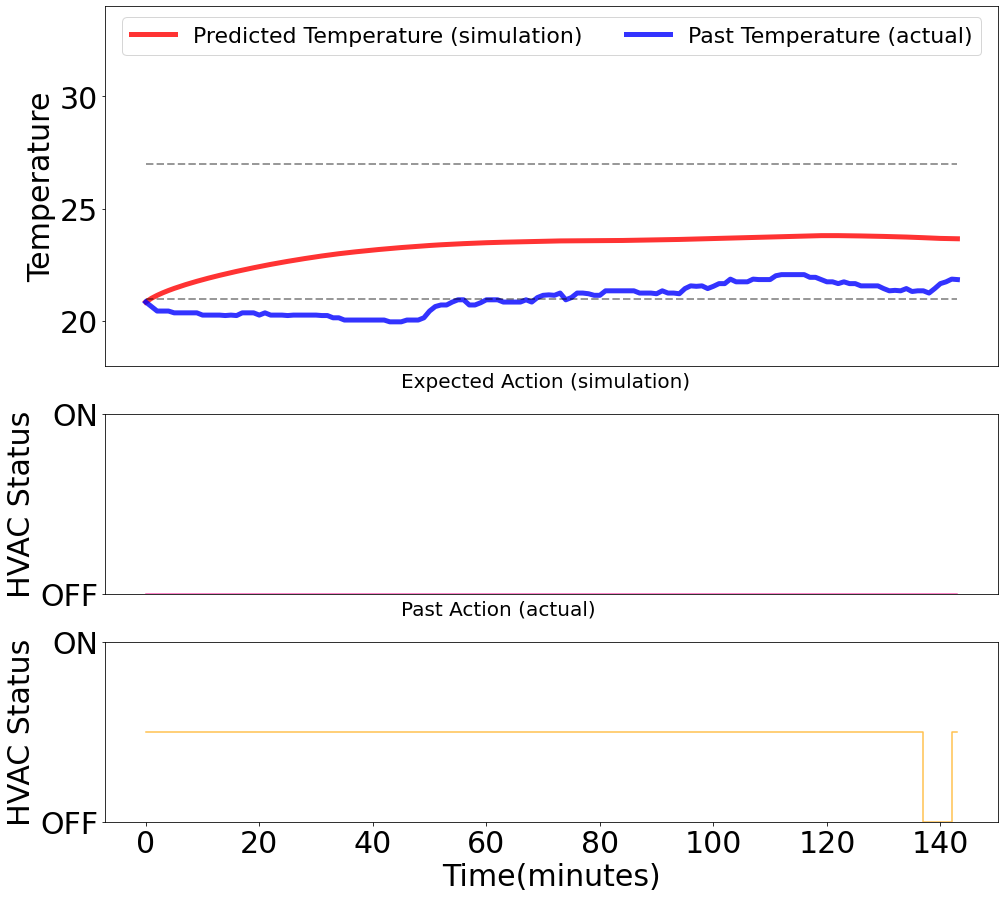

139.0
0
1 일 평균 절감율 :  100.0 실제 평균 온도 :  20.987222222222215 학습 평균 온도 :  23.237875271962004 오차율 :  -2.250653049739789
/raid/deallab/ecm/model_result/2019-10-09/20191009w7_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 21.55
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-10-09 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  27 실제 평균 온도 :  20.557152777777784 학습 평균 온도 :  22.4778764618661


<Figure size 432x288 with 0 Axes>

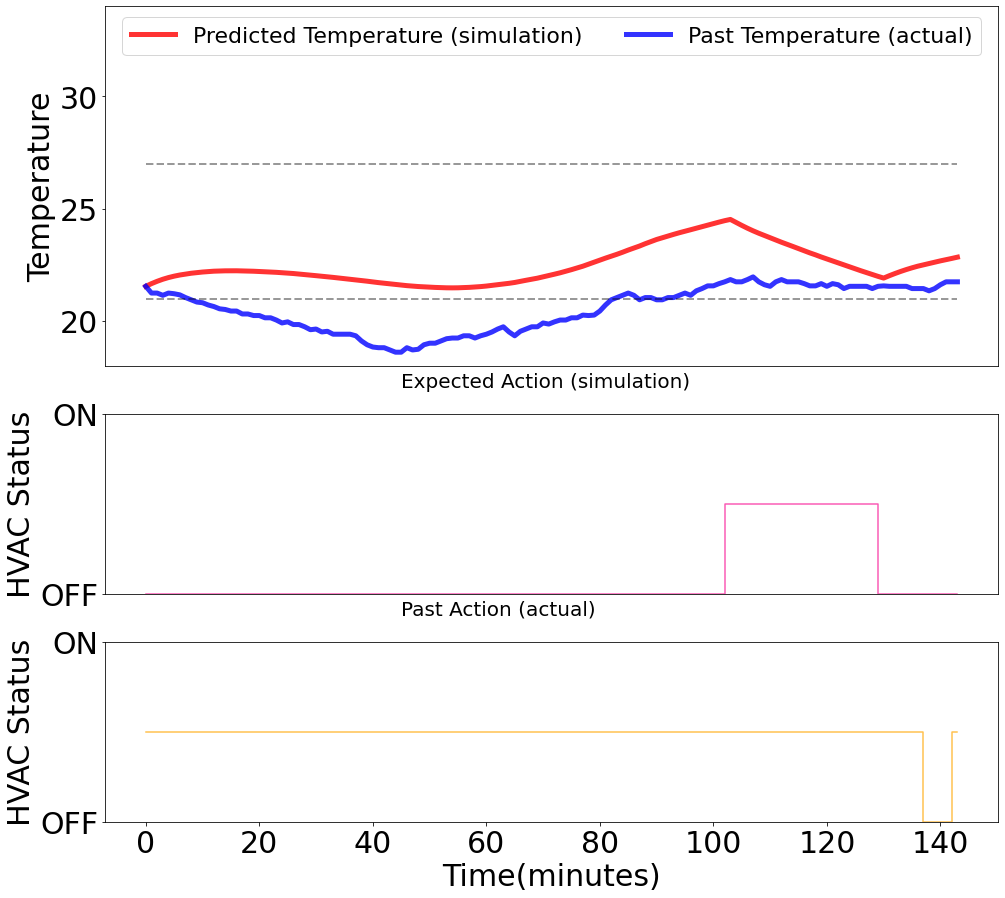

139.0
27
1 일 평균 절감율 :  80.57553956834532 실제 평균 온도 :  20.557152777777784 학습 평균 온도 :  22.4778764618661 오차율 :  -1.9207236840883155
/raid/deallab/ecm/model_result/2019-10-10/20191010w14_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 21.32
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-10-10 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  4 실제 평균 온도 :  21.28416666666667 학습 평균 온도 :  25.277825154008156


<Figure size 432x288 with 0 Axes>

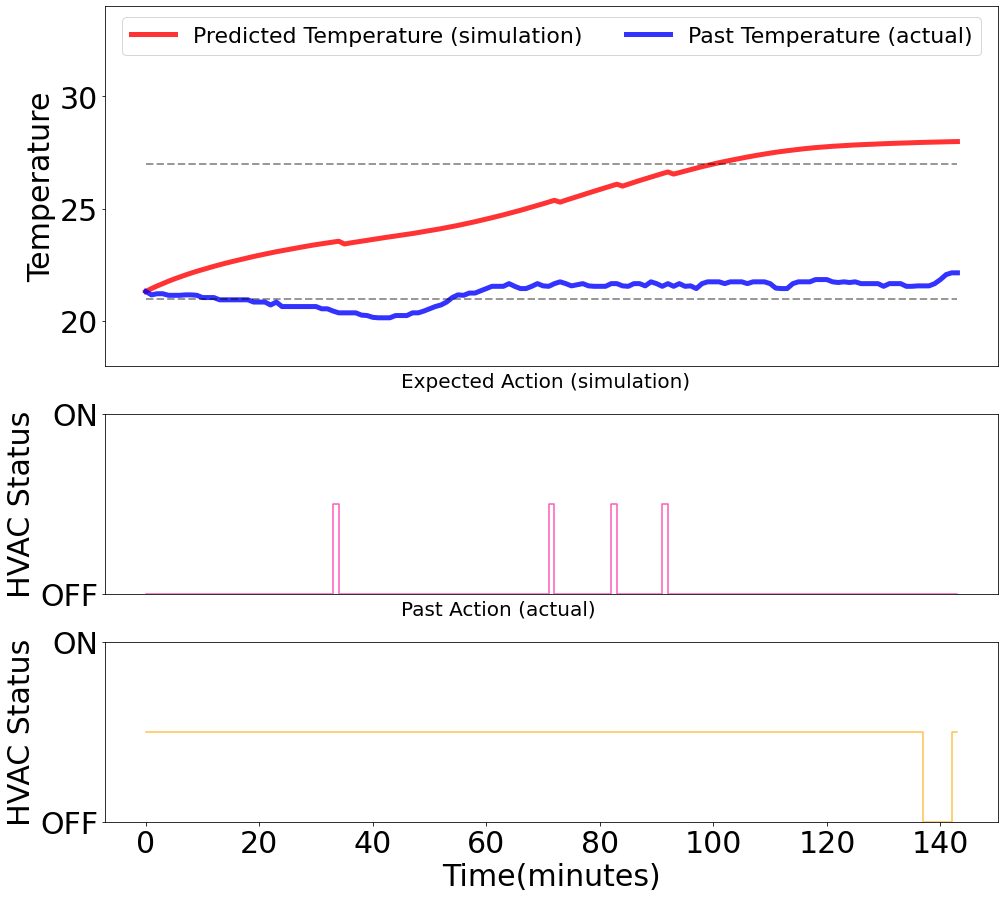

139.0
4
1 일 평균 절감율 :  97.12230215827337 실제 평균 온도 :  21.28416666666667 학습 평균 온도 :  25.277825154008156 오차율 :  -3.9936584873414844
/raid/deallab/ecm/model_result/2019-10-11/20191011w30_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 21.85
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-10-11 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  1 실제 평균 온도 :  21.629513888888866 학습 평균 온도 :  24.52976098151659


<Figure size 432x288 with 0 Axes>

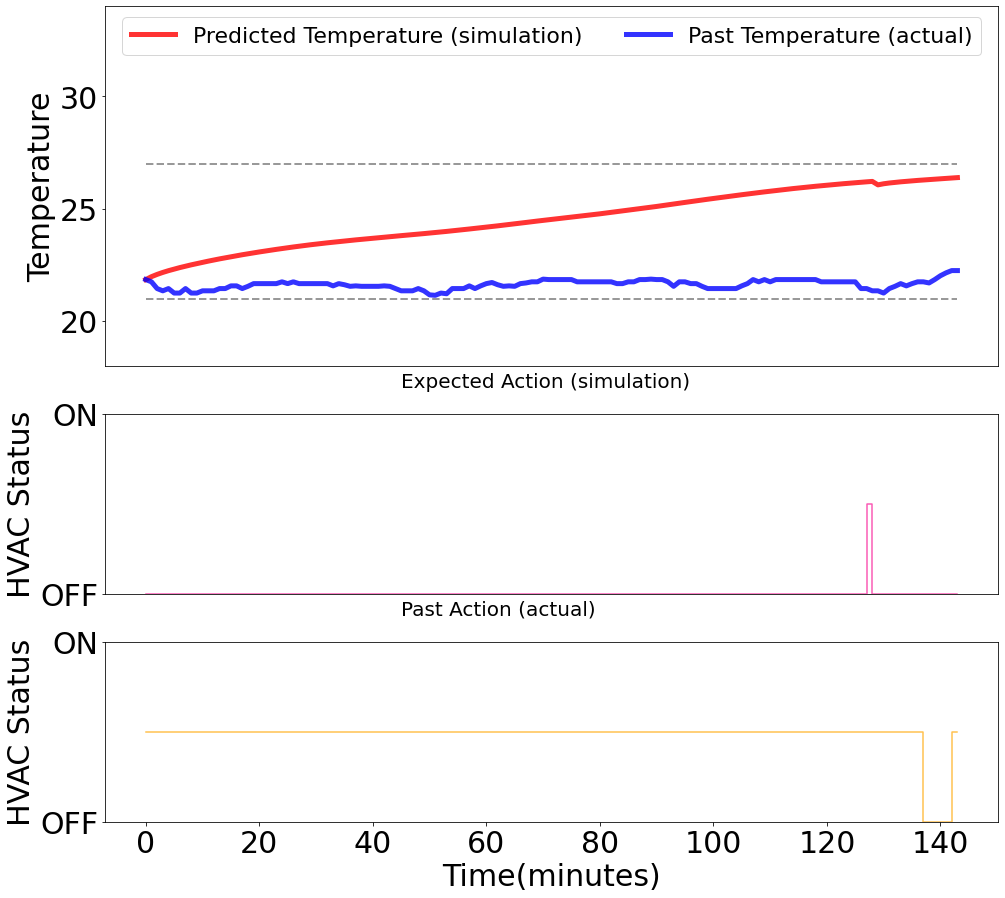

139.0
1
1 일 평균 절감율 :  99.28057553956835 실제 평균 온도 :  21.629513888888866 학습 평균 온도 :  24.52976098151659 오차율 :  -2.9002470926277226
/raid/deallab/ecm/model_result/2019-10-12/20191012w30_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 22.07
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-10-12 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  0 실제 평균 온도 :  21.715694444444427 학습 평균 온도 :  25.248490661674552


<Figure size 432x288 with 0 Axes>

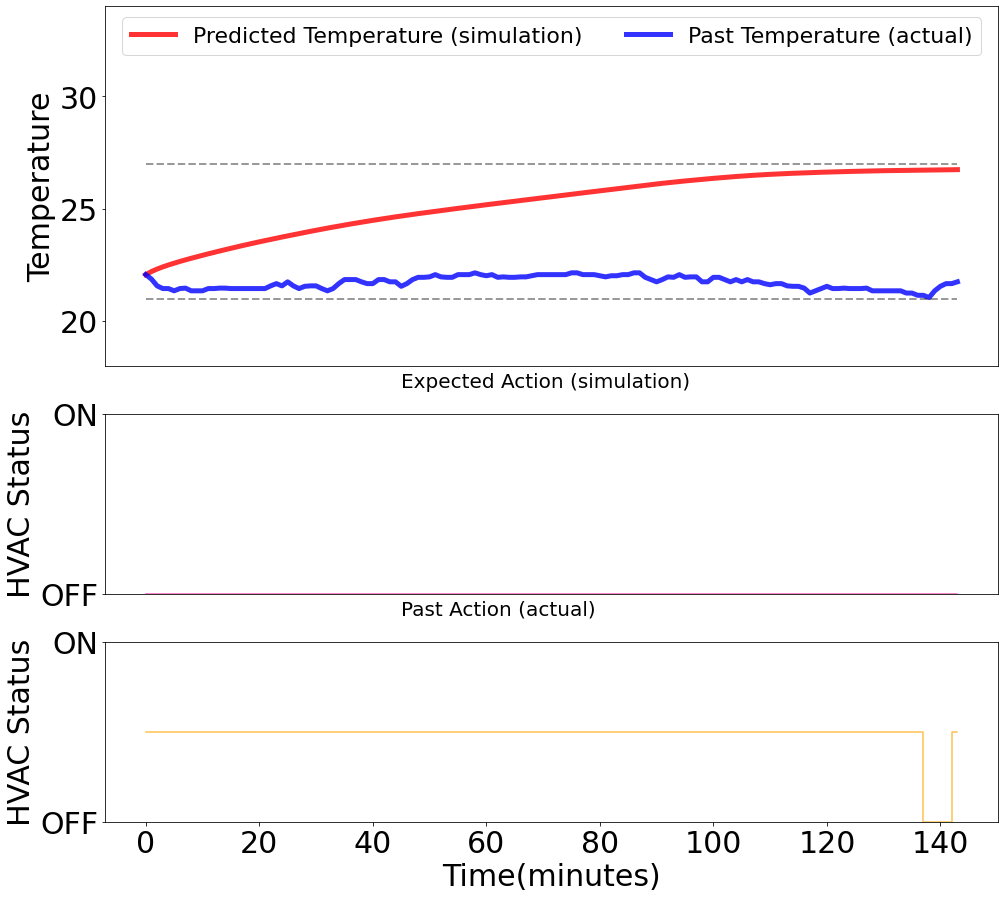

139.0
0
1 일 평균 절감율 :  100.0 실제 평균 온도 :  21.715694444444427 학습 평균 온도 :  25.248490661674552 오차율 :  -3.532796217230125
/raid/deallab/ecm/model_result/2019-10-13/20191013w30_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 21.45
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-10-13 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  1 실제 평균 온도 :  20.33749999999999 학습 평균 온도 :  24.493298749549567


<Figure size 432x288 with 0 Axes>

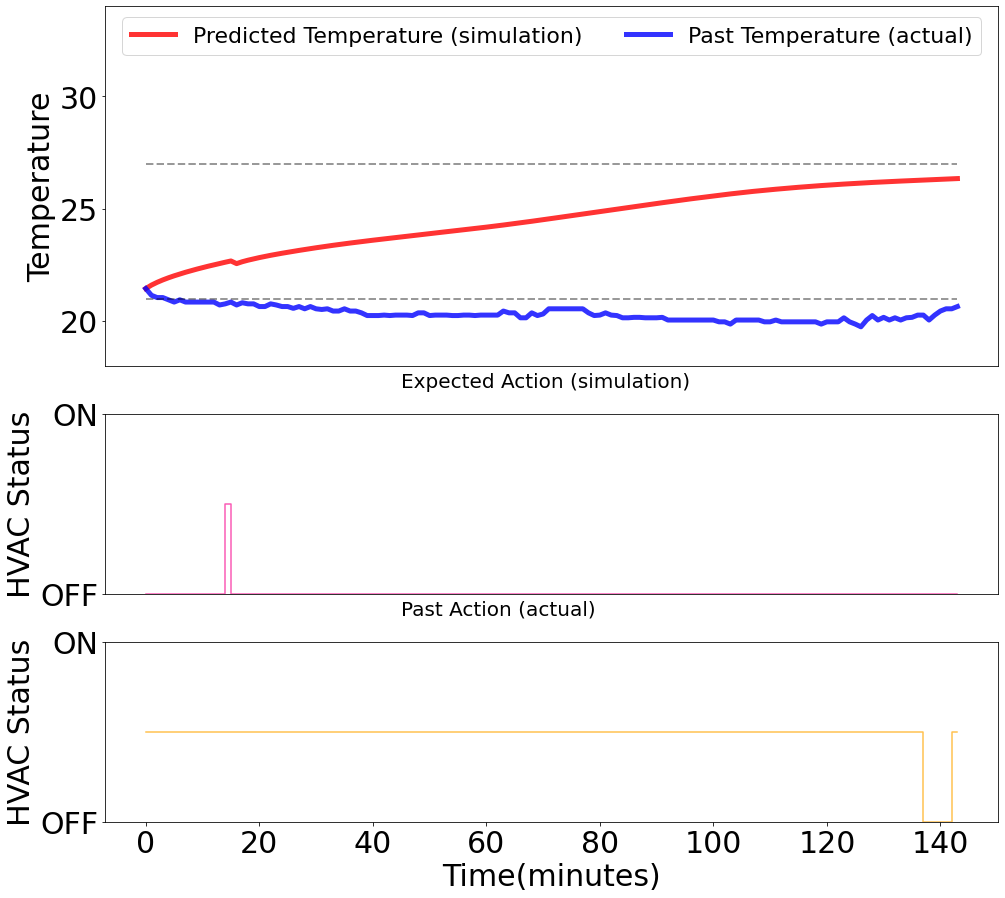

139.0
1
1 일 평균 절감율 :  99.28057553956835 실제 평균 온도 :  20.33749999999999 학습 평균 온도 :  24.493298749549567 오차율 :  -4.155798749549575
/raid/deallab/ecm/model_result/2019-10-14/20191014w7_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 20.37
[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
2019-10-14 실제 데이터 길이 :  144  : real action :  68.0 , expected action :  72 실제 평균 온도 :  21.350902777777772 학습 평균 온도 :  21.35967307357434


<Figure size 432x288 with 0 Axes>

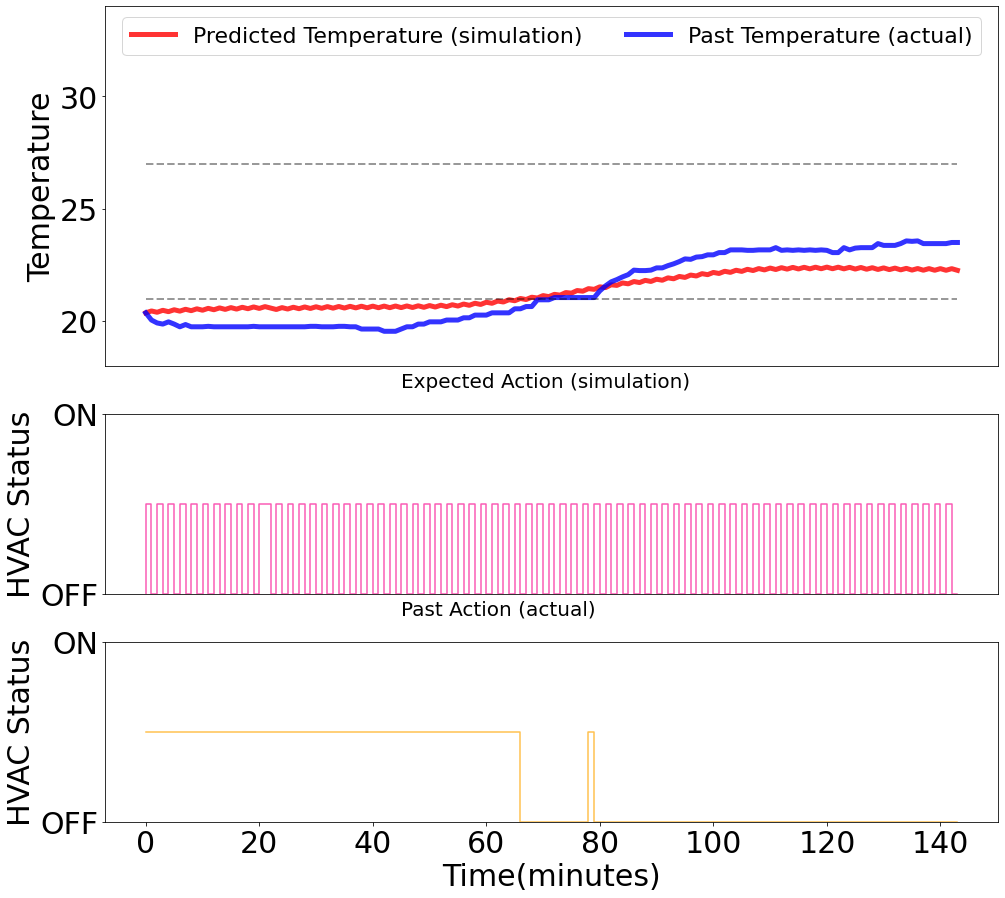

68.0
72
1 일 평균 절감율 :  -5.88235294117647 실제 평균 온도 :  21.350902777777772 학습 평균 온도 :  21.35967307357434 오차율 :  -0.008770295796566074
/raid/deallab/ecm/model_result/2019-10-15/20191015w14_linear_regression.joblib
F_SET_MODE_3
Reset data f3_temp : 23.45
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
2019-10-15 실제 데이터 길이 :  144  : real action :  97.0 , expected action :  144 실제 평균 온도 :  22.925277777777783 학습 평균 온도 :  21.776548318880554


<Figure size 432x288 with 0 Axes>

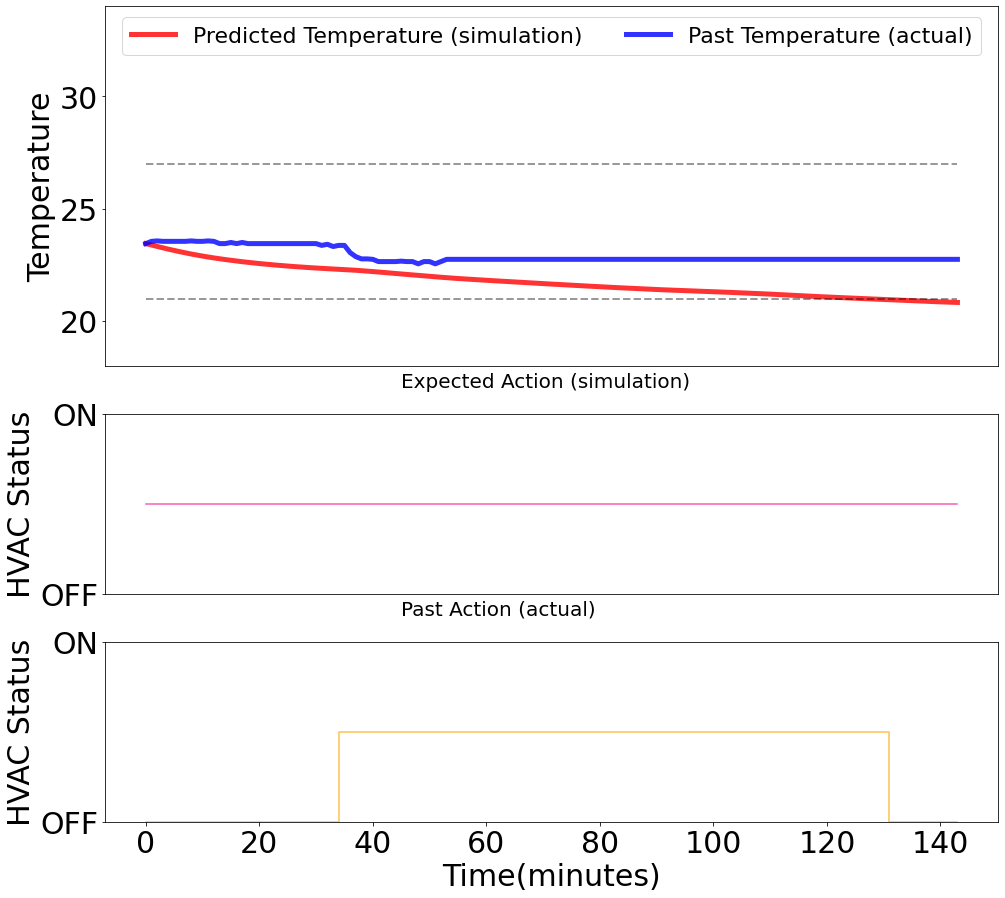

97.0
144
1 일 평균 절감율 :  -48.45360824742268 실제 평균 온도 :  22.925277777777783 학습 평균 온도 :  21.776548318880554 오차율 :  1.148729458897229
/raid/deallab/ecm/model_result/2019-10-16/20191016w30_linear_regression.joblib
F_SET_MODE_3
Reset data f3_temp : 22.75
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
2019-10-16 실제 데이터 길이 :  144  : real action :  97.0 , expected action :  144 실제 평균 온도 :  23.85097222222219 학습 평균 온도 :  22.379916453747743


<Figure size 432x288 with 0 Axes>

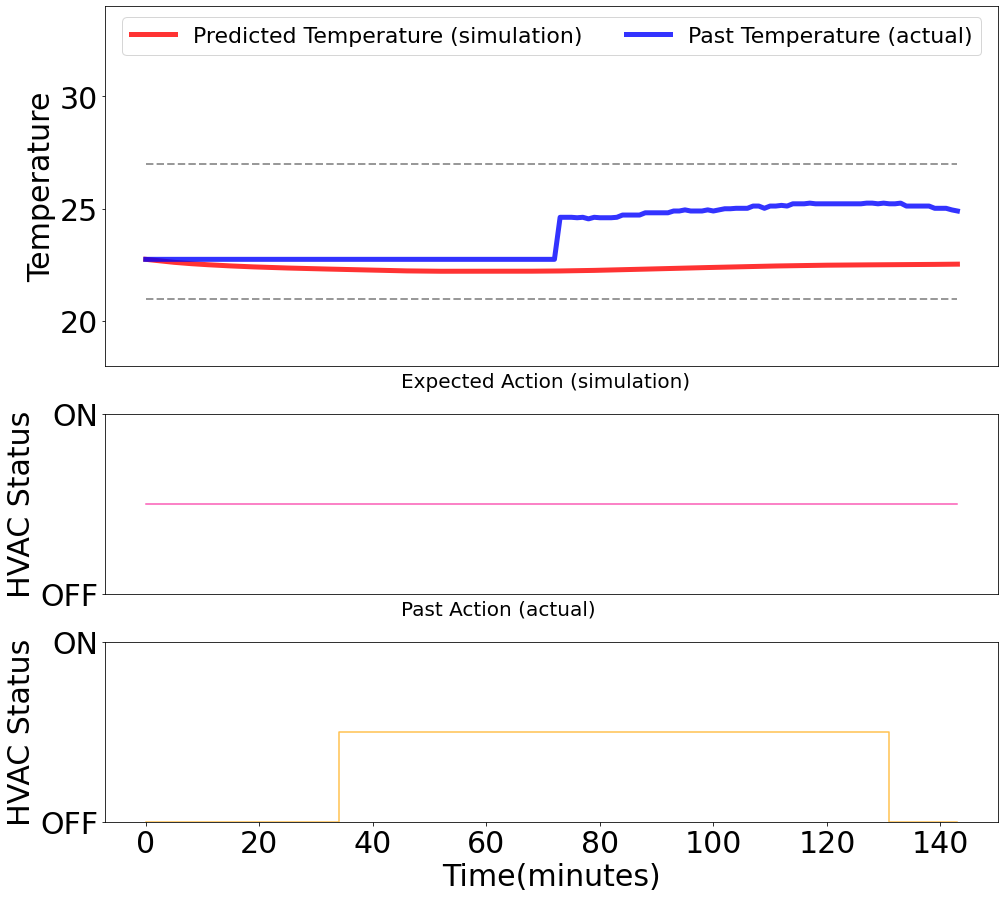

97.0
144
1 일 평균 절감율 :  -48.45360824742268 실제 평균 온도 :  23.85097222222219 학습 평균 온도 :  22.379916453747743 오차율 :  1.4710557684744465
/raid/deallab/ecm/model_result/2019-10-17/20191017w7_linear_regression.joblib
F_SET_MODE_3
Reset data f3_temp : 24.95
[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
2019-10-17 실제 데이터 길이 :  144  : real action :  97.0 , expected action :  123 실제 평균 온도 :  25.320625000000017 학습 평균 온도 :  24.27446472138885


<Figure size 432x288 with 0 Axes>

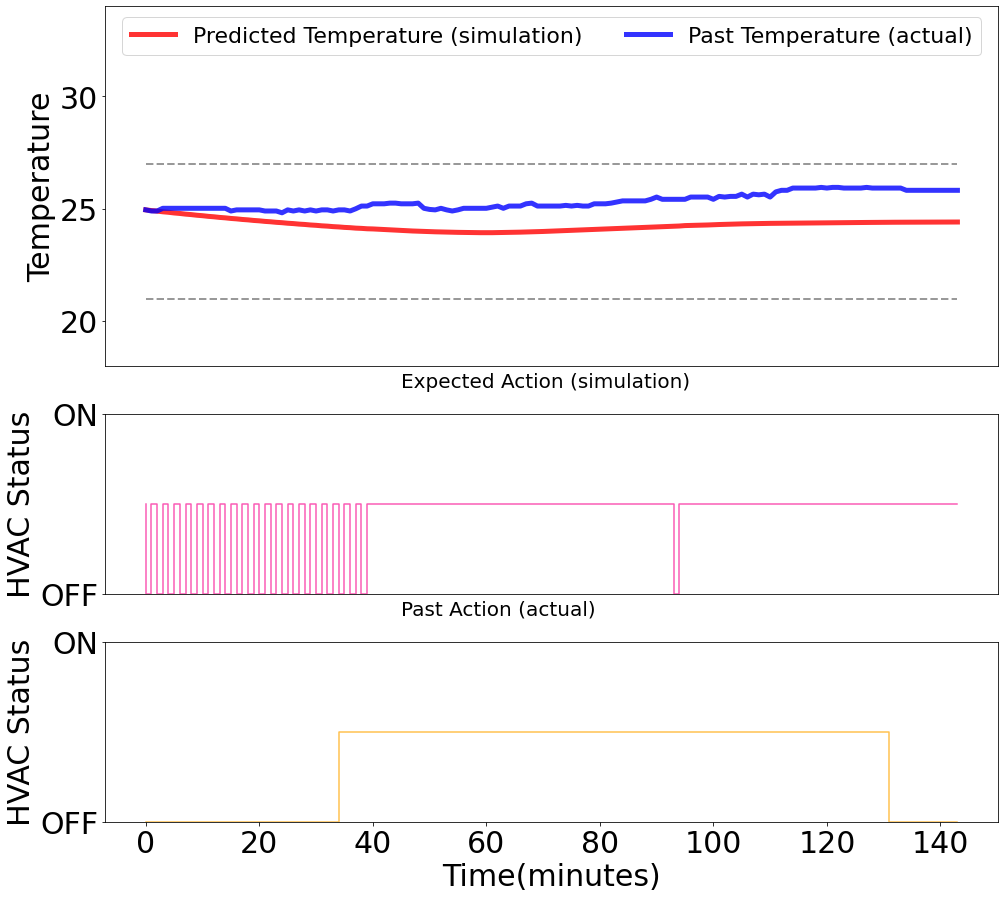

97.0
123
1 일 평균 절감율 :  -26.804123711340207 실제 평균 온도 :  25.320625000000017 학습 평균 온도 :  24.27446472138885 오차율 :  1.0461602786111683
/raid/deallab/ecm/model_result/2019-10-18/20191018w30_linear_regression.joblib
F_SET_MODE_3
Reset data f3_temp : 25.82
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-10-18 실제 데이터 길이 :  144  : real action :  97.0 , expected action :  44 실제 평균 온도 :  25.29326388888887 학습 평균 온도 :  25.55496765651725


<Figure size 432x288 with 0 Axes>

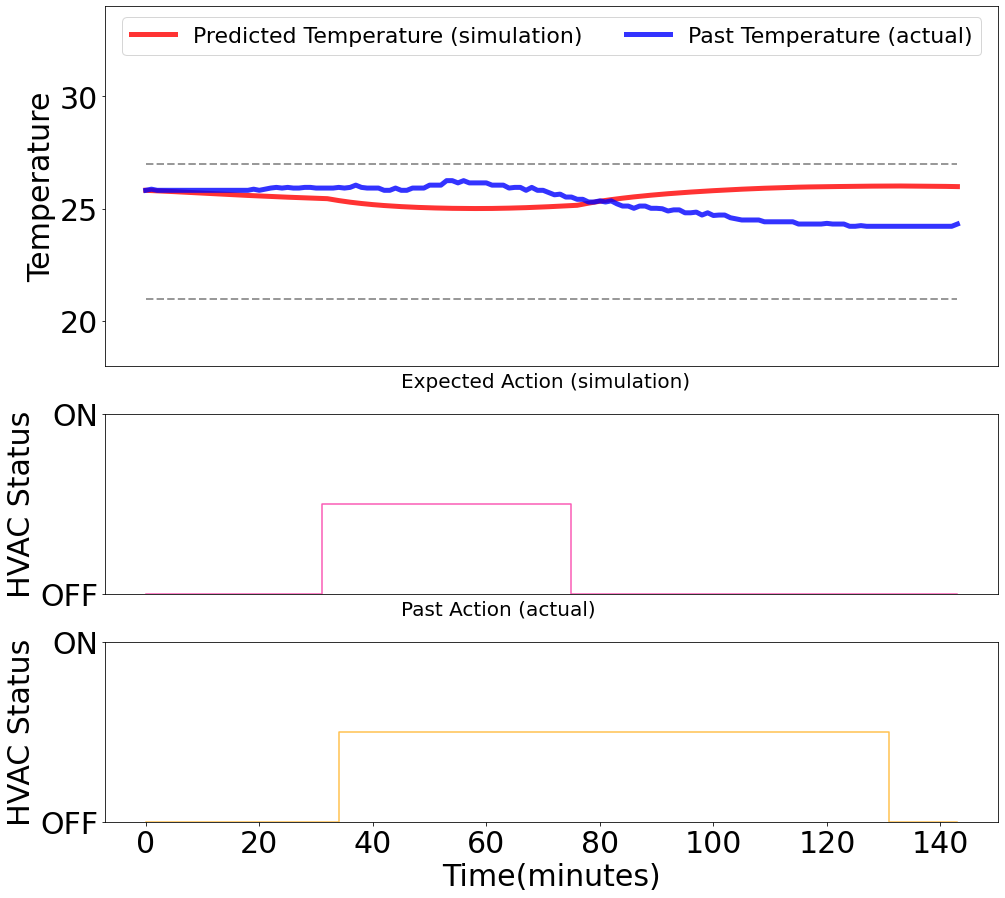

97.0
44
1 일 평균 절감율 :  54.63917525773196 실제 평균 온도 :  25.29326388888887 학습 평균 온도 :  25.55496765651725 오차율 :  -0.2617037676283793
/raid/deallab/ecm/model_result/2019-10-19/20191019w7_linear_regression.joblib
F_SET_MODE_3
Reset data f3_temp : 24.35
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-10-19 실제 데이터 길이 :  144  : real action :  97.0 , expected action :  15 실제 평균 온도 :  24.250416666666677 학습 평균 온도 :  24.175681887830205


<Figure size 432x288 with 0 Axes>

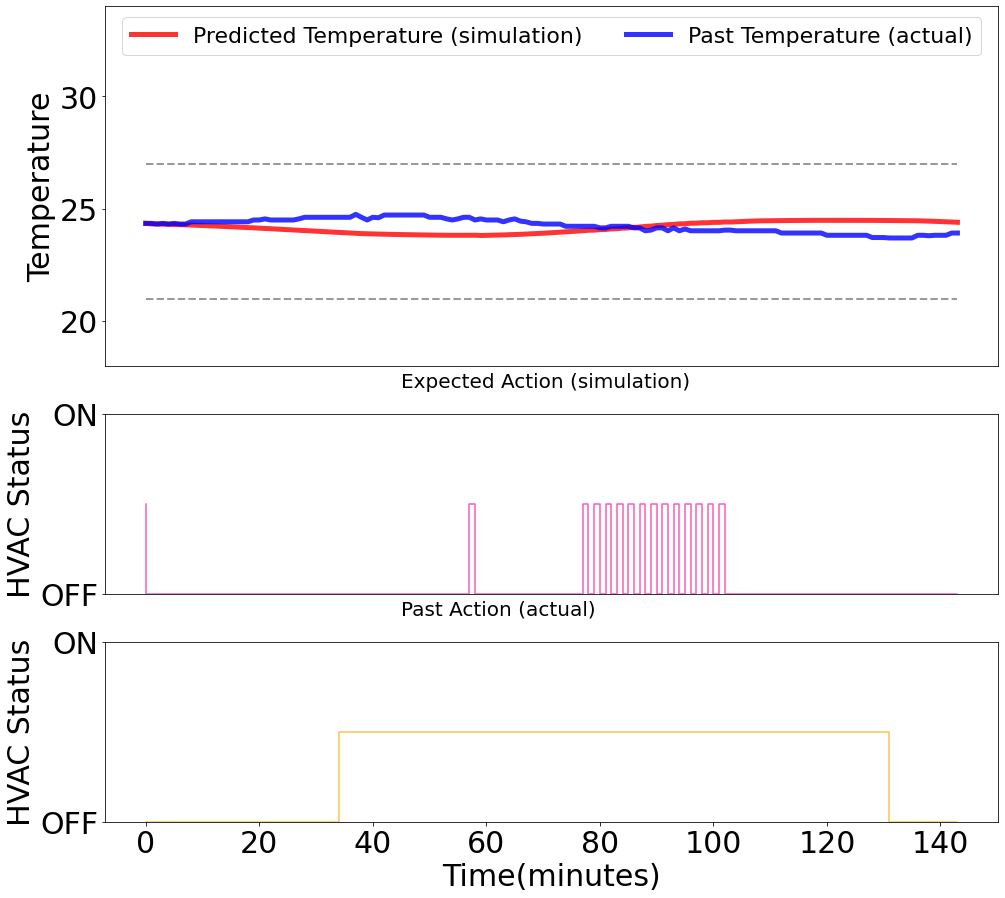

97.0
15
1 일 평균 절감율 :  84.5360824742268 실제 평균 온도 :  24.250416666666677 학습 평균 온도 :  24.175681887830205 오차율 :  0.07473477883647206
/raid/deallab/ecm/model_result/2019-10-20/20191020w1_linear_regression.joblib
F_SET_MODE_3
Reset data f3_temp : 23.92
[1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0]
2019-10-20 실제 데이터 길이 :  144  : real action :  97.0 , expected action :  50 실제 평균 온도 :  24.05208333333334 학습 평균 온도 :  24.55095736644932


<Figure size 432x288 with 0 Axes>

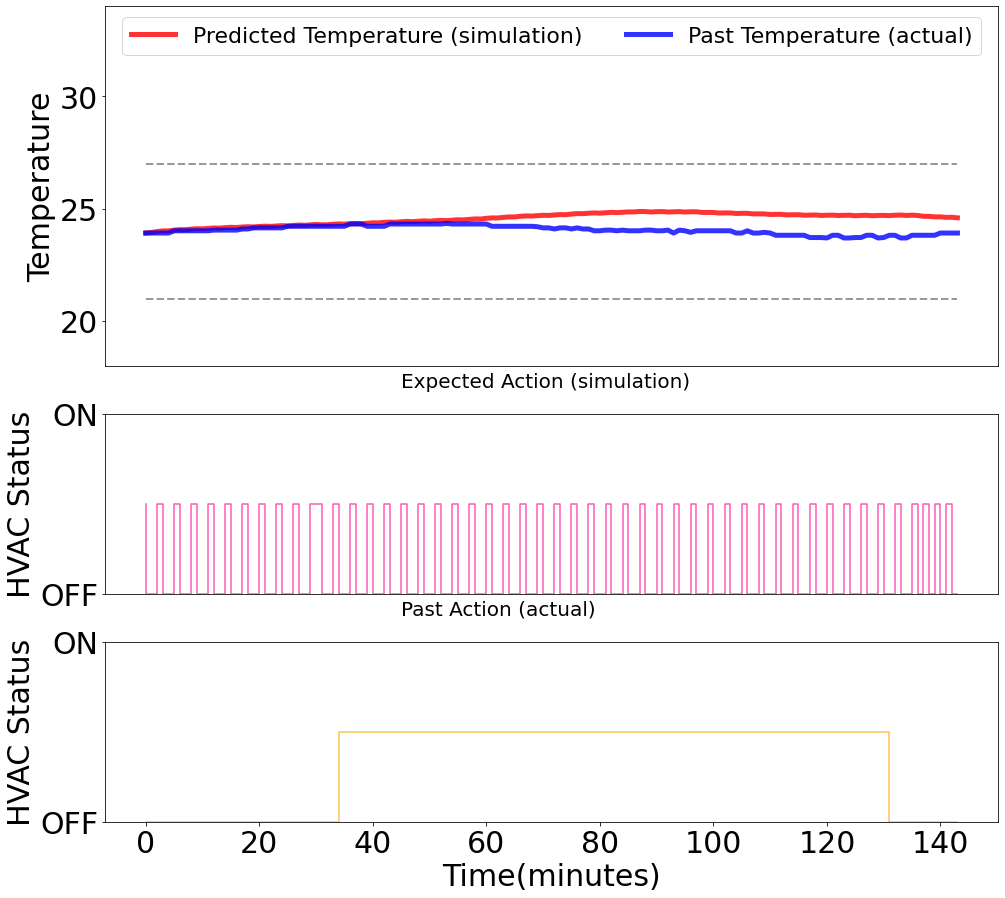

97.0
50
1 일 평균 절감율 :  48.45360824742268 실제 평균 온도 :  24.05208333333334 학습 평균 온도 :  24.55095736644932 오차율 :  -0.4988740331159818
/raid/deallab/ecm/model_result/2019-10-21/20191021w14_linear_regression.joblib
F_SET_MODE_4
Reset data f3_temp : 23.92
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0]
2019-10-21 실제 데이터 길이 :  144  : real action :  53.0 , expected action :  56 실제 평균 온도 :  24.083680555555585 학습 평균 온도 :  24.04177252721948


<Figure size 432x288 with 0 Axes>

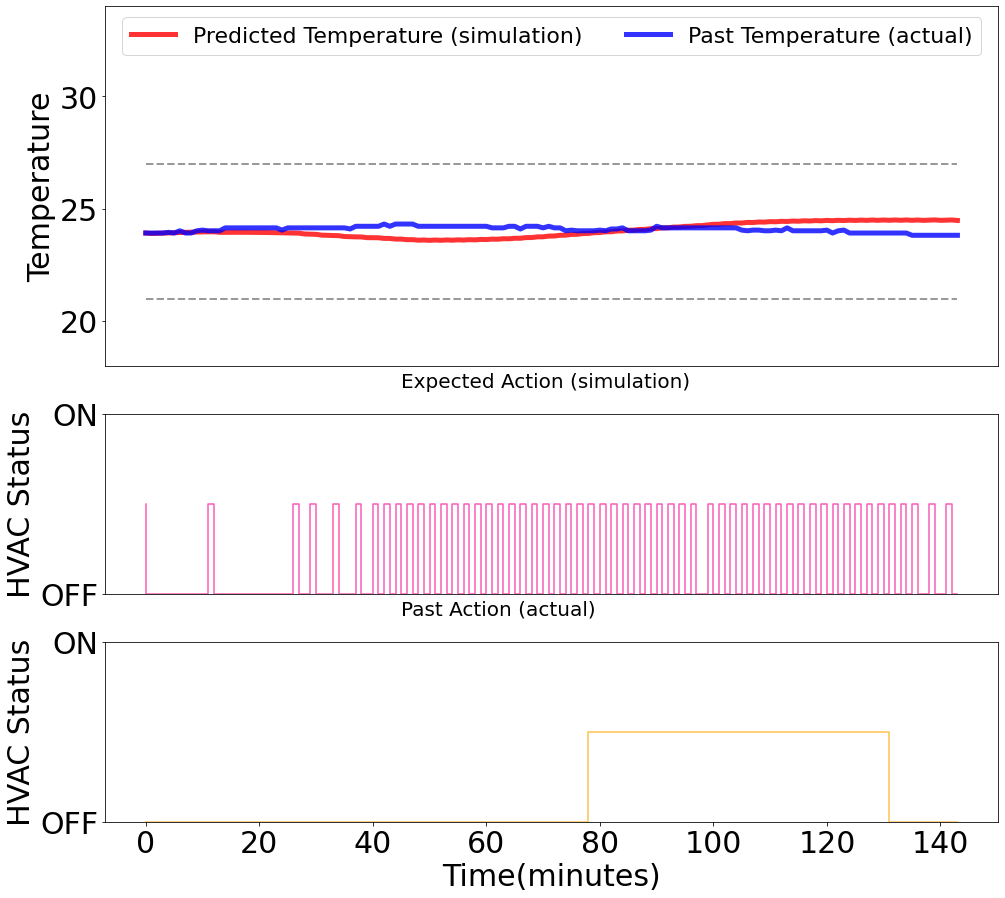

53.0
56
1 일 평균 절감율 :  -5.660377358490567 실제 평균 온도 :  24.083680555555585 학습 평균 온도 :  24.04177252721948 오차율 :  0.041908028336106184
/raid/deallab/ecm/model_result/2019-10-22/20191022w7_linear_regression.joblib
F_SET_MODE_4
Reset data f3_temp : 23.82
[1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
2019-10-22 실제 데이터 길이 :  144  : real action :  97.0 , expected action :  20 실제 평균 온도 :  23.582847222222213 학습 평균 온도 :  23.838779630649707


<Figure size 432x288 with 0 Axes>

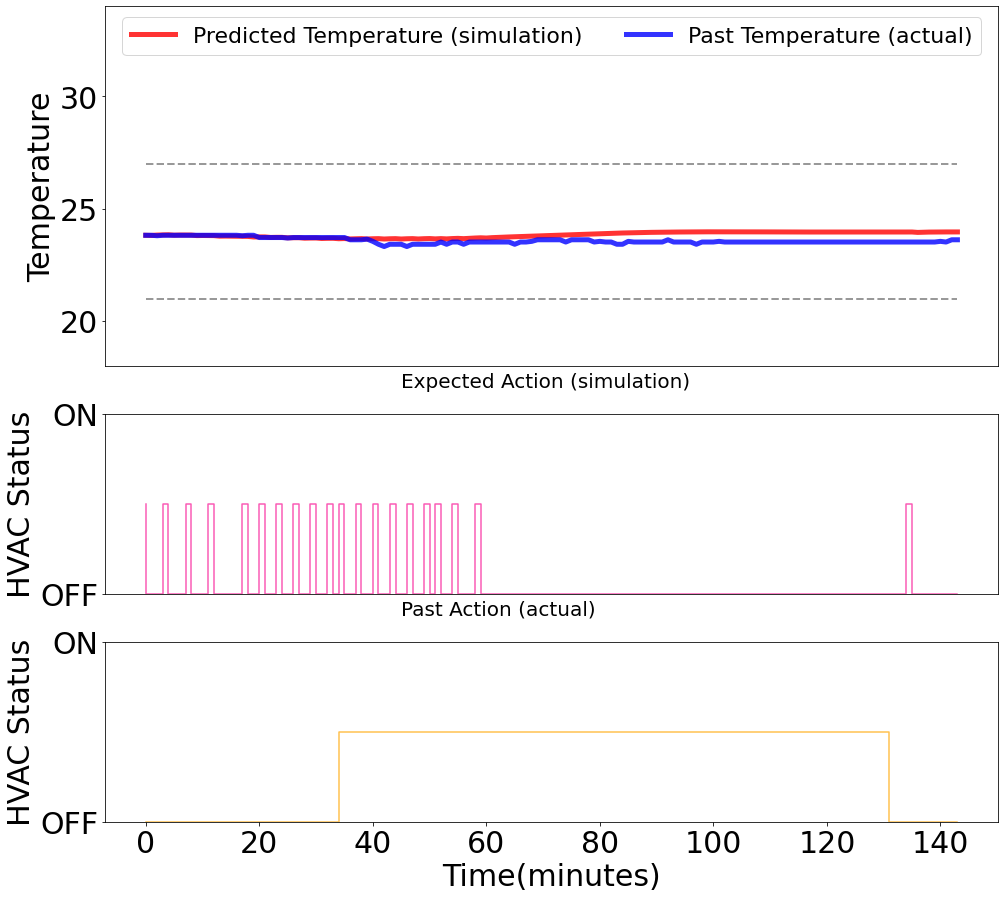

97.0
20
1 일 평균 절감율 :  79.38144329896907 실제 평균 온도 :  23.582847222222213 학습 평균 온도 :  23.838779630649707 오차율 :  -0.2559324084274941
/raid/deallab/ecm/model_result/2019-10-23/20191023w30_linear_regression.joblib
F_SET_MODE_4
Reset data f3_temp : 23.7
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1]
2019-10-23 실제 데이터 길이 :  144  : real action :  97.0 , expected action :  35 실제 평균 온도 :  23.762013888888905 학습 평균 온도 :  24.36865348276664


<Figure size 432x288 with 0 Axes>

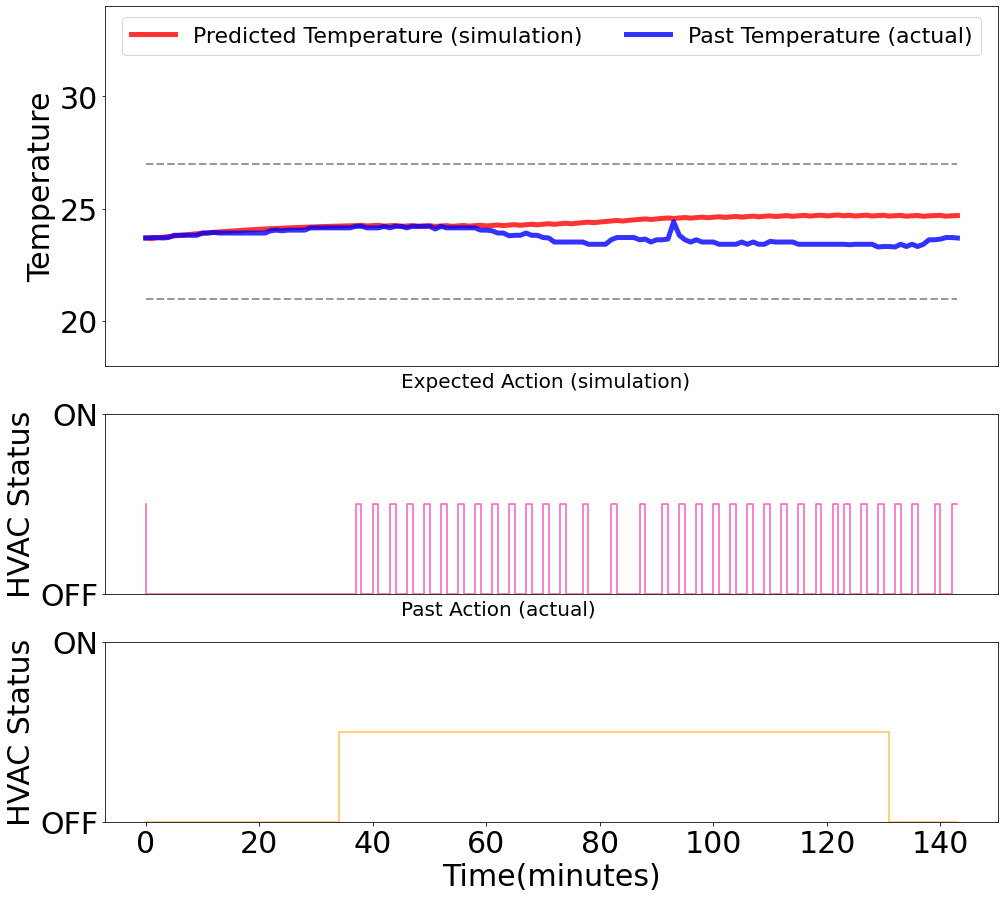

97.0
35
1 일 평균 절감율 :  63.91752577319587 실제 평균 온도 :  23.762013888888905 학습 평균 온도 :  24.36865348276664 오차율 :  -0.606639593877734
/raid/deallab/ecm/model_result/2019-10-24/20191024w7_linear_regression.joblib
F_SET_MODE_4
Reset data f3_temp : 23.72
[1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0]
2019-10-24 실제 데이터 길이 :  144  : real action :  97.0 , expected action :  38 실제 평균 온도 :  23.554791666666656 학습 평균 온도 :  24.311580287768848


<Figure size 432x288 with 0 Axes>

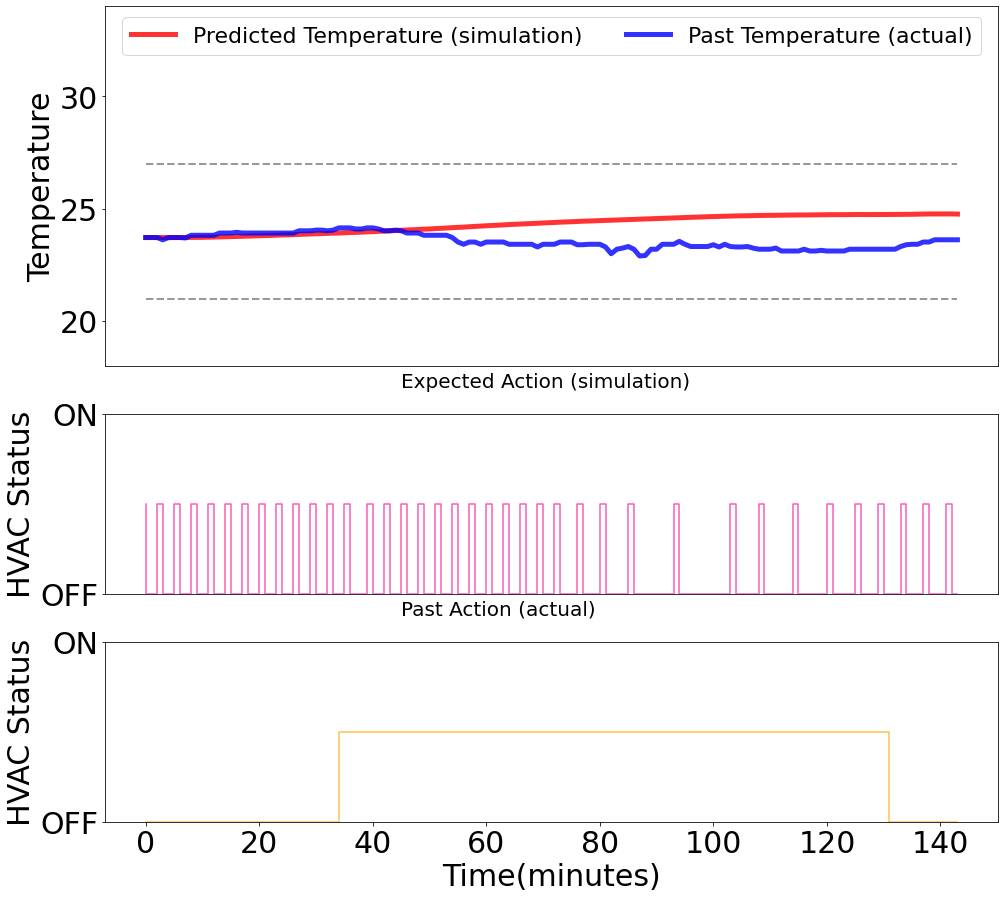

97.0
38
1 일 평균 절감율 :  60.824742268041234 실제 평균 온도 :  23.554791666666656 학습 평균 온도 :  24.311580287768848 오차율 :  -0.7567886211021921


In [38]:
Train_date =  datetime.date(2019,8,23)
#start_date = datetime.date(2019, 8,23)
end_date = datetime.date(2019,10,24)
daterange = pd.date_range(Train_date, end_date)

checkpoint_path = '/raid/deallab/yechae/ECM/2023/result/2019-10-24/RL_ECM_DoubleDQN_2023-02-02_03-54-223a2rx4ka/checkpoint_006100/checkpoint-6100'
print(checkpoint_path)

max_action = getMaxAction(df_test_pre)
path = f'/raid/deallab/ecm/model_result/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w{Train_window_size}_linear_regression.joblib'
method_name = "Env_ML"
env_config = {'max_temp': 27, 'min_temp' : 21, 'method_name': method_name, 'model' : path, 'max_action' : max_action, 'init_data' : df_test_pre}


env = ECM_Env_ML(env_config)
select_env = "ECMEnv2023-v0"
register_env(select_env, lambda config: ECM_Env_ML(env_config))

# print(path)
    
save_path = f'/raid/deallab/yechae/ECM/2023/result/{Train_date.strftime("%Y-%m-%d")}/' #./result/agent
trainer_dqn = agents.dqn.DQNTrainer(config_dqn, env=select_env, logger_creator = custom_log_creator(os.path.expanduser(save_path), 'RL_ECM_DQN-Double'))
    
trainer_dqn.restore(checkpoint_path)
result_final_df = pd.DataFrame()


for single_date in daterange:
    cur_model = best_forecastmodel[(pd.to_datetime(best_forecastmodel.index).date) == Train_date]
    df_test_pre = makeData(df_train, Train_date)
    date = datetime.datetime.strptime(cur_model.index.values[0], '%Y-%m-%d')
    Train_window_size = cur_model.window_size.values[0]
    model_name = cur_model.model.values[0]
    
    if Train_date == datetime.date(2019,10,3) or Train_date == datetime.date(2019,10,4):  # 결측 데이터 처리 
        df_test_pre = df_test_pre.interpolate(method='linear', limit_direction='forward')
    
    #dl_path = f'/raid/deallab/ecm/model_result_no_window_dl/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w{Train_window_size}_{model_name}.h5'
#     one_day_path =  f'/raid/deallab/ecm/model_result_no_window/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w1_linear_regression.joblib'
#     seven_day_path =  f'/raid/deallab/ecm/model_result_no_window/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w7_linear_regression.joblib'
#     fourtenn_day_path =  f'/raid/deallab/ecm/model_result_no_window/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w14_linear_regression.joblib'
#     model_path = f'/raid/deallab/ecm/model_result_no_window/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w21_linear_regression.joblib'


#     if Train_date <= datetime.date(2019,8,28):
#         path = one_day_path
#     elif Train_date <= datetime.date(2019,9,4):
#         path = seven_day_path
#     elif Train_date <= datetime.date(2019, 9,11):
#         path = fourtenn_day_path
#     else:
#         path = model_path
    path = f'/raid/deallab/ecm/model_result/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w{Train_window_size}_linear_regression.joblib'
    print(path)
    
    max_action = getMaxAction(df_test_pre)    
    
    real_df, next_df, actions, result_df = result_base_RL([df_test_pre], Train_date, path, max_action, trainer_dqn)
    new_df = pd.DataFrame()
    new_df.index = real_df.index
    new_df['real_temp'] = real_df['temp']
    new_df['real_hum'] = real_df['hum']
    new_df['real_action'] = real_df['action']
    new_df['RL_temp'] = next_df['f3_temp']
    new_df['RL_hum'] = next_df['f3_hum']
    new_df['RL_action'] = actions
    
    # path 변경하기 
    new_df_path = f'/raid/deallab/yechae/ECM/2023/result/DoubleDQN/{Train_date.strftime("%Y-%m-%d")}-DoubleDQN.csv'
    new_df.to_csv(new_df_path)
    result_final_df = result_df.append(result_final_df)
    
    Train_date = Train_date+datetime.timedelta(days=1)
    
result_df_path = f'/raid/deallab/yechae/ECM/2023/result/DoubleDQN/DoubleDQN_final_result.csv'
result_final_df.to_csv(result_df_path)

    # ENV 세팅
    #env_config = {'max_temp': 27, 'min_temp' : 21, 'method_name': method_name, 'model' : path, 'max_action' : max_action}
    #env = ECM_Env_DL(env_config)
    
    #select_env = "ECMEnv2023-v0"
    #register_env(select_env, lambda config: ECM_Env_DL(env_config))
        

In [42]:
result_final_df

date actual_temp predict_temp power_reduction           0          1  \
0  NaN         NaN          NaN             NaN  2019-08-25  26.732014   
0  NaN         NaN          NaN             NaN  2019-08-24  26.305000   
0  NaN         NaN          NaN             NaN  2019-08-23  24.707986   

           2           3  
0  27.334233   99.280576  
0  24.243274  100.000000  
0  25.616542   98.561151

(scheduler +41m15s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


In [40]:
result_df

date actual_temp predict_temp power_reduction           0          1  \
0  NaN         NaN          NaN             NaN  2019-10-01  24.186944   

           2          3  
0  24.273519  99.275362

(scheduler +35m25s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(scheduler +36m0s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


In [ ]:
# Train_date = Train_date = datetime.date(2019,9,21)
# checkpoint_path = checkpoint
# print(checkpoint_path)

# print(Train_date)
# cur_model = best_forecastmodel[(pd.to_datetime(best_forecastmodel.index).date) == Train_date]
# df_test_pre = makeData(df_train, Train_date )
# date = datetime.datetime.strptime(cur_model.index.values[0], '%Y-%m-%d')
# Train_window_size = cur_model.TimeWindows.values[0]
# model_name = cur_model.Model.values[0]

# #dl_path = f'/raid/deallab/ecm/model_result_no_window_dl/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w{Train_window_size}_{model_name}.h5'
# path = f'/raid/deallab/ecm/model_result_no_window/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w{Train_window_size}_{model_name}.joblib'
# max_action = getMaxAction(df_test_pre)
# method_name = "Env_ML"
# env_config = {'max_temp': 27, 'min_temp' : 21, 'method_name': method_name, 'model' : path, 'max_action' : max_action}

# env = ECM_Env_ML(env_config)
# select_env = "ECMEnv2023-v0"
# register_env(select_env, lambda config: ECM_Env_ML(env_config))
# print(path)

# save_path = f'/raid/deallab/yechae/ECM/2023/result/{Train_date.strftime("%Y-%m-%d")}/' #./result/agent
# trainer_dqn = agents.dqn.DQNTrainer(config_dqn, env=select_env, logger_creator = custom_log_creator(os.path.expanduser(save_path), 'RL_ECM_DQN'))

# trainer_dqn.restore(checkpoint_path)

In [ ]:
Train_date = Train_date = datetime.date(2019,9,21)
checkpoint_path = checkpoint
print(checkpoint_path)

for i in range(52):
    print(Train_date)
    cur_model = best_forecastmodel[(pd.to_datetime(best_forecastmodel.index).date) == Train_date]
    df_test_pre = makeData(df_train, Train_date )
    date = datetime.datetime.strptime(cur_model.index.values[0], '%Y-%m-%d')
    Train_window_size = cur_model.TimeWindows.values[0]
    model_name = cur_model.Model.values[0]
    
    #dl_path = f'/raid/deallab/ecm/model_result_no_window_dl/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w{Train_window_size}_{model_name}.h5'
    path = f'/raid/deallab/ecm/model_result_no_window/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w{Train_window_size}_{model_name}.joblib'
    max_action = getMaxAction(df_test_pre)
    method_name = "Env_ML"
    env_config = {'max_temp': 27, 'min_temp' : 21, 'method_name': method_name, 'model' : path, 'max_action' : max_action}
    


    env = ECM_Env_ML(env_config)
    select_env = "ECMEnv2023-v0"
    register_env(select_env, lambda config: ECM_Env_ML(env_config))

    print(path)
    
    save_path = f'/raid/deallab/yechae/ECM/2023/result/{Train_date.strftime("%Y-%m-%d")}/' #./result/agent
    trainer_dqn = agents.dqn.DQNTrainer(config_dqn, env=select_env, logger_creator = custom_log_creator(os.path.expanduser(save_path), 'RL_ECM_DQN'))
    
    trainer_dqn.restore(checkpoint_path)
    
    
    s = "{:3d} reward min : {:6.2f}/ mean : {:6.2f}/ max : {:6.2f}/ len {:6.2f}"
    train_dqn_episode = 100
    reward_dqn_list = pd.DataFrame(columns = ['mean'])
    
    # === Train === 
    start = time.time()
    start_after_for = time.time()
    print(train_dqn_episode)
    for i in range(train_dqn_episode):
        print("start_after_for : ", time.time() - start_after_for )
        start_episode = time.time()
        result = trainer_dqn.train()
        print(s.format(
            i + 1,
            result["episode_reward_min"],
            result["episode_reward_mean"],
            result["episode_reward_max"],
            result["episode_len_mean"]
           ))
        reward_dqn_list = reward_dqn_list.append({'mean': result["episode_reward_mean"]}, ignore_index=True)
        if i % 100 == 0:
            checkpoint = trainer_dqn.save()
            print("checkpoint saved at", checkpoint)
        print("Elapsed time one episode : ", time.time() - start_episode)
        start_after_for = time.time()
    print("Elapsed time : ", time.time() - start)
    checkpoint_path = trainer_dqn.save()

    print("checkpoint saved at", checkpoint)
    
    
    #real_df, next_df, actions, result_df = result_base_RL([df_test_pre], Train_date, path)
    #new_df = pd.DataFrame()
    #new_df.index = real_df.index
    #new_df['real_temp'] = real_df['temp']
    #new_df['real_hum'] = real_df['hum']
    #new_df['real_action'] = real_df['action']
    #new_df['RL_temp'] = next_df['f3_temp']
    #new_df['RL_hum'] = next_df['f3_hum']
    #new_df['RL_action'] = actions
    
    #new_df_path = f'/raid/deallab/yechae/ECM/2023/result/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y-%m-%d")}-DQN-pre.csv'
    #new_df.to_csv(new_df_path)
    #result_df = result_df.append(result_df)
    
    Train_date = Train_date+datetime.timedelta(days=1)
    
#result_df_path = f'/raid/deallab/yechae/ECM/2023/result/DQN_final-pre.csv'
#result_df.to_csv(result_df_path)

#Train_date = Train_date+datetime.timedelta(days=1)
    # ENV 세팅
    #env_config = {'max_temp': 27, 'min_temp' : 21, 'method_name': method_name, 'model' : path, 'max_action' : max_action}
    #env = ECM_Env_DL(env_config)
    
    #select_env = "ECMEnv2023-v0"
    #register_env(select_env, lambda config: ECM_Env_DL(env_config))
        

In [ ]:
# Train_date = Train_date+datetime.timedelta(days=1)
# checkpoint_path = checkpoint

# for i in range(54):
#     print(Train_date)
#     cur_model = best_forecastmodel[(pd.to_datetime(best_forecastmodel.index).date) == Train_date]
#     df_test_pre = makeData(df_train, Train_date )
#     date = datetime.datetime.strptime(cur_model.index.values[0], '%Y-%m-%d')
#     Train_window_size = cur_model.TimeWindows.values[0]
#     model_name = cur_model.Model.values[0]
    
#     dl_path = f'/raid/deallab/ecm/model_result_no_window_dl/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w{Train_window_size}_{model_name}.h5'
#     ml_path = f'/raid/deallab/ecm/model_result_no_window/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w{Train_window_size}_{model_name}.joblib'
#     max_action = getMaxAction(df_test_pre)
#     env_config = {'max_temp': 27, 'min_temp' : 21, 'method_name': method_name, 'model' : path, 'max_action' : max_action}
    
#     if model_name in ml_models:
#         path = ml_path
#         print("ML : ", model_name)
#         #model = joblib.load(path)
#         method_name = "Env_ML"
#         env = ECM_Env_ML(env_config)
#         select_env = "ECMEnv2023-v0"
#         register_env(select_env, lambda config: ECM_Env_ML(env_config))
#     else:
#         path = dl_path
#         print("DL : ", model_name)
#         Train_date = Train_date+datetime.timedelta(days=1)
#         continue;
#         #model = tf.keras.models.load_model(dl_path)
#         #method_name = "Env_DL"
#         #env = ECM_Env_DL(env_config)
#         #select_env = "ECMEnv2023-v0"
#         #register_env(select_env, lambda config: ECM_Env_DL(env_config))
#     print(path)
    
#     save_path = f'/raid/deallab/yechae/ECM/2023/result/{Train_date.strftime("%Y-%m-%d")}/' #./result/agent
#     trainer_dqn = agents.dqn.DQNTrainer(config_dqn, env=select_env, logger_creator = custom_log_creator(os.path.expanduser(save_path), 'RL_ECM_DQN'))
    
#     trainer_dqn.restore(checkpoint_path)
    
    
#     s = "{:3d} reward min : {:6.2f}/ mean : {:6.2f}/ max : {:6.2f}/ len {:6.2f}"
#     train_dqn_episode = 500
#     reward_dqn_list = pd.DataFrame(columns = ['mean'])
    
#     # === Train === 
#     start = time.time()
#     start_after_for = time.time()
#     print(train_dqn_episode)
#     for i in range(train_dqn_episode):
#         print("start_after_for : ", time.time() - start_after_for )
#         start_episode = time.time()
#         result = trainer_dqn.train()
#         print(s.format(
#             i + 1,
#             result["episode_reward_min"],
#             result["episode_reward_mean"],
#             result["episode_reward_max"],
#             result["episode_len_mean"]
#            ))
#         reward_dqn_list = reward_dqn_list.append({'mean': result["episode_reward_mean"]}, ignore_index=True)
#         if i % 500 == 0:
#             checkpoint = trainer_dqn.save()
#             print("checkpoint saved at", checkpoint)
#         print("Elapsed time one episode : ", time.time() - start_episode)
#         start_after_for = time.time()
#     print("Elapsed time : ", time.time() - start)
#     checkpoint_path = trainer_dqn.save()

#     print("checkpoint saved at", checkpoint)
#     Train_date = Train_date+datetime.timedelta(days=1)


# #Train_date = Train_date+datetime.timedelta(days=1)
#     # ENV 세팅
#     #env_config = {'max_temp': 27, 'min_temp' : 21, 'method_name': method_name, 'model' : path, 'max_action' : max_action}
#     #env = ECM_Env_DL(env_config)
    
#     #select_env = "ECMEnv2023-v0"
#     #register_env(select_env, lambda config: ECM_Env_DL(env_config))
        

In [39]:
Train_date = datetime.date(2019,9,21)
# init 
cur_model = best_forecastmodel[(pd.to_datetime(best_forecastmodel.index).date) == Train_date]
df_test_pre = makeData(df_train, Train_date )
date = datetime.datetime.strptime(cur_model.index.values[0], '%Y-%m-%d')
Train_window_size = cur_model.TimeWindows.values[0]
model_name = cur_model.Model.values[0]

dl_path = f'/raid/deallab/ecm/model_result_no_window_dl/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w{Train_window_size}_{model_name}.h5'
ml_path = f'/raid/deallab/ecm/model_result_no_window/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w{Train_window_size}_{model_name}.joblib'
if model_name in ml_models:
    path = ml_path
    print("ML : ", model_name)
    #model = joblib.load(path)
    method_name = "Env_ML"
else:
    path = dl_path
    print("DL : ", model_name)
    #model = tf.keras.models.load_model(dl_path)
    method_name = "Env_DL"
print(path)
max_action = getMaxAction(df_test_pre)

# ENV 세팅
env_config = {'max_temp': 27, 'min_temp' : 21, 'method_name': method_name, 'model' : path, 'max_action' : max_action}
env = ECM_Env_ML(env_config)

select_env = "ECMEnv2023-v0"
register_env(select_env, lambda config: ECM_Env_ML(env_config))

config_dqn = agents.dqn.DEFAULT_CONFIG.copy()
config_dqn["log_level"] = "WARN"
config_dqn["env"] = select_env
config_dqn["env_config"] = env_config
config_dqn["evaluation_num_workers"] = 1
config_dqn["train_batch_size"] = 256
# config_dqn["model.fcnet_activation"] = 'relu'
config_dqn["target_network_update_freq"] = 50
config_dqn["learning_starts"] = 800
config_dqn["timesteps_per_iteration"] = 144
config_dqn["num_gpus_per_worker"] = 1
config_dqn["model"]["custom_model"] = False
#config_dqn["model"]["custom_model"] = "my_model"
config_dqn["model"]["fcnet_hiddens"] = [256,256]
config_dqn["model"]["fcnet_activation"] = "relu"
config_dqn["n_step"] = 144
config_dqn["dueling"] = False
config_dqn["double_q"] = False

save_path = f'/raid/deallab/yechae/ECM/2023/result/{Train_date.strftime("%Y-%m-%d")}/' #./result/agent
print(save_path)
trainer_dqn = agents.dqn.DQNTrainer(config_dqn, env=select_env, logger_creator = custom_log_creator(os.path.expanduser(save_path), 'RL_ECM_DQN'))

2023-01-26 15:02:22,874	INFO trainer.py:2141 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also then want to set eager_tracing=True in order to reach similar execution speed as with static-graph mode.
2023-01-26 15:02:22,879	WARNING trainer.py:2348 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.
2023-01-26 15:02:22,883	INFO simple_q.py:155 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting `simple_optimizer=True` if this doesn't work for you.
2023-01-26 15:02:22,883	INFO trainer.py:781 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


ML :  extra_trees_regressor
/raid/deallab/ecm/model_result_no_window/2019-09-21/20190921w14_extra_trees_regressor.joblib
Reset data f3_temp : 25.2
/raid/deallab/yechae/ECM/2023/result/2019-09-21/
Reset data f3_temp : 25.2
Reset data f3_temp : 24.6


2023-01-26 15:02:35,609	WARNING deprecation.py:46 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
2023-01-26 15:02:35,610	WARNING trainer.py:2348 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.
2023-01-26 15:02:35,868	INFO trainable.py:130 -- Trainable.setup took 12.995 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
